## MILK CONSUMERS TYPES

Target: identify comsumer types on russian milk market for devloping stragegy of clients brands

Data: Its results of quantitative survey milk buyers about behavior, design preferences, brands loyality, price and quality preferences.

Attachments: questionary (russian version with original format, english after automatic translation) and csv file - database

Data types: most parts of data are categorical variables.


### RESEARCH PLAN

1. Describe TA
2. Purchase volume
3. Consumer behavior: frequencies and correlation
4. Claster analysis
5. Summary

In [1]:
#импорт всех необходимых библиотек

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import matthews_corrcoef
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import KernelDensity
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples


import tkinter as tk
from tkinter import scrolledtext

import hdbscan

import os  #зависит от os.environ['OMP_NUM_THREADS'] = '3'

import warnings

from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage

from collections import Counter
import re


warnings.filterwarnings('ignore')



C:\Users\OLEG\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#download and basic data wiew 

df = pd.read_csv( r'C:\Users\OLEG\Jupyter\Milk_clasters\Milk_products_eng_cod_clear.csv', sep=';')
df.head()

Number       id gender  birth_day  birth_month  birth_year  how_old  \
0       1  1161185      m         12            7        1979       36   
1       2  1161192      m          3            7        1973       42   
2       3  1161201      m         29            6        1980       35   
3       4  1161206      m         20            4        1974       42   
4       5  1161218      m          1            6        1977       38   

  age_type           city income  ...  how_many_family children_have  \
0    36_45         Moscow    Mid  ...                3             1   
1    36_45         Moscow   Mid-  ...                4             1   
2    25_35  Elkaterinburg    Mid  ...                3             1   
3    36_45  Elkaterinburg   Mid-  ...                1             2   
4    36_45    S_Peterburg   Mid+  ...                5             1   

  children_how_many youngest_year youngest_month have_cat have_dog have_other  \
0               1.0           9.0            3.0        0        0          0   
1               2.0           2.0            3.0        0        0          0   
2               1.0           6.0            0.0        1        0          1   
3               NaN           NaN            NaN        0        0          0   
4               3.0           2.0            0.0        1        0          0   

  havnt_pet     have_other.1  
0         1              NaN  
1         1              NaN  
2         0  черепаха, рыбки  
3         1              NaN  
4         0              NaN  

[5 rows x 470 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Columns: 470 entries, Number to have_other.1
dtypes: float64(153), int64(274), object(43)
memory usage: 1.9+ MB


### About data

521 interviews and 470 colunms. 

Many variables are multivariant variables and code with 0 or 1 for each answer variant as separate variable.

Table has info about (see questionary (russian version with original format, english after automatic translation) and csv file):



### Block 1: Describe TA

#### Specific

quantitative survey milk buyers had some limitation for TA (based on previous research and open data):

Age: 25-45 
Male/Femail
Living:
   - Moscow (biggest and highest income city in Russia)
   - Sankt Petersburg (second large city, specific consumer preferences)
   - Ekaterindirg (big city in Ural, as rule more traditional preferences)
   
Income: self-determination. Lowerst level (income doesnt enogh for food) except from  research TA.

Chousing food brand singly or active role with other family members

Buy:
    - Milk every week or more often
    - Butter 2-3 times in mounth or more often
    - Sour cream (smetana) every week or more often



#### Gender, age, city 


- Comments: same situation in different cities
- Half respondents are 30-42 y.o. for man and 28-39 for woman
- Man more active near 40 y.o.

<AxesSubplot:xlabel='city', ylabel='how_old'>

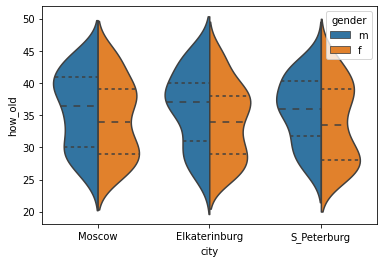

In [4]:
sns.violinplot(data=df, x="city", y="how_old", hue="gender", split=True, inner="quart")

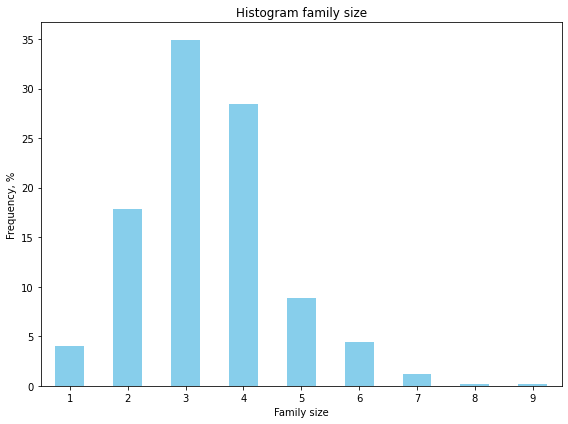

In [5]:
counts = df['how_many_family'].value_counts()
sum_c = counts.sum()
percent_counts = counts/sum_c*100
percent_counts = percent_counts.sort_index()

plt.figure(figsize=(8, 6)) 

percent_counts.plot(kind='bar', color='skyblue')


plt.title('Histogram family size')
plt.xlabel('Family size')
plt.ylabel('Frequency, %')


plt.xticks(rotation=0)
plt.tight_layout() 

plt.show()

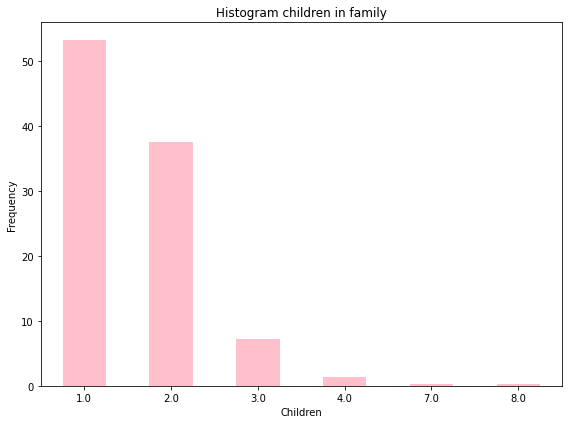

In [6]:
counts = df['children_how_many'].value_counts()
sum_c = counts.sum()
percent_counts = counts/sum_c*100
percent_counts = percent_counts.sort_index()

plt.figure(figsize=(8, 6)) 

percent_counts.plot(kind='bar', color='pink')


plt.title('Histogram children in family')
plt.xlabel('Children')
plt.ylabel('Frequency')


plt.xticks(rotation=0)
plt.tight_layout() 

plt.show()

Family main info

- Most popular family size: 3-4 people
- Children: 1 or 2
- Half of respondents have middle income

### Income

Respondents made self-estimates income in 5 ranges



In [7]:
counts = df['income'].value_counts()
sum_c = counts.sum()
percent_counts = counts/sum_c*100
new_order = ['High', 'Mid+', 'Mid', 'Mid-', 'Low']
percent_counts = percent_counts.reindex(new_order)
print ('Income levels self-determination, %')
print(percent_counts.round(1))

Income levels self-determination, %
High     2.1
Mid+    20.7
Mid     47.6
Mid-    25.7
Low      3.8
Name: income, dtype: float64


### Block 2: Purchase volume

We have data: 
   - How many pack buy every month
   - Pack size


Steps:
- Correct data for type
- Analyse data
- Calculate month vol 

In [8]:
df['milk_pack'] = df['milk_pack'].astype(int)
df['milk_pack'].describe()


count    521.000000
mean      13.758157
std        9.146829
min        1.000000
25%        6.000000
50%       10.000000
75%       20.000000
max       30.000000
Name: milk_pack, dtype: float64

In [9]:

df['milk_vol'] = df['milk_vol'].str.replace(',', '.')
df['milk_vol'] = df['milk_vol'].astype(float)
df['milk_vol'].describe()


count    521.000000
mean       1.015163
std        0.230677
min        0.200000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: milk_vol, dtype: float64

In [10]:
# Calculate mounth byuing in volume 

df['milk_consumption'] = df['milk_pack']*df['milk_vol']
df['butter_consumption'] = df['butter_pack']*df['butter_vol']
df['smetana_consumption'] = df['smetana_pack']*df['smetana_vol']

--------------------------------
Аналитика по столбцу milk_consumption
count    521.000000
mean      13.915355
std       10.021521
min        0.500000
25%        6.000000
50%       10.000000
75%       20.000000
max       60.000000
Name: milk_consumption, dtype: float64


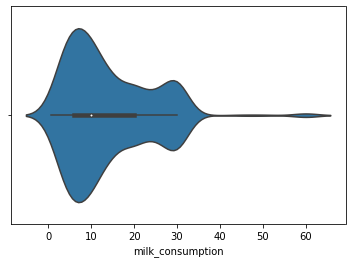

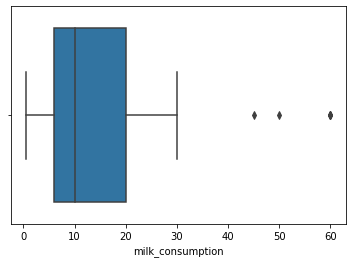

--------------------------------
Аналитика по столбцу butter_consumption
count     521.000000
mean     1047.984645
std       827.397895
min       100.000000
25%       600.000000
50%       800.000000
75%      1200.000000
max      7500.000000
Name: butter_consumption, dtype: float64


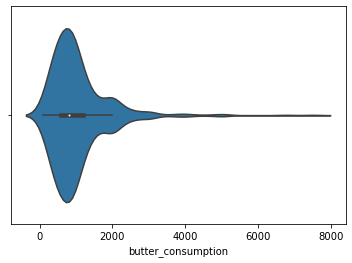

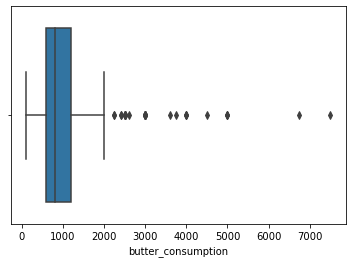

--------------------------------
Аналитика по столбцу smetana_consumption
count      521.000000
mean      2136.084453
std       1756.647601
min        150.000000
25%       1000.000000
50%       1600.000000
75%       2500.000000
max      12000.000000
Name: smetana_consumption, dtype: float64


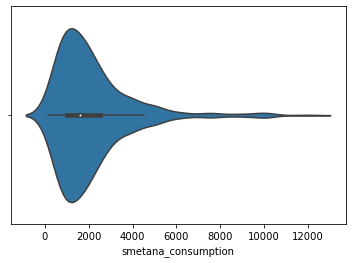

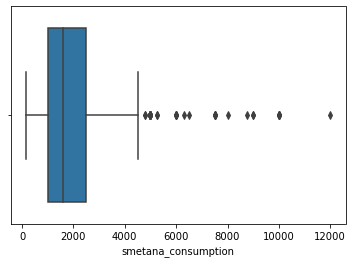

In [11]:
# Visualisation buying per products

Ints = ['milk_consumption', 'butter_consumption', 
       'smetana_consumption']

for i in Ints:
    print('--------------------------------')
    print('Аналитика по столбцу', i)
    print(df[i].describe())
    sns.violinplot(x=df[i])
    plt.show()
    sns.boxplot(x=df[i])
    plt.show()

#### Average consumption

- Milk: 10 litters, most popular (50% of consumers): 6-20 litters
- Butter: near 1 kg, most popular (50% of consumers): 800-1200 gr
- Smetana (sour cream): near 2 kg, most popular (50% of consumers): 1-2.5 kg

##### Check correlation consumption and family size

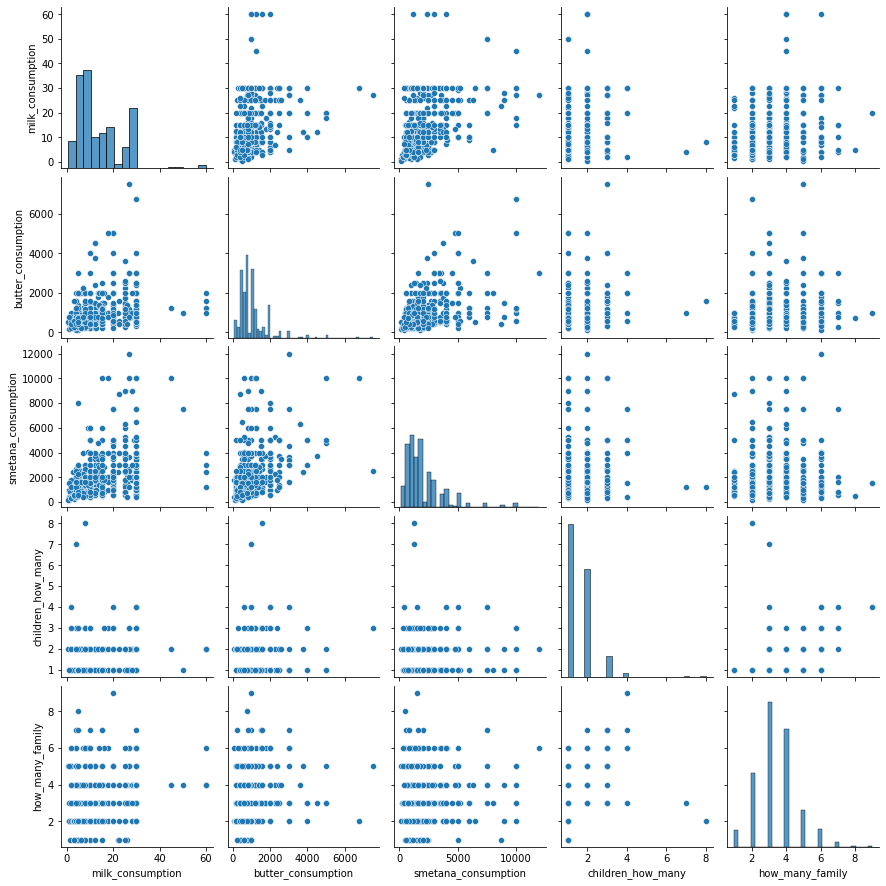

In [12]:
sns.pairplot(df[['milk_consumption', 'butter_consumption', 
       'smetana_consumption', 'children_how_many', 'how_many_family']])

Visual analysis avoid to see correlation between different product consumption, but its not allow to say about depending family size and consumption.  

Its will be check on the next step additional.


### Block 3: Consumer behavior: frequencies and correlation

#### Analysis of main part of variables

Analyse how next criterias influence on consumption:

Вопрос анкеты:
- **Изменения в покупательском поведение в последние 1-2 года**  buy_change
- 1.	У нас всё хорошо, никаких изменений не заметили
- 2.	Уверены в завтрашнем дне, уровень жизни повысился
- 3.	Пришлось отказаться от любимых деликатесных продуктов. Подстраиваемся и заново выбираем марки продуктов для повседневного рациона
- 4.	Кризис заставил задуматься и начать экономить на покупках, но уровень жизни не изменился
- 5.	В целом не жалуемся. Приспособились к новым ценам: где-то покупаем продукты подешевле, что-то начали готовить дома
- 6.	Стали жить хуже: активно экономим на продуктах питания. Но иногда побаловать себя деньги есть
- 7.	Пришлось совсем затянуть пояса и начать сильно экономить на продуктах питания

**доля семейного бюджета которая тратится на питание**  'food_share
- 1.	Менее 20%
- 2.	21-40%
- 3.	41-60%
- 4.	61-80%
- 5.	81-100%



In [13]:
#цикл для идентичной обработки различных переменных

Ints = ['buy_change', 'food_share', 'how_to_shopping', 'buying_criteria_milk',  
        'buying_criteria_butter', 'buying_criteria_smetana', 'price-opinion', 'buy_novelty']

result_tables = {}  # Создаем пустой словарь для хранения результатов

for column in Ints:
    
    result_table = df.groupby(column).agg(
        count = (column, 'count'),
        percent = (column, lambda x: (x.count() / len(df)) * 100),
        mean_milk = ('milk_consumption', 'mean'),
        median_milk = ('milk_consumption', 'median'),
        mean_butter = ('butter_consumption', 'mean'),
        median_butter = ('butter_consumption', 'median'),
        mean_smetana = ('smetana_consumption', 'mean'),
        median_smetana = ('smetana_consumption', 'median')
    )
    result_tables[column] = result_table

# Вывод результатов
for var, table in result_tables.items():
    print(f"Для переменной '{var}':")
    print(table)
    print()



Для переменной 'buy_change':
            count    percent  mean_milk  median_milk  mean_butter  \
buy_change                                                          
1              88  16.890595  13.710227         10.0  1156.250000   
2              16   3.071017  13.031250         11.0  1087.500000   
3              94  18.042226  12.489362         10.0   979.255319   
4             121  23.224568  14.744628         12.0  1011.983471   
5             156  29.942418  14.701923         12.0  1082.371795   
6              38   7.293666  12.613158         10.0   864.473684   
7               8   1.535509  13.000000          8.0  1331.250000   

            median_butter  mean_smetana  median_smetana  
buy_change                                               
1                  1000.0   2199.431818          1600.0  
2                   900.0   2112.500000          1900.0  
3                   800.0   2092.021277          1500.0  
4                   800.0   2165.702479          1750.0  
5

Results:
- Changing in consumer behavior (1 - better, 7 - worse): near 71% said that had to save money. But some of them (group 4-5) buy more milk (in Russia its method to decrease food expences: buy milk, bread, eggs instead of meat)
- Share of expenses for food (1 - less 20%, 5 - 80-100%) shows that near 50% spend 20-40% and 30% - 40%-60%. Volume of consumption dont depend on share of expences
- Consumers buy food two times a week as rule. Peoples who buy every day say that buy milk twice as much. But may be its selfmistake. 
- Consumers use the same criteria for choosing: love brands (inportant for 50% consumers), price, fresh. Fresh more important for milk and sour cream (smetana) and less important for butter
- 45% check price every time. Never check only 2%. 
- New brands like to buy for discount 35% and just interest 33%.

#### Проверка схожести мотивов покупок для разных товаров

In [14]:
def plot_heatmap(data, variable1, variable2):
    cross_tab = pd.crosstab(data[variable1], data[variable2])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Тепловая карта для переменных {variable1} и {variable2}')
    plt.xlabel(variable2)
    plt.ylabel(variable1)
    plt.show()

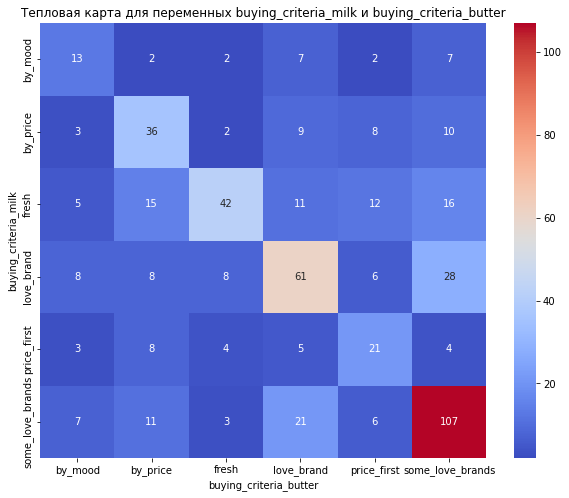

In [15]:


plot_heatmap(df, 'buying_criteria_milk', 'buying_criteria_butter')


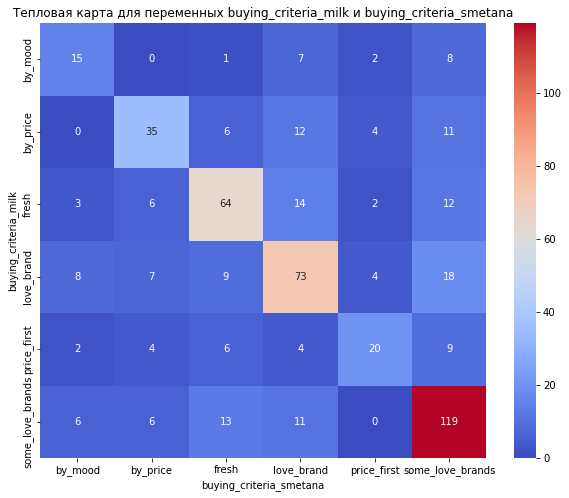

In [16]:
plot_heatmap(df, 'buying_criteria_milk', 'buying_criteria_smetana')

Strong addiction is between creteria for different goods. The same criteria for different goods.

**Проверка зависимости доли расходов на еду и мотивации покупки новинок**

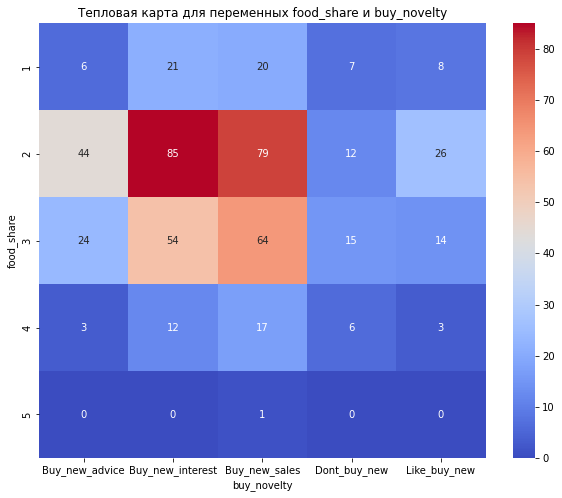

In [17]:
plot_heatmap(df, 'food_share', 'buy_novelty')

**Основные выводы**
- Мотив интереса более присущ людям со сравнительно небольшой долей расходов на еду
- Скидки на новинки больше привлекают людей со средним и низким уровнем расходов на еду
- Любовь к новинкам чаще у людей с небольшой долей расходов на еду
- Нелюбовь к новинкам не имеет явной связи с уровнем расходов


##### Проверка зависимости склонности и мотивов покупки новинок и мотивов покупки молока

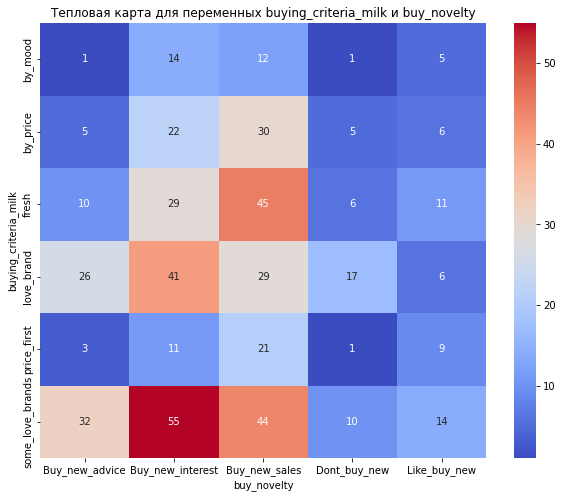

In [18]:
plot_heatmap(df, 'buying_criteria_milk', 'buy_novelty')

- Те кто выбирает молоко по цене и при покупке новых чаще ориентируются на скидки
- Те у кого есть корзина любимых брендов или даже один любимый бренд, чаще других склонны покупать исходя из любопытства
- Любители свежести чаще всего ориентируются на скидки по новым товарам

- Buy new brand for intererst more typical for brand lovers. Buy new brands for sale typical for all types of criteria.


##### Analysis variables 'Try_': motivations for buying new brands 

Вопрос анкеты:
	Оцените, пожалуйста, что Вас лично скорее побудит попробовать новую марку.
Выберете не больше трех вариантов ответа
- 1.	Симпатичный милый персонаж на упаковке
- 2.	Экологичное место производства продукта
- 3.	Выгодная/невысокая цена
- 4.	Нестандартный материал/форма упаковки
- 5.	Привлекательная реклама в магазине/телевидении/интернете
- 6.	Совет близких/знакомых/коллег
- 7.	Оригинальные свойства или рецепт продукта
- 8.	Яркий цвет упаковки
- 9.	Привлекательное название
- 10.	Марка бросилась в глаза
- 11.	Гарантии качества (сертификаты, знаки)
- 12.	Новая марка от известного производителя
- 13.	Необычно высокая цена
- 14.	Вкусное изображение продукта на упаковке
- 15.	Понравился дизайн
- 16.	Выглядит как солидный продукт
- 17.	Никакой из этих вариантов - исключающий


In [19]:

Ints = ['try_hero', 'try_ecology', 'try_price', 'try_pack', 'try_ads','try_advise', 
        'try_recipe', 'try_color', 'try_name', 'try_eyesstop',
        'try_quality', 'try_brand', 'try_expencive', 'try_foodzone',
        'try_design', 'try_solid', 'rty_nothing']

result_table = pd.DataFrame(columns=['name', 'sum', 'percent'])

for i in Ints:
    new_row = pd.DataFrame({
    'name': i,
    'sum': df[i].sum(),
    'percent': (df[i].sum() / df[i].shape[0] * 100).round(1)}, index=[i])
    result_table = pd.concat([result_table, new_row], ignore_index=False)

print(result_table.sort_values(by='sum', ascending=False))



                        name  sum  percent
try_price          try_price  265     50.9
try_advise        try_advise  210     40.3
try_ecology      try_ecology  140     26.9
try_brand          try_brand  134     25.7
try_quality      try_quality  122     23.4
try_recipe        try_recipe   78     15.0
try_solid          try_solid   65     12.5
try_eyesstop    try_eyesstop   53     10.2
try_ads              try_ads   39      7.5
try_foodzone    try_foodzone   37      7.1
try_design        try_design   37      7.1
try_pack            try_pack   23      4.4
rty_nothing      rty_nothing   14      2.7
try_hero            try_hero   12      2.3
try_name            try_name   11      2.1
try_color          try_color    9      1.7
try_expencive  try_expencive    8      1.5


Motivation to buy new brands: price and advise friends - most popular causes.
- second level: famouse brand, ecology facts, quality sertificate.
- third level: reciepes, solid (design), eyestops. Plus: ads, foodzone, design.

No correlation between causes (used only most popular variants)
Matthews coefficient is more convinient for binarity data

For compare: bellow pearson coefficient - the same results

Next steps Im planning to reduce dimensionality for using data in main classifiacation

**Проверим есть ли зависимости между разными вариантами ответов**

In [20]:
df_corr = df[['try_hero', 'try_ecology', 'try_price', 'try_pack', 'try_ads', 
        'try_advise', 'try_recipe', 'try_color', 'try_name', 'try_eyesstop',
        'try_quality', 'try_brand', 'try_expencive', 'try_foodzone', 
        'try_design', 'try_solid', 'rty_nothing']]

# Классический коэф Пирсона

corr_matrix = df_corr.corr(method='pearson')

print ('Корреляционная матрица. Коэффициент Пирсона')
print (corr_matrix.round(1))
print ('')

# Коэф Метьюсона, как более подходящий для бинарных данных

df_corr = df_corr.astype(str)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        corr_matrix.iloc[i, j] = matthews_corrcoef(df_corr.iloc[:, i], df_corr.iloc[:, j])

print ('Корреляционная матрица. Коэффициент Метьюсона')
print(corr_matrix.round(1))




Корреляционная матрица. Коэффициент Пирсона
               try_hero  try_ecology  try_price  try_pack  try_ads  \
try_hero            1.0         -0.1       -0.1       0.0      0.1   
try_ecology        -0.1          1.0       -0.2      -0.0     -0.1   
try_price          -0.1         -0.2        1.0      -0.1     -0.1   
try_pack            0.0         -0.0       -0.1       1.0      0.1   
try_ads             0.1         -0.1       -0.1       0.1      1.0   
try_advise         -0.1         -0.1       -0.1      -0.0     -0.0   
try_recipe          0.0          0.0       -0.1      -0.0     -0.0   
try_color           0.1         -0.0        0.0      -0.0      0.0   
try_name           -0.0         -0.0       -0.0       0.0      0.1   
try_eyesstop       -0.0         -0.1       -0.0      -0.0     -0.0   
try_quality         0.0          0.2       -0.0      -0.0     -0.1   
try_brand          -0.0         -0.1       -0.1      -0.1     -0.1   
try_expencive      -0.0         -0.0       -0.

##### Анализ переменной One_brand_different_goods

Вопрос анкеты:
	Представьте себе ситуацию: Вы попробовали новую СМЕТАНУ, которая Вам понравилось. Каково будет Ваше мнение о других продуктах этой новой марки молочных продуктов.
- 1.	Если у производителя хорошая сметана, то и другие продукты тоже должны быть высокого качества (молоко, масло, творог и т.д.). Попробую и их
- 2.	Это разные продукты и их качество никак не связано. У одного производителя при хорошей сметане -  масло или, например, молоко могут быть не очень хорошим
- 3.	Есть шанс, что остальные продукты тоже будут хорошего качества. Но специально пробовать не стану 


In [21]:
results_table = df.groupby('One_brand_different_goods').agg(
            count = ('One_brand_different_goods', 'count'),
            percent = ('One_brand_different_goods', lambda x: (x.count() / len(df)) * 100))
print(results_table)

                           count    percent
One_brand_different_goods                  
all_good                     266  51.055662
may_be                       157  30.134357
no_depend                     98  18.809981


Question: Imagine a situation: You've tried a new sour cream that you like. What will be your opinion about the other products of this new brand of dairy products?

50% appologize that all good of brand will be good, and 30% that may be

Its mean that consumers trust to brands with wide assortment

**Анализ частоты ответов на вопрос о типе производителя**

	Какое из следующих высказываний лучше всего описывает Ваши критерии по отношению к производителю при выборе молочных продуктов (МОЛОКО, СМЕТАНА, СЛИВОЧНОЕ МАСЛО). 
- 1.	Отдаю предпочтение молочным продуктам, произведённым в моём городе или регионе
- 2.	Отдаю предпочтение общероссийским производителям молочных продуктов, вне зависимости от их места производства
- 3.	Выбираю молочные продукты, произведённые подальше от города, в каком-нибудь экологичном месте/районе
- 4.	Отдаю предпочтение региональным производителям
- 5.	Не обращаю внимания на место производства, главное, чтобы продукт нравился


In [22]:
results_table = df.groupby('How_choose_brand').agg(
            count = ('How_choose_brand', 'count'),
            percent = ('How_choose_brand', lambda x: (x.count() / len(df)) * 100))
print(results_table)

                  count    percent
How_choose_brand                  
local               124  23.800384
national             80  15.355086
no_preference       166  31.861804
regional             73  14.011516
village              78  14.971209


Question: Which of the following statements best describes your criteria 
in relation to the manufacturer when choosing dairy products (MILK, SOUR CREAM, BUTTER).

32% hasnt preferences 
only 15% prefer national brands
Other like domestic or local producers

**Анализ участия респондентов в различных промо акциях**

In [23]:
Ints = ['promo_discount_for_one', 'promo_discount_for_two', 'promo_volume', 'promo_two_as_one', 
        'promo_gift', 'promo_ad_product', 'promo_points', 'promo_degustation', 
        'promo_prize', 'promo_other', 'promo_dont_use']

result_data = [{'name': i, 'sum': df[i].sum(), 'percent': round(df[i].sum() / df[i].count() * 100, 2)} for i in Ints]

result_table = pd.DataFrame(result_data).sort_values(by='sum', ascending=False).reset_index(drop=True)

print(result_table)


                      name  sum  percent
0         promo_two_as_one  178    34.17
1             promo_volume  171    32.82
2   promo_discount_for_one  148    28.41
3           promo_dont_use  119    22.84
4   promo_discount_for_two  113    21.69
5             promo_points   72    13.82
6              promo_prize   67    12.86
7         promo_ad_product   63    12.09
8        promo_degustation   50     9.60
9               promo_gift   34     6.53
10             promo_other   22     4.22


Question: What types of promotions in the dairy category have you participated in in the last six months?

23% consumers dont use promo action
Actions with discount more popular than prize action

Next steps Im planning to reduce dimensionality for using data in main classifiacation


**Анализ предпочтений респондентов по покупкам брендов со скидками**

Вопрос:
	Какое из ниже перечисленных высказываний лучше всего описывает Ваше отношение к ценовым акциям в магазине при покупке МОЛОКА, СЛИВОЧНОГО МАСЛА, СМЕТАНЫ.
Ротация – 2 варианта с «1» по «5» или с «5» по «1»
- 1.	Чаще всего покупаю ту марку, на которую есть выгодное ценовое предложение. Если акции нет – покупаю мою стандартную марку
- 2.	Беру товар по акции, если со скидкой продаётся уже знакомая мне марка, или незнакомая марка, которая вызывает доверие
- 3.	Беру товар по акции, только если со скидкой продаётся уже знакомая мне марка
- 4.	 Беру товар по акции, только если со скидкой продаётся марка (одна из марок), которую я покупаю чаще всего
- 5.	Не покупаю товары по акциям


In [24]:
results_table = df.groupby('Sales_preference').agg(
            count = ('Sales_preference', 'count'),
            percent = ('Sales_preference', lambda x: (x.count() / len(df)) * 100))
print(results_table)

                        count    percent
Sales_preference                        
Dont_buy_discount          20   3.838772
buy_any_discount_brand    101  19.385797
buy_known_brand           159  30.518234
buy_lovely_brand          127  24.376200
buy_only_known_brand      114  21.880998


Question: . Which of the following statements best describes your attitude 
to price promotions in the store when buying MILK, BUTTER, SOUR CREAM?

1. Most often, I buy the brand for which there is a favorable price offer. 
If there is no promotion, I buy my standard brand
2. I take a product on sale if a brand that I already know is sold at a discount, 
or an unfamiliar brand that inspires confidence
3. I take a product on sale only if a brand I already know is sold at a discount
4. I take a product on sale only if the brand (one of the brands) 
that I buy most often is sold at a discount
5. I don't buy products on promotions

24% dont change one lovely brand and one of lovelies 21%

Any discount brand prefer 19%

In this case only 4% said that dont use promo. May be its results a lot of promo actions, which is typical bying


#### Design preferences

14 design variants was shown to consumer for chousing likely and unlikely (2-3 for each)
All brands dont sell in Russia, so consumers havent loyality or info except pack.

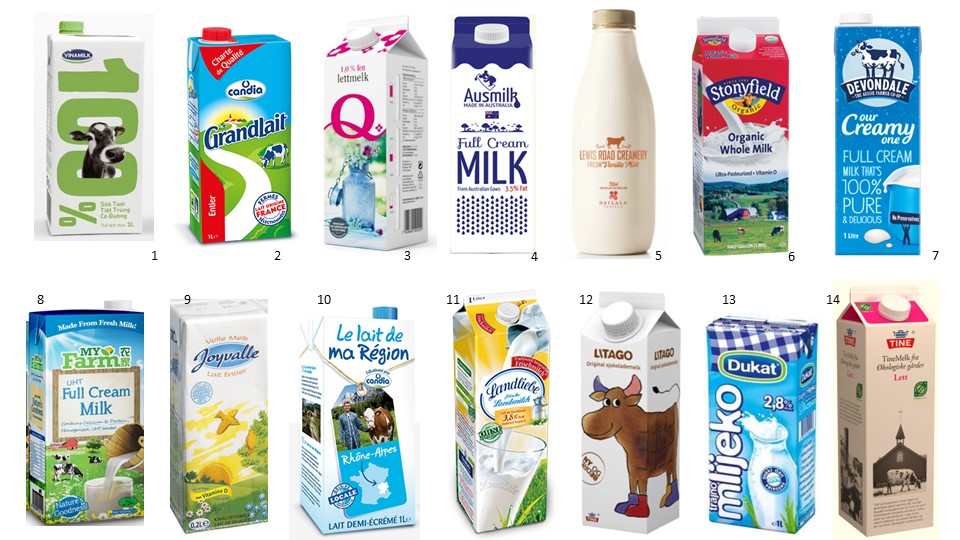

In [25]:
#Расчет числа и доли лайков от общего числа ответивших
#Вид названий изменен, чтобы далее можно было обединить 
#их с аналогичными данными по дизлайкам

Ints = ['Style_var_1', 'Style_var_2', 'Style_var_3', 'Style_var_4', 'Style_var_5', 
        'Style_var_6', 'Style_var_7', 'Style_var_8', 'Style_var_9', 'Style_var_10',
        'Style_var_11', 'Style_var_12', 'Style_var_13', 'Style_var_14']

result_data_buy = []

for i in Ints:
    result_data_buy.append({'name': i[-4:], 'buy_sum': df[i].sum(), 'buy_percent': round(df[i].sum() / df[i].count() * 100, 2)})

result_table_buy = pd.DataFrame(result_data_buy, columns=['name', 'buy_sum', 'buy_percent'])
result_table_buy.head()


name  buy_sum  buy_percent
0  ar_1      142        27.26
1  ar_2      116        22.26
2  ar_3       62        11.90
3  ar_4      136        26.10
4  ar_5      228        43.76

In [26]:
# дизлайки



Ints = ['StyleNo_var_1', 'StyleNo_var_2', 'StyleNo_var_3', 'StyleNo_var_4', 'StyleNo_var_5',
        'StyleNo_var_6', 'StyleNo_var_7', 'StyleNo_var_8', 'StyleNo_var_9', 'StyleNo_var_10',
        'StyleNo_var_11', 'StyleNo_var_12', 'StyleNo_var_13', 'StyleNo_var_14']

result_data_notbuy = []

for i in Ints:
    result_data_notbuy.append({'name': i[-4:], 'dont_buy_sum': df[i].sum(), 'dont_buy_percent': round(df[i].sum() / df[i].count() * 100, 2)})

result_table_notbuy = pd.DataFrame(result_data_notbuy, columns=['name', 'dont_buy_sum', 'dont_buy_percent'])
result_table_notbuy.head()


name  dont_buy_sum  dont_buy_percent
0  ar_1           121             23.22
1  ar_2            67             12.86
2  ar_3            82             15.74
3  ar_4            70             13.44
4  ar_5           122             23.42

In [27]:
# Общая таблица лайков и дизлайков

result_table_buy = result_table_buy.drop_duplicates(subset='name')
result_table_notbuy = result_table_notbuy.drop_duplicates(subset='name')


result_table  = result_table_buy.merge(result_table_notbuy, on='name', how='inner') 
result_table.head(14)

name  buy_sum  buy_percent  dont_buy_sum  dont_buy_percent
0   ar_1      142        27.26           121             23.22
1   ar_2      116        22.26            67             12.86
2   ar_3       62        11.90            82             15.74
3   ar_4      136        26.10            70             13.44
4   ar_5      228        43.76           122             23.42
5   ar_6       92        17.66            55             10.56
6   ar_7       56        10.75            72             13.82
7   ar_8       94        18.04            55             10.56
8   ar_9       25         4.80           158             30.33
9   r_10       96        18.43            55             10.56
10  r_11       72        13.82            46              8.83
11  r_12      122        23.42           137             26.30
12  r_13       93        17.85            94             18.04
13  r_14       92        17.66           145             27.83

Visualisation results:

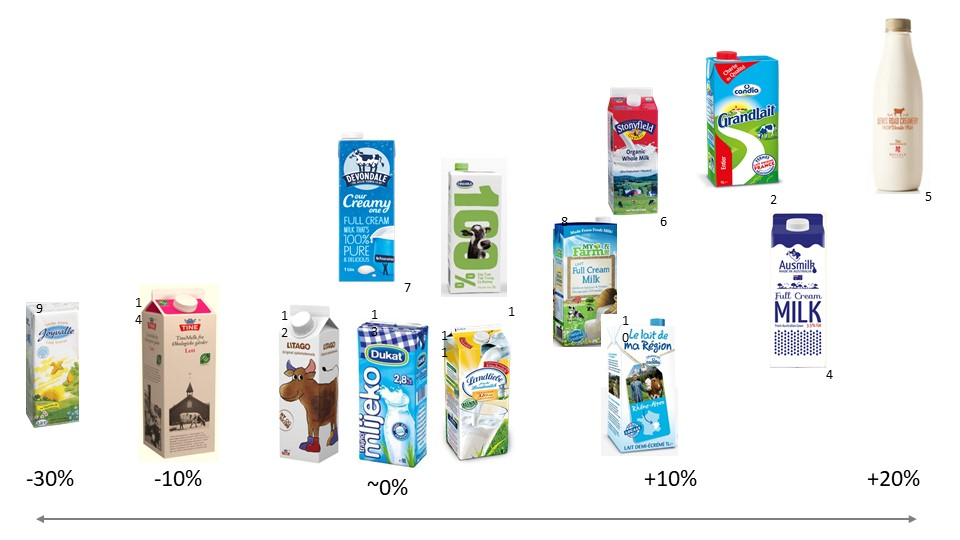  

Graph base on residual positive and negative reactions    
We can see leaders and outsiders

Next steps Im planning to reduce dimensionality for using data in main classifiacation. Try to identity types of stylistic preferences


In [170]:
Ints = ['Style_var_1', 'Style_var_2', 'Style_var_3', 'Style_var_4', 'Style_var_5', 
        'Style_var_6', 'Style_var_7', 'Style_var_8', 'Style_var_9', 'Style_var_10',
        'Style_var_11', 'Style_var_12', 'Style_var_13', 'Style_var_14',   
        'StyleNo_var_1', 'StyleNo_var_2', 'StyleNo_var_3', 'StyleNo_var_4', 'StyleNo_var_5',
        'StyleNo_var_6', 'StyleNo_var_7', 'StyleNo_var_8', 'StyleNo_var_9', 'StyleNo_var_10',
        'StyleNo_var_11', 'StyleNo_var_12', 'StyleNo_var_13', 'StyleNo_var_14']

corr_data = []

for ix in Ints:
    row_values = {'name': ix}  # Создаем новую строку с именем переменной ix
    for iy in Ints:
        correlation = np.corrcoef(df[ix], df[iy])[0, 1].round(1)  # Вычисляем коэффициент корреляции Пирсона
        row_values[iy] = correlation  # Добавляем значение корреляции в строку по соответствующему столбцу iy
    corr_data.append(row_values)

corr_matrix = pd.DataFrame(corr_data)

# Функция для форматирования ячеек таблицы
def color_negative_red(val):
    color = 'red' if abs(val) >= 0.3 else 'black'
    return 'color: %s; font-weight: bold' % color

# Применяем форматирование к таблице
styled_corr_matrix = corr_matrix.style.applymap(color_negative_red, subset=pd.IndexSlice[:, Ints])

# Выводим структурированную таблицу с выделением значений >0.3 и <-0.3 жирным шрифтом
styled_corr_matrix


Metthews coefficient for a analysis correlation.
Some correlation (-0,2 -0,4) are between positive and negative answers. It has logic, but hasnt strong correlation. 
So we can assume, that all data have unique information. 

**Отношение к эко продуктам**

In [29]:
results_table = df.groupby('Eco_products_opinion').agg(
            count = ('Eco_products_opinion', 'count'),
            percent = ('Eco_products_opinion', lambda x: (x.count() / len(df)) * 100))

new_order = ['Better_buy', 'Better_rare', 'Better_dont_buy', 'Same', 'Fake', 'Bad_quality']
results_table = results_table.reindex(new_order)
print(results_table)

                      count    percent
Eco_products_opinion                  
Better_buy               41   7.869482
Better_rare              83  15.930902
Better_dont_buy          93  17.850288
Same                     89  17.082534
Fake                    203  38.963532
Bad_quality              12   2.303263


Question: Which of the following statements best describes your attitude towards IVF products in the dairy category?

There are a lot of fakes for "eco products" now. There is no point in paying attention to these words - opinion 39% consumers

"Eco products" are just a way to cover up low-quality production. Avoiding them - 2%

"Eco products" are higher in quality than ordinary products. I try to buy them mostly - only 8%

Other variants has near 16-18% 
- "Eco products" are of higher quality than regular products, but I don't buy them because of their high cost
- "Eco products" are of higher quality than regular products, but they are difficult to find on sale
- "Eco products" do not differ in quality from conventional dairy products


Next block is about popularity brands
Question: Which brands of MILK have you bought in the last 3 months and which of them do you buy most often?
You can choose a maximum of 3 brands that you "BUY THE MOST".


We have the same questions about milk, butter, smetana

I plan to use it mainly for describing clasters, as competitors

In this block I made rating for 15 most popular milk brands

УДАЛИТЬ???

print(type (df['Eco_products_opinion']))

**Популярность различных марок молока у потребителей**

Ответ на вопрос: какие марки вы покупали за последние 3 месяца

In [30]:
Ints = ['buy_milk_b1', 'buy_milk_b2', 'buy_milk_b3', 'buy_milk_b4', 'buy_milk_b5', 'buy_milk_b6', 
        'buy_milk_b7', 'buy_milk_b8', 'buy_milk_b9', 'buy_milk_b10', 'buy_milk_b11', 'buy_milk_b12',
        'buy_milk_b13', 'buy_milk_b14', 'buy_milk_b15', 'buy_milk_b16', 'buy_milk_b17', 'buy_milk_b18', 
        'buy_milk_b19', 'buy_milk_b20', 'buy_milk_b21', 'buy_milk_b22', 'buy_milk_b23', 'buy_milk_b24', 
        'buy_milk_b25', 'buy_milk_b26', 'buy_milk_b27', 'buy_milk_b28', 'buy_milk_b29', 'buy_milk_b30', 
        'buy_milk_b31', 'buy_milk_b32', 'buy_milk_b33', 'buy_milk_b34', 'buy_milk_b35', 'buy_milk_b36', 
        'buy_milk_b37', 'buy_milk_b38', 'buy_milk_b39', 'buy_milk_b40', 'buy_milk_b41', 'buy_milk_b42', 
        'buy_milk_b43', 'buy_milk_b44', 'buy_milk_b45', 'buy_milk_b46', 'buy_milk_b47', 'buy_milk_b48', 
        'buy_milk_b49', 'buy_milk_b50', 'buy_milk_b51', 'buy_milk_b52', 'buy_milk_b53', 'buy_milk_b54', 
        'buy_milk_b55']

result_data = [{'name': i, 
                'sum': pd.to_numeric(df[i], errors='coerce').sum(), 
                'percent': round(pd.to_numeric(df[i], errors='coerce').sum() / df[i].shape[0] * 100, 2)} 
               for i in Ints]

result_table = pd.DataFrame(result_data, columns=['name', 'sum', 'percent'])
print(result_table.sort_values(by='sum', ascending=False))


            name    sum  percent
0    buy_milk_b1  222.0    42.61
1    buy_milk_b2  186.0    35.70
29  buy_milk_b30  146.0    28.02
32  buy_milk_b33   79.0    15.16
8    buy_milk_b9   69.0    13.24
6    buy_milk_b7   66.0    12.67
19  buy_milk_b20   66.0    12.67
5    buy_milk_b6   61.0    11.71
48  buy_milk_b49   57.0    10.94
47  buy_milk_b48   51.0     9.79
11  buy_milk_b12   50.0     9.60
41  buy_milk_b42   45.0     8.64
21  buy_milk_b22   45.0     8.64
20  buy_milk_b21   45.0     8.64
4    buy_milk_b5   44.0     8.45
33  buy_milk_b34   42.0     8.06
3    buy_milk_b4   41.0     7.87
10  buy_milk_b11   41.0     7.87
13  buy_milk_b14   39.0     7.49
43  buy_milk_b44   35.0     6.72
16  buy_milk_b17   31.0     5.95
53  buy_milk_b54   30.0     5.76
36  buy_milk_b37   29.0     5.57
12  buy_milk_b13   28.0     5.37
7    buy_milk_b8   26.0     4.99
14  buy_milk_b15   25.0     4.80
24  buy_milk_b25   24.0     4.61
28  buy_milk_b29   24.0     4.61
39  buy_milk_b40   23.0     4.41
18  buy_mi

In [31]:
result_table['Number'] = result_table['name'].str.extract(r'(\d+)$')
result_table.head()

name    sum  percent Number
0  buy_milk_b1  222.0    42.61      1
1  buy_milk_b2  186.0    35.70      2
2  buy_milk_b3   15.0     2.88      3
3  buy_milk_b4   41.0     7.87      4
4  buy_milk_b5   44.0     8.45      5

In [32]:
#загрузка данных с названием брендов

df_b = pd.read_csv( r'C:\Users\OLEG\Jupyter\Milk_clasters\brand_names.csv', sep=';')
df_b.head()

Name
0               1. Prostokvashino
1       2. Cottage in the Country
2                  3. New Village
3                   4. 36 kopecks
4  5. M (Lionozovsky Steel Plant)

In [33]:
split_data = df_b['Name'].str.split('.', expand=True)

# Присваиваем новые столбцы к DataFrame
df_b['Number'] = split_data[0]
df_b['Brand'] = split_data[1]

df_b = df_b.drop('Name', axis=1)
df_b.head()

Number                         Brand
0      1                Prostokvashino
1      2        Cottage in the Country
2      3                   New Village
3      4                    36 kopecks
4      5   M (Lionozovsky Steel Plant)

In [34]:
#объединение датафрейма с названиями и датафрейма с номерами брендов 
#в общую таблицу с рассчетом процентов

result_table = result_table.merge(df_b, on='Number', how='inner')
result_table = result_table.drop(['name', 'Number'], axis=1)
result_table = result_table.sort_values(by='percent', ascending=False)

desired_order = ['Brand', 'percent', 'sum']
# Отображаем первые 15 строк в новом порядке переменных
print(result_table[desired_order].head(25))


                           Brand  percent    sum
0                 Prostokvashino    42.61  222.0
1         Cottage in the Country    35.70  186.0
28                       Ecomilk    28.02  146.0
31           Bratya Cheburashkin    15.16   79.0
8                  Brest-Litovsk    13.24   69.0
18                     Yasny lug    12.67   66.0
6                    Vkusnoteevo    12.67   66.0
5                        33 cows    11.71   61.0
47                       Big Mug    10.94   57.0
46                        Losevo     9.79   51.0
11                       Vologda     9.60   50.0
40                       Belebey     8.64   45.0
20                     Ostankino     8.64   45.0
19                      Parmalat     8.64   45.0
4    M (Lionozovsky Steel Plant)     8.45   44.0
32                    Irbitskoye     8.06   42.0
3                     36 kopecks     7.87   41.0
10             Savushkin product     7.87   41.0
13                         Valio     7.49   39.0
42              Vill

### Block 4: Claster analysis



##### Method:
- Making classterisation based on changeable (from brand owner) characteristics (positioning, properties, design)/ This parametres we can change in new brands. Other parametres we will be use for understanding consumer behavior and competitors for new brands.

For classterisation we can use variables:
- Region - 3 – we can develop merchandizing by regions
- how_to_shopping - 5 -we can chouce types of shop
- price-opinion - 4
- buy_novelty - 5
- buying_criteria_milk  - 6 – only one cause hi correlation. Milk most - volume of sales
- try_ - 16 variants
- One_brand_different_goods - 3
- How_choose_brand – 5 
- Sales_preference - 5
- Style_var_notbuy / Style_var_buy  - 14 + 14 vars
- Eco_products_opinion - 6


##### Work plan:
- Reduce data for design preferences and trying criteria
- Prepare all data for cluster analysis
- Make cluster analysis variants



#### 4.1 Reduction

##### 4.1.1 Reduction for design preferences

I use methods:
- PCA 
- MDS 
- TruncatedSVD (convinient for sparse data, in this case has not more than 3 label 1 for each 14 variables)

For compare results use **explained variance** and **silhouette** for k-means cluster analysis redused data.

Make some functions for repeating processes


In [35]:
import warnings
warnings.filterwarnings('ignore')


#функция рассчета k-means и визуализации результатов

def kmeans_func(df_c, max_clusters):
    
    distortions = []
    silhouette_scores = []
    davies_bouldin_scores = []
    kmeans_labels_dict = {}

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=12345, n_init=10)
        kmeans.fit(df_c)
        kmeans_labels = kmeans.labels_
        distortions.append(kmeans.inertia_)
        
        silhouette_avg = silhouette_score(df_c, kmeans_labels)
        silhouette_avg = round(silhouette_avg, 2)
        silhouette_scores.append(silhouette_avg)
        
        davies_bouldin_idx = davies_bouldin_score(df_c, kmeans_labels)
        davies_bouldin_idx = round(davies_bouldin_idx, 2)
        davies_bouldin_scores.append(davies_bouldin_idx)
        
        kmeans_labels_dict[k] = kmeans_labels

        print(f"Number of clusters: {k}, Silhouette Score: {silhouette_avg}, Davies-Bouldin Index: {davies_bouldin_idx}")

    # Визуализация локтя
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion (Within-cluster Sum of Squares)')
    plt.grid(True)
    plt.show()

    # Возвращаем метки кластеров для max_clusters
    optimal_labels = kmeans_labels_dict[max_clusters]
    return optimal_labels



In [36]:
#function for basic description clusters quantity and volume of consumption

def clusters_describe_func (labels):
    df_describe = df.copy()
    df_labels = pd.DataFrame(labels, columns=['label'])
    df_describe = pd.concat([df_describe, df_labels], axis=1)
    grouped = df_describe.groupby(['label'])
    result = grouped.agg({'label': 'size', 'milk_consumption': 'mean', 
                          'butter_consumption': 'mean', 'smetana_consumption': 'mean'})
    average = result.mean(axis=0)
    result.loc['average'] = average
    #result = pd.concat([result, average], ignore_index=True)
    print('Size and consumption in clasters')
    print(result)    
    
    return None


In [37]:
#функция показывает веса компонент

def component_weight (df_design, components_weights, number_vars):
    
    # Визуализация весов
    plt.figure(figsize=(20, 6))
    plt.imshow(components_weights, cmap='viridis', aspect='auto')
    plt.colorbar(orientation='vertical', label='Weight')
    plt.xticks(range(number_vars), df_design.columns[:number_vars], rotation=45, ha='right')  # Используем только первые 15 переменных
    plt.yticks(range(pca_model.n_components_), ['PC{}'.format(i + 1) for i in range(pca_model.n_components_)])
    plt.title('Weights of Variables for Each Principal Component')
    plt.show()
    
    return None

In [39]:
#функция для описания кластеров их сравнительных характеристик по переменным датафрейма


def create_cluster_tables(df, labels):
    # Создаем датафрейм с данными о кластерах
    cluster_df = pd.DataFrame({'Cluster': labels})
    
    # Исключаем переменные из списка
#   excluded_variables = [
 #       'try_hero', 'try_ecology', 'try_price', 'try_pack', 'try_ads', 
 #       'try_advise', 'try_recipe', 'try_color', 'try_name', 'try_eyesstop',
 #       'try_quality', 'try_brand', 'try_expencive', 'try_foodzone', 
 #       'try_design', 'try_solid', 'rty_nothing',
 #       'Style_var_1', 'Style_var_2', 'Style_var_3', 'Style_var_4', 'Style_var_5', 
 #       'Style_var_6', 'Style_var_7', 'Style_var_8', 'Style_var_9', 'Style_var_10',
 #       'Style_var_11', 'Style_var_12', 'Style_var_13', 'Style_var_14',
 #       'StyleNo_var_1', 'StyleNo_var_2', 'StyleNo_var_3', 'StyleNo_var_4', 'StyleNo_var_5',
 #       'StyleNo_var_6', 'StyleNo_var_7', 'StyleNo_var_8', 'StyleNo_var_9', 'StyleNo_var_10',
 #       'StyleNo_var_11', 'StyleNo_var_12', 'StyleNo_var_13', 'StyleNo_var_14'
 #   ]
    
    excluded_variables = []
    
    # Получаем список бинарных переменных
    binary_variables = [col for col in df.columns if col not in excluded_variables]
    
    # Создаем три датафрейма для каждой группы переменных
    for group in range(3):
        # Выбираем бинарные переменные для текущей группы
        group_variables = binary_variables[group * 14: (group + 1) * 14]
        
        # Создаем таблицу для текущей группы
        cluster_table = pd.DataFrame(index=group_variables, columns=np.unique(labels))
        
        # Заполняем таблицу долей положительных значений
        for cluster_num in np.unique(labels):
            cluster_data = df[cluster_df['Cluster'] == cluster_num][group_variables]
            cluster_table[cluster_num] = cluster_data.mean()
        
        # Выводим таблицу на экран
        print(f"Cluster Table for Group {group + 1}:\n{cluster_table}\n")






**Снижение размерности для предпочтений в дизайне (Style_var_ и StyleNo_var_)**

In [40]:
#prepare data: 28 variables (14 - Like, 14 - Dislike)

df_design = df[['Style_var_1', 'Style_var_2', 'Style_var_3', 'Style_var_4', 'Style_var_5', 
        'Style_var_6', 'Style_var_7', 'Style_var_8', 'Style_var_9', 'Style_var_10',
        'Style_var_11', 'Style_var_12', 'Style_var_13', 'Style_var_14','StyleNo_var_1', 'StyleNo_var_2', 'StyleNo_var_3', 'StyleNo_var_4', 'StyleNo_var_5',
        'StyleNo_var_6', 'StyleNo_var_7', 'StyleNo_var_8', 'StyleNo_var_9', 'StyleNo_var_10',
        'StyleNo_var_11', 'StyleNo_var_12', 'StyleNo_var_13', 'StyleNo_var_14']]
df_design.head()

Style_var_1  Style_var_2  Style_var_3  Style_var_4  Style_var_5  \
0            1            0            1            0            1   
1            1            0            0            0            0   
2            0            1            0            0            0   
3            1            0            0            0            1   
4            1            0            0            0            0   

   Style_var_6  Style_var_7  Style_var_8  Style_var_9  Style_var_10  ...  \
0            0            0            0            0             0  ...   
1            0            0            0            1             1  ...   
2            0            1            1            0             0  ...   
3            0            0            0            0             0  ...   
4            0            0            0            0             1  ...   

   StyleNo_var_5  StyleNo_var_6  StyleNo_var_7  StyleNo_var_8  StyleNo_var_9  \
0              0              0              0              0              1   
1              1              0              0              0              0   
2              1              0              0              0              0   
3              0              0              1              0              1   
4              0              0              0              0              1   

   StyleNo_var_10  StyleNo_var_11  StyleNo_var_12  StyleNo_var_13  \
0               0               0               1               0   
1               0               0               0               0   
2               0               0               0               1   
3               0               0               0               0   
4               0               0               0               0   

   StyleNo_var_14  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 28 columns]

**First step** make cluster analysis without reduction data for comlpare data

Number of clusters: 2, Silhouette Score: 0.08, Davies-Bouldin Index: 3.32
Number of clusters: 3, Silhouette Score: 0.08, Davies-Bouldin Index: 3.07
Number of clusters: 4, Silhouette Score: 0.07, Davies-Bouldin Index: 2.99
Number of clusters: 5, Silhouette Score: 0.07, Davies-Bouldin Index: 2.94
Number of clusters: 6, Silhouette Score: 0.07, Davies-Bouldin Index: 2.84
Number of clusters: 7, Silhouette Score: 0.07, Davies-Bouldin Index: 3.07
Number of clusters: 8, Silhouette Score: 0.07, Davies-Bouldin Index: 2.76


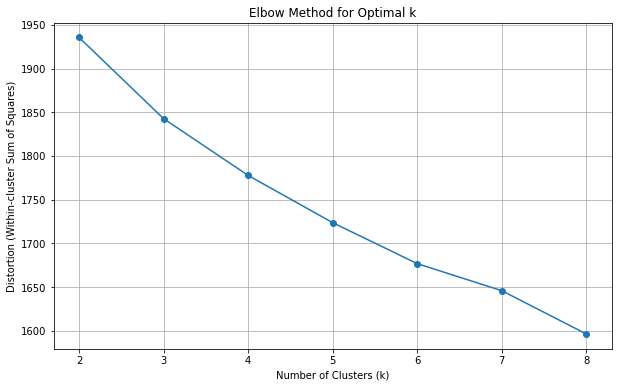

In [41]:
res = kmeans_func (df_design, 8)  

We can see, that graph hasnt typical elbow, Silhouette Score is low. Its may be meaning that this method classification not convinient for this data.
But lets try to make reduction.



PCA Explained Variance: 0.18270143972876413
Number of clusters: 2, Silhouette Score: 0.39, Davies-Bouldin Index: 1.04
Number of clusters: 3, Silhouette Score: 0.41, Davies-Bouldin Index: 0.85
Number of clusters: 4, Silhouette Score: 0.4, Davies-Bouldin Index: 0.82
Number of clusters: 5, Silhouette Score: 0.37, Davies-Bouldin Index: 0.85
Number of clusters: 6, Silhouette Score: 0.38, Davies-Bouldin Index: 0.81
Number of clusters: 7, Silhouette Score: 0.38, Davies-Bouldin Index: 0.81
Number of clusters: 8, Silhouette Score: 0.37, Davies-Bouldin Index: 0.81
Number of clusters: 9, Silhouette Score: 0.36, Davies-Bouldin Index: 0.83
Number of clusters: 10, Silhouette Score: 0.36, Davies-Bouldin Index: 0.82
Number of clusters: 11, Silhouette Score: 0.37, Davies-Bouldin Index: 0.79
Number of clusters: 12, Silhouette Score: 0.36, Davies-Bouldin Index: 0.79


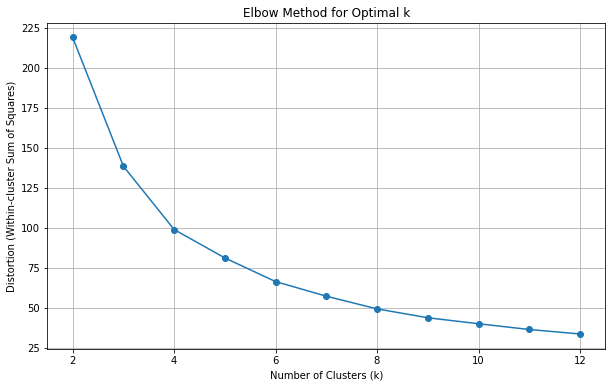

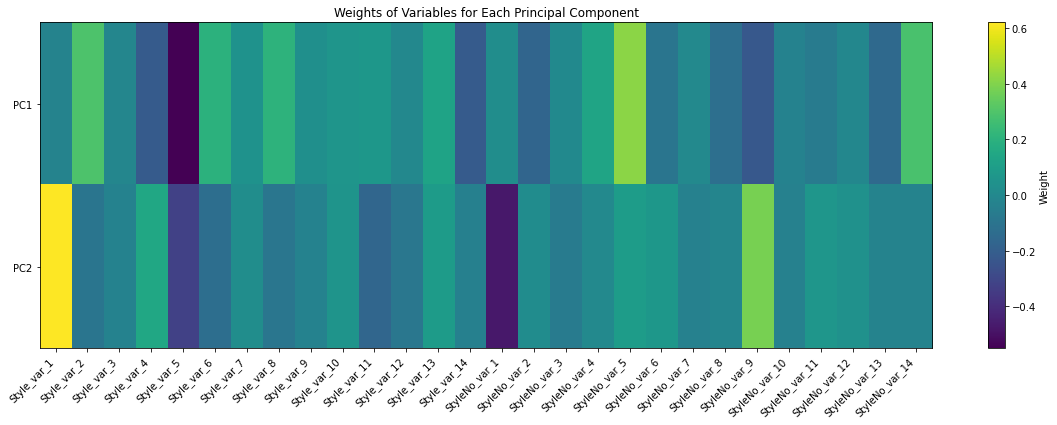

In [178]:
# использую Principal component analysis (PCA) для снижения размерности
# и далее пробую сделать кластеризацию главных компанент

# Преобразование данных в NumPy массив
data = df_design.to_numpy()

# Создание объекта PCA
pca_model = PCA(n_components=2)

# Применение PCA к данным
new_data = pca_model.fit_transform(data)

print(f"PCA Explained Variance: {sum(pca_model.explained_variance_ratio_)}")


#кластерный анализ по главным компонентам

res = kmeans_func (new_data, 12)  

components_weights = pca_model.components_[:, :28]

component_weight (df_design, components_weights, 28)  


**Визуализация главных компонент**
Первая и вторая компоненты. Положительные и отрицательные корреляции

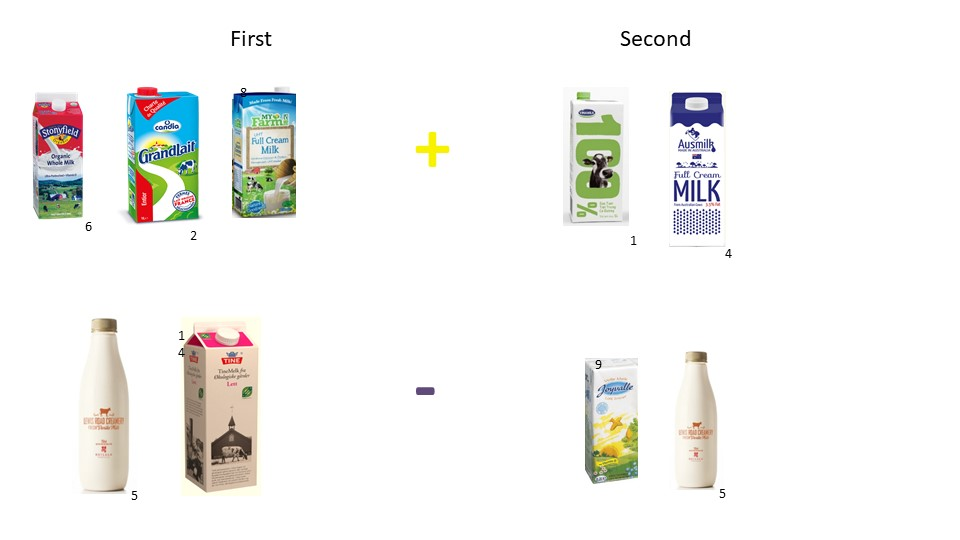

**Анализируем полученные кластеры**

Number of clusters: 2, Silhouette Score: 0.39, Davies-Bouldin Index: 1.04
Number of clusters: 3, Silhouette Score: 0.41, Davies-Bouldin Index: 0.85
Number of clusters: 4, Silhouette Score: 0.4, Davies-Bouldin Index: 0.82


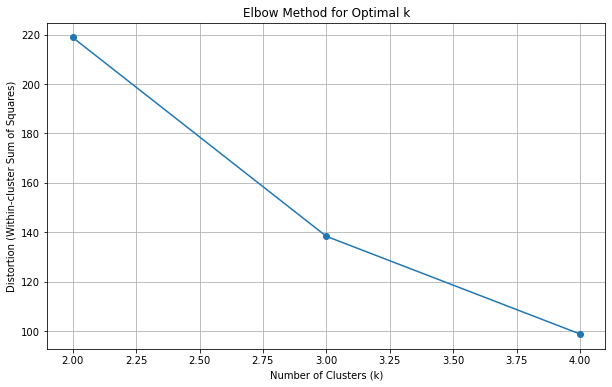

Cluster Table for Group 1:
                     0         1         2         3
Style_var_1   0.736842  0.007576  0.030075  0.317073
Style_var_2   0.150376  0.181818  0.511278  0.032520
Style_var_3   0.075188  0.090909  0.157895  0.154472
Style_var_4   0.323308  0.212121  0.105263  0.414634
Style_var_5   0.045113  0.810606  0.022556  0.910569
Style_var_6   0.127820  0.136364  0.383459  0.048780
Style_var_7   0.135338  0.083333  0.142857  0.065041
Style_var_8   0.127820  0.181818  0.383459  0.016260
Style_var_9   0.015038  0.053030  0.097744  0.024390
Style_var_10  0.240602  0.159091  0.218045  0.113821
Style_var_11  0.075188  0.181818  0.225564  0.065041
Style_var_12  0.225564  0.325758  0.225564  0.154472
Style_var_13  0.278195  0.136364  0.225564  0.065041
Style_var_14  0.127820  0.204545  0.037594  0.349593

Cluster Table for Group 2:
                       0         1         2         3
StyleNo_var_1   0.022556  0.553030  0.300752  0.040650
StyleNo_var_2   0.105263  0.098485  0.02

In [180]:
res = kmeans_func (new_data, 4)  
res_disgn = res
design_components = new_data
create_cluster_tables(df_design, res)

Выявлены группы:
- 0: +5, 12  - 1  - модная графика
- 1: +2,6,8 -1,5,14  - пейзажный стиль
- 2: +1,4,13 -9,5,12,14  - графично и прагматично
- 3: +1,4,5  -2,9,13,12  - лаконично, графично, солидно

Number of clusters: 2, Silhouette Score: 0.36, Davies-Bouldin Index: 1.17
Number of clusters: 3, Silhouette Score: 0.4, Davies-Bouldin Index: 0.83
Number of clusters: 4, Silhouette Score: 0.39, Davies-Bouldin Index: 0.77
Number of clusters: 5, Silhouette Score: 0.37, Davies-Bouldin Index: 0.79
Number of clusters: 6, Silhouette Score: 0.36, Davies-Bouldin Index: 0.83
Number of clusters: 7, Silhouette Score: 0.38, Davies-Bouldin Index: 0.73
Number of clusters: 8, Silhouette Score: 0.37, Davies-Bouldin Index: 0.75
Number of clusters: 9, Silhouette Score: 0.36, Davies-Bouldin Index: 0.78
Number of clusters: 10, Silhouette Score: 0.36, Davies-Bouldin Index: 0.79
Number of clusters: 11, Silhouette Score: 0.35, Davies-Bouldin Index: 0.79
Number of clusters: 12, Silhouette Score: 0.36, Davies-Bouldin Index: 0.8


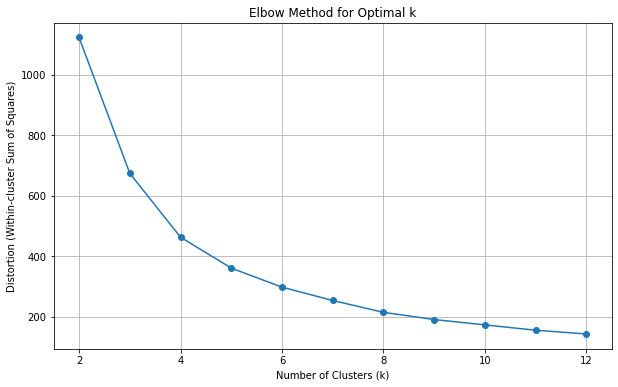

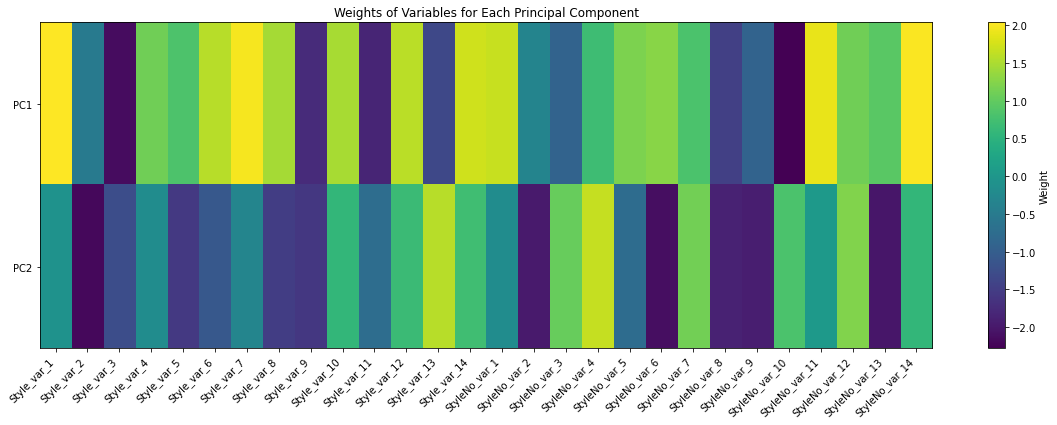

In [44]:
#MDS method for dimentionality reduction 

from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder

# Преобразование бинарных данных в числовые
label_encoder = LabelEncoder()
df_encoded = df_design.apply(label_encoder.fit_transform)

# Инициализация объекта MDS
mds = MDS(n_components=2)  # Указать число компонент

# Применение MDS к данным
mds_result = mds.fit_transform(df_encoded)

# Результат в виде DataFrame
result_df = pd.DataFrame(mds_result, columns=['MDS1', 'MDS2'])

res = kmeans_func (result_df, 12)  

components_weights_mds = mds.embedding_.T  # Транспонировать, чтобы переменные были в строках
components_weights = components_weights_mds[:, :df_encoded.shape[1]]  # Оставить только первые 28 переменных

component_weight(df_design, components_weights, 28) 



**MDS** method show, that too many variables convinient for factors. Clusters results worse, than the same for PCA

first component - preference to variants with landscape, dont like minimalistic variants

second component - preference graphic design, dont like landscape variants


Number of clusters: 2, Silhouette Score: 0.36, Davies-Bouldin Index: 1.17
Number of clusters: 3, Silhouette Score: 0.4, Davies-Bouldin Index: 0.83
Number of clusters: 4, Silhouette Score: 0.39, Davies-Bouldin Index: 0.77
Number of clusters: 5, Silhouette Score: 0.37, Davies-Bouldin Index: 0.79


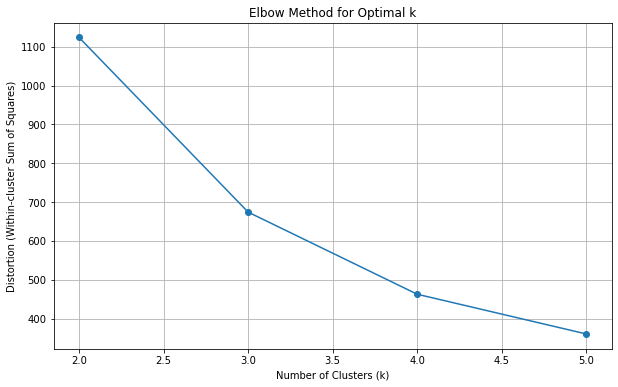

Cluster Table for Group 1:
                     0         1     2         3         4
Style_var_1   0.027273  0.680851  0.74  0.000000  0.009524
Style_var_2   0.200000  0.042553  0.20  0.071429  0.590476
Style_var_3   0.109091  0.117021  0.06  0.142857  0.161905
Style_var_4   0.163636  0.468085  0.22  0.392857  0.076190
Style_var_5   0.627273  0.478723  0.03  0.955357  0.038095
Style_var_6   0.245455  0.042553  0.15  0.071429  0.361905
Style_var_7   0.090909  0.117021  0.15  0.071429  0.114286
Style_var_8   0.227273  0.031915  0.20  0.044643  0.390476
Style_var_9   0.081818  0.010638  0.04  0.026786  0.076190
Style_var_10  0.154545  0.117021  0.26  0.178571  0.209524
Style_var_11  0.209091  0.042553  0.09  0.133929  0.200000
Style_var_12  0.418182  0.191489  0.19  0.125000  0.238095
Style_var_13  0.127273  0.117021  0.35  0.071429  0.238095
Style_var_14  0.109091  0.265957  0.04  0.428571  0.028571

Cluster Table for Group 2:
                       0         1     2         3         4

In [45]:
res = kmeans_func (result_df, 5)    
create_cluster_tables(df_design, res)

Группы:
- 0: +5,4,14 -1,2,13 : графично солидно лаконично
- 1: +1,13 -9,12,14 : вкусно и полезно, выгоды
- 2: +2,6,8,13 -5,14: пейзажи
- 3: +1,5,14 -9,13: как 0
- 4: +5,6,8,12 -1,14: позитивно, броско с коровками 

SVD Explained Variance: 0.11800771393871638
Number of clusters: 2, Silhouette Score: 0.53, Davies-Bouldin Index: 0.66
Number of clusters: 3, Silhouette Score: 0.46, Davies-Bouldin Index: 0.73
Number of clusters: 4, Silhouette Score: 0.4, Davies-Bouldin Index: 0.83
Number of clusters: 5, Silhouette Score: 0.35, Davies-Bouldin Index: 0.92
Number of clusters: 6, Silhouette Score: 0.36, Davies-Bouldin Index: 0.89
Number of clusters: 7, Silhouette Score: 0.35, Davies-Bouldin Index: 0.91
Number of clusters: 8, Silhouette Score: 0.35, Davies-Bouldin Index: 0.88
Number of clusters: 9, Silhouette Score: 0.35, Davies-Bouldin Index: 0.87
Number of clusters: 10, Silhouette Score: 0.35, Davies-Bouldin Index: 0.86
Number of clusters: 11, Silhouette Score: 0.35, Davies-Bouldin Index: 0.84
Number of clusters: 12, Silhouette Score: 0.34, Davies-Bouldin Index: 0.84


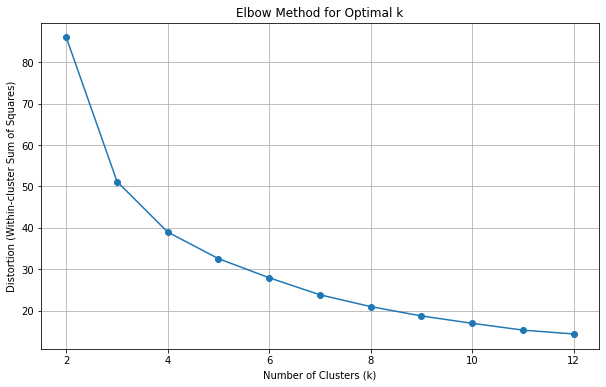

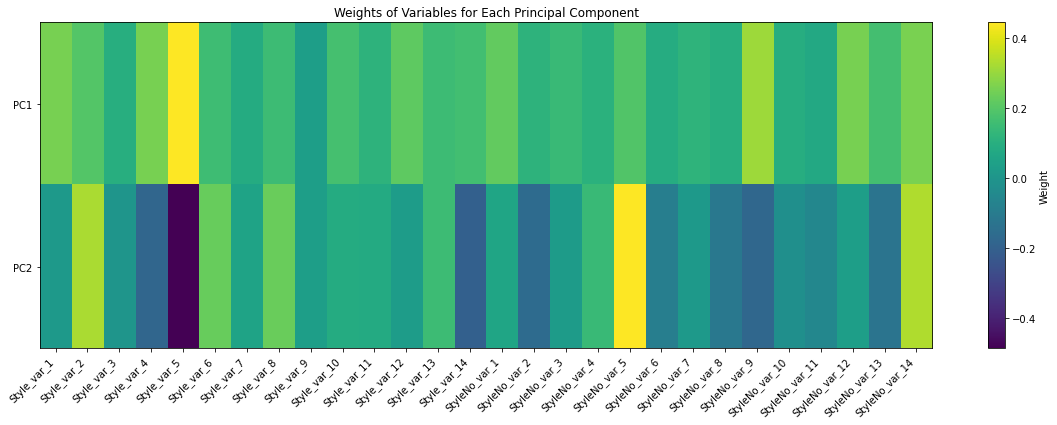

In [46]:
# Инициализация объекта TruncatedSVD с двумя компонентами
num_components = 2
svd = TruncatedSVD(n_components=num_components)

# Применение SVD к оригинальной матрице данных
svd_result = svd.fit_transform(df_design)

# Результат в виде DataFrame с двумя компонентами
components_df = pd.DataFrame(svd_result, columns=['Component1', 'Component2'])

explained_variance = sum(svd.explained_variance_ratio_) 
print(f"SVD Explained Variance: {explained_variance}")


res = kmeans_func (components_df, 12)  

# Получение весов компонент для исходных переменных
components_weights = svd.components_.T

# Результат в виде DataFrame с весами компонент для исходных переменных
weights_df = pd.DataFrame(components_weights, columns=['Weight_Component1', 'Weight_Component2'], index=df_design.columns)

component_weight(df_design, components_weights.T, 28) 


This method shows simple and undestandible results
- Graphic style: like 5, 1, 4, dislike 9,14 both like/dislike 12
- Landscape style: like 2, 6, 8 dislike 5, 14, 4

But: Explained Variance: 0.118. Its low results

Number of clusters: 2, Silhouette Score: 0.53, Davies-Bouldin Index: 0.66
Number of clusters: 3, Silhouette Score: 0.46, Davies-Bouldin Index: 0.73
Number of clusters: 4, Silhouette Score: 0.4, Davies-Bouldin Index: 0.83


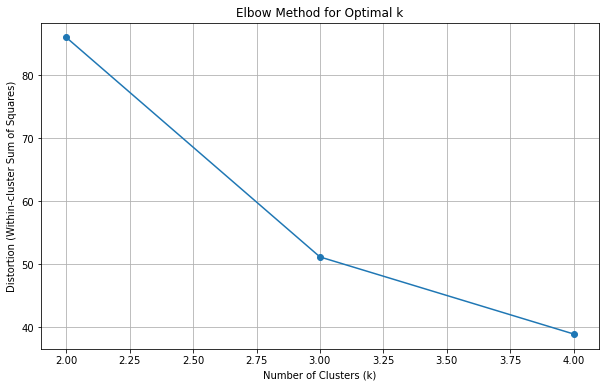

Cluster Table for Group 1:
                     0         1         2         3
Style_var_1   0.364341  0.259494  0.134831  0.289655
Style_var_2   0.271318  0.025316  0.617978  0.151724
Style_var_3   0.124031  0.120253  0.101124  0.124138
Style_var_4   0.178295  0.411392  0.067416  0.289655
Style_var_5   0.062016  0.911392  0.011236  0.517241
Style_var_6   0.217054  0.050633  0.438202  0.117241
Style_var_7   0.186047  0.050633  0.101124  0.103448
Style_var_8   0.232558  0.031646  0.426966  0.144828
Style_var_9   0.069767  0.025316  0.078652  0.034483
Style_var_10  0.193798  0.132911  0.247191  0.193103
Style_var_11  0.162791  0.107595  0.202247  0.110345
Style_var_12  0.240310  0.196203  0.168539  0.310345
Style_var_13  0.240310  0.050633  0.280899  0.200000
Style_var_14  0.077519  0.379747  0.022472  0.137931

Cluster Table for Group 2:
                       0         1         2         3
StyleNo_var_1   0.217054  0.183544  0.235955  0.296552
StyleNo_var_2   0.077519  0.291139  0.00

In [47]:
res = kmeans_func (components_df, 4)    
create_cluster_tables(df_design, res)

Кластеры (SVD reduction):
- 0: +1,2,8,13,12 -5,14: классика: коровы пейзажи, выгода, позитив
- 1: +5,4,14 -9,13,12,2: лаконично и солидно
- 2: +2,6,8 -5,14: пейзажи
- 3: +5,12 -9,14,1: броско 


ОШИБКА??? туТ МЫ ГОВОРИМ ЧТО СВД ЛУЧШЕ, НО ПО КЛАСТЕРАМ ОНИ ОДИНАКОВЫЕ

Lets compare three metods
- PCA. Explained Variance:0.18  Silhouette Score: 0.41 (2cl) character groups - middle
- MDS. Explained Variance:n/a  Silhouette Score: 0.39 (2cl) character groups - middle
- SVD. Explained Variance: 0.12 Silhouette Score: 0.45 (2cl) character groups - good

All methods have low Explained Variance. SVD better for Silhouette Score and character groups

**We can check SVD for 14 (only like variables)** - may be same criteria make a noise.



Выявлены группы (PCA reduction):
- 0: +5, 12  - 1  - модная графика
- 1: +2,6,8 -1,5,14  - пейзажный стиль
- 2: +1,4,13 -9,5,12,14  - графично и прагматично
- 3: +1,4,5  -2,9,13,12  - лаконично, графично, солидно

Группы (MDS reduction):

- 0: +5,4,14 -1,2,13 : графично солидно лаконично
- 1: +1,13 -9,12,14 : вкусно и полезно, выгоды
- 2: +2,6,8,13 -5,14: пейзажи
- 3: +1,5,14 -9,13: как 0
- 4: +5,6,8,12 -1,14: позитивно, броско с коровками


Кластеры (SVD reduction):
- 0: +1,2,8,13,12 -5,14: классика: коровы пейзажи, выгода, позитив
- 1: +5,4,14 -9,13,12,2: лаконично и солидно
- 2: +2,6,8 -5,14: пейзажи
- 3: +5,12 -9,14,1: броско 

Кластеры положи.
Вот возможные соответствия одних кластеров другим:

- 0 - 0\3 - 1
- 1 - 2 - 2
- 3 - 0 - 1
- 2 - 1 - -
- 1  - 4 - 3 

In [48]:
df_design_14 = df[['Style_var_1', 'Style_var_2', 'Style_var_3', 'Style_var_4', 'Style_var_5', 
        'Style_var_6', 'Style_var_7', 'Style_var_8', 'Style_var_9', 'Style_var_10',
        'Style_var_11', 'Style_var_12', 'Style_var_13', 'Style_var_14']]

SVD Explained Variance: 0.28527928208299214
Number of clusters: 2, Silhouette Score: 0.4, Davies-Bouldin Index: 1.07
Number of clusters: 3, Silhouette Score: 0.43, Davies-Bouldin Index: 0.83
Number of clusters: 4, Silhouette Score: 0.43, Davies-Bouldin Index: 0.84
Number of clusters: 5, Silhouette Score: 0.39, Davies-Bouldin Index: 1.02
Number of clusters: 6, Silhouette Score: 0.39, Davies-Bouldin Index: 0.91
Number of clusters: 7, Silhouette Score: 0.4, Davies-Bouldin Index: 0.87
Number of clusters: 8, Silhouette Score: 0.4, Davies-Bouldin Index: 0.83
Number of clusters: 9, Silhouette Score: 0.42, Davies-Bouldin Index: 0.84
Number of clusters: 10, Silhouette Score: 0.41, Davies-Bouldin Index: 0.85
Number of clusters: 11, Silhouette Score: 0.41, Davies-Bouldin Index: 0.88
Number of clusters: 12, Silhouette Score: 0.41, Davies-Bouldin Index: 0.91


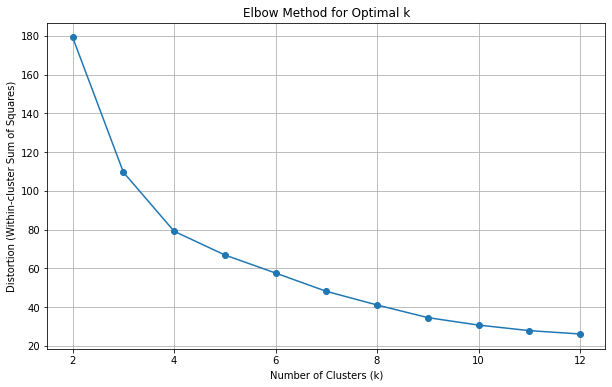

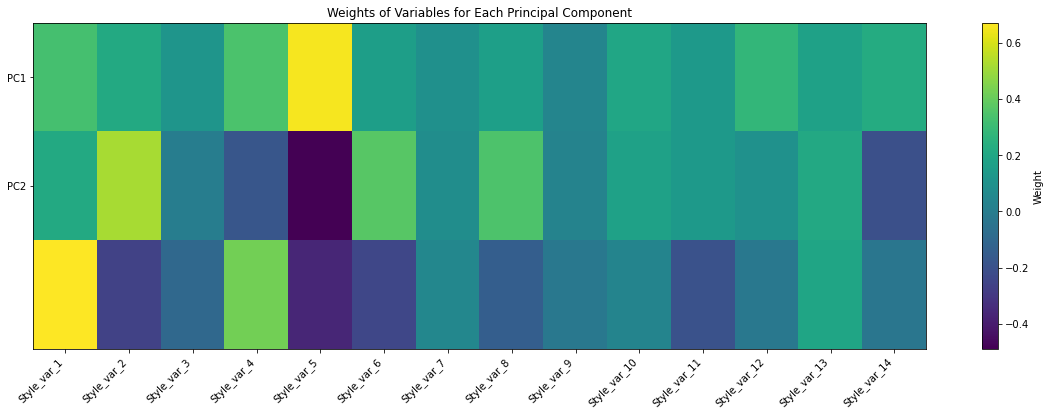

In [49]:
num_components = 3
svd = TruncatedSVD(n_components=num_components)

# Применение SVD к оригинальной матрице данных
svd_result = svd.fit_transform(df_design_14)

# Результат в виде DataFrame с двумя компонентами
#components_df = pd.DataFrame(svd_result, columns=['Component1', 'Component2','Component3', 'Component4'])
#components_df = pd.DataFrame(svd_result, columns=['Component1', 'Component2'])
components_df = pd.DataFrame(svd_result, columns=['Component1', 'Component2','Component3'])

explained_variance = sum(svd.explained_variance_ratio_) 
print(f"SVD Explained Variance: {explained_variance}")


res = kmeans_func (components_df, 12)  

# Получение весов компонент для исходных переменных
components_weights = svd.components_.T

# Результат в виде DataFrame с весами компонент для исходных переменных
#weights_df = pd.DataFrame(components_weights, columns=['Weight_Component1', 'Weight_Component2','Weight_Component3', 'Weight_Component4'], index=df_design_14.columns)
#weights_df = pd.DataFrame(components_weights, columns=['Weight_Component1', 'Weight_Component2'], index=df_design_14.columns)
weights_df = pd.DataFrame(components_weights, columns=['Weight_Component1', 'Weight_Component2','Weight_Component3'], index=df_design_14.columns)

component_weight(df_design, components_weights.T, 14) 

In [50]:
column_names = ['Grapfic_5', 'Landscape', 'Graphic_wo_5']


# Создание нового DataFrame с теми же данными из components_df, но с новыми заголовками
df_design_data = pd.DataFrame(components_df.values, columns=column_names)



In [51]:
print(df_design_data)

     Grapfic_5  Landscape  Graphic_wo_5
0     1.101874  -0.269336      0.213730
1     0.567509   0.421304      0.682561
2     0.478780   0.945043     -0.353456
3     1.267063  -0.172338      0.284821
4     0.807932   0.491609      0.682497
..         ...        ...           ...
516   0.681912  -0.382660      0.293924
517   0.350724   0.656347     -0.456562
518   0.733818  -0.038346      0.245865
519   0.459896   0.562494     -0.045428
520   0.658330   0.989873     -0.525964

[521 rows x 3 columns]




This method has optimal decigion for 3 components.
Types of components:
- Grapfic design include 5 ( 5, 1, 4)
- Landscape design (2, 6, 8)
- Graphic design exclude 5 (1, 4, 13)

**Its better. But Explained Variance hasnt hi value**

ОШИБКА??? ИСПОЛЬЗУЮТСЯ ГЛАВНЫЕ КОМПОНЕНТЫ В КАЧЕСТВЕ ПЕРЕМЕННЫХ

PCA Explained Variance: 0.2697196646294842
Number of clusters: 2, Silhouette Score: 0.44, Davies-Bouldin Index: 0.97
Number of clusters: 3, Silhouette Score: 0.48, Davies-Bouldin Index: 0.74
Number of clusters: 4, Silhouette Score: 0.49, Davies-Bouldin Index: 0.71
Number of clusters: 5, Silhouette Score: 0.46, Davies-Bouldin Index: 0.85
Number of clusters: 6, Silhouette Score: 0.44, Davies-Bouldin Index: 0.82
Number of clusters: 7, Silhouette Score: 0.45, Davies-Bouldin Index: 0.8
Number of clusters: 8, Silhouette Score: 0.44, Davies-Bouldin Index: 0.72
Number of clusters: 9, Silhouette Score: 0.47, Davies-Bouldin Index: 0.72
Number of clusters: 10, Silhouette Score: 0.47, Davies-Bouldin Index: 0.73
Number of clusters: 11, Silhouette Score: 0.48, Davies-Bouldin Index: 0.68
Number of clusters: 12, Silhouette Score: 0.48, Davies-Bouldin Index: 0.75


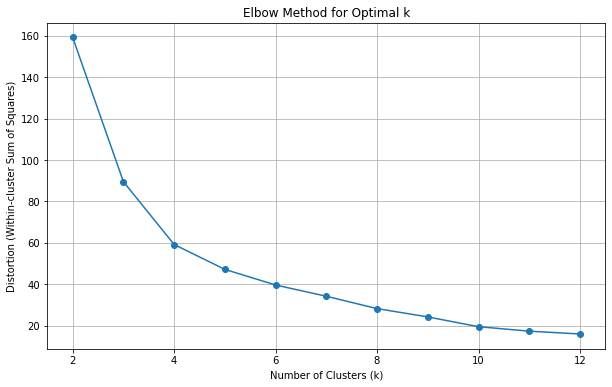

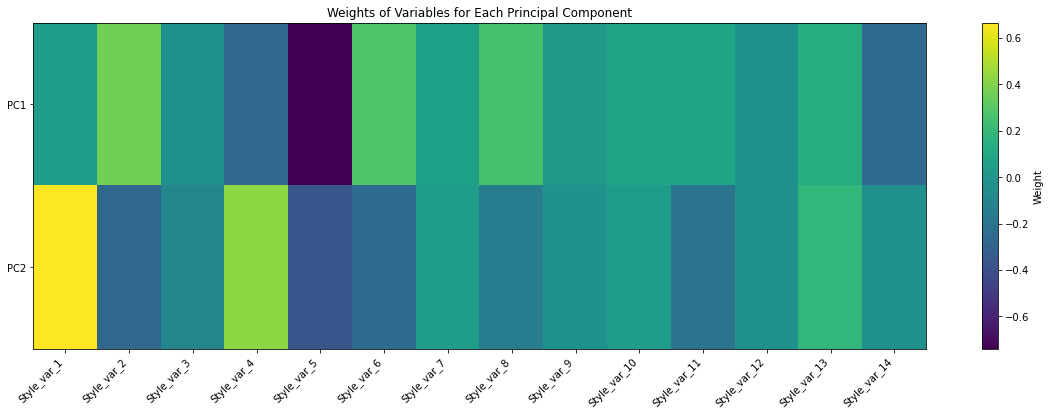

In [52]:
# Преобразование данных в NumPy массив
data = df_design_14.to_numpy()

# Создание объекта PCA
pca_model = PCA(n_components=2)

# Применение PCA к данным
new_data = pca_model.fit_transform(data)

print(f"PCA Explained Variance: {sum(pca_model.explained_variance_ratio_)}")

res = kmeans_func (new_data, 12)  

components_weights = pca_model.components_[:, :14]

component_weight (df_design, components_weights, 14)  

PCA method for 14 variables has highest Explained Variance: 0.269 but we cannot get it as good results


**RESULTS FOR REDUCTION DESIGN PREFERENCES**

No one methods dont give us a good results

In general analysis we can use:
- Full data
- Short data (6 most popular variables with level answers more 25%). See below
- Use highest positive variables (5 vars)
- Use results of SVD method as best of all



In [53]:
df_design_6 = df[['Style_var_1', 'Style_var_4', 'Style_var_5', 
        'StyleNo_var_9', 'StyleNo_var_12', 'StyleNo_var_14']]
df_design_6.head()

Style_var_1  Style_var_4  Style_var_5  StyleNo_var_9  StyleNo_var_12  \
0            1            0            1              1               1   
1            1            0            0              0               0   
2            0            0            0              0               0   
3            1            0            1              1               0   
4            1            0            0              1               0   

   StyleNo_var_14  
0               0  
1               0  
2               0  
3               0  
4               0

In [54]:
df_design_5 = df[['Style_var_1', 'Style_var_2', 'Style_var_4', 'Style_var_5', 
                  'Style_var_6']]

##### 4.1.2 Reduction for product (try_) preferences

In [55]:
df_try = df[['try_hero', 'try_ecology', 'try_price', 'try_pack', 'try_ads', 
        'try_advise', 'try_recipe', 'try_color', 'try_name', 'try_eyesstop',
        'try_quality', 'try_brand', 'try_expencive', 'try_foodzone', 
        'try_design', 'try_solid', 'rty_nothing']]
df_try.head()

try_hero  try_ecology  try_price  try_pack  try_ads  try_advise  \
0         0            1          0         0        0           0   
1         0            0          1         0        0           1   
2         0            0          1         0        0           1   
3         0            0          1         0        0           1   
4         0            1          0         1        1           0   

   try_recipe  try_color  try_name  try_eyesstop  try_quality  try_brand  \
0           0          0         0             1            1          0   
1           1          0         0             0            0          0   
2           0          0         0             0            0          0   
3           0          0         0             0            0          1   
4           0          0         0             0            0          0   

   try_expencive  try_foodzone  try_design  try_solid  rty_nothing  
0              0             0           0          0            0  
1              0             0           0          0            0  
2              0             0           0          1            0  
3              0             0           0          0            0  
4              0             0           0          0            0

PCA Explained Variance: 0.31699022370467356
Number of clusters: 2, Silhouette Score: 0.45, Davies-Bouldin Index: 1.0
Number of clusters: 3, Silhouette Score: 0.49, Davies-Bouldin Index: 0.81
Number of clusters: 4, Silhouette Score: 0.57, Davies-Bouldin Index: 0.63
Number of clusters: 5, Silhouette Score: 0.56, Davies-Bouldin Index: 0.61
Number of clusters: 6, Silhouette Score: 0.6, Davies-Bouldin Index: 0.58
Number of clusters: 7, Silhouette Score: 0.62, Davies-Bouldin Index: 0.54
Number of clusters: 8, Silhouette Score: 0.65, Davies-Bouldin Index: 0.54
Number of clusters: 9, Silhouette Score: 0.66, Davies-Bouldin Index: 0.55
Number of clusters: 10, Silhouette Score: 0.67, Davies-Bouldin Index: 0.53
Number of clusters: 11, Silhouette Score: 0.68, Davies-Bouldin Index: 0.57
Number of clusters: 12, Silhouette Score: 0.68, Davies-Bouldin Index: 0.51


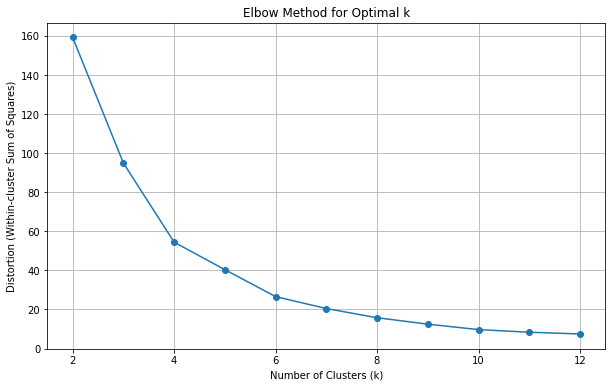

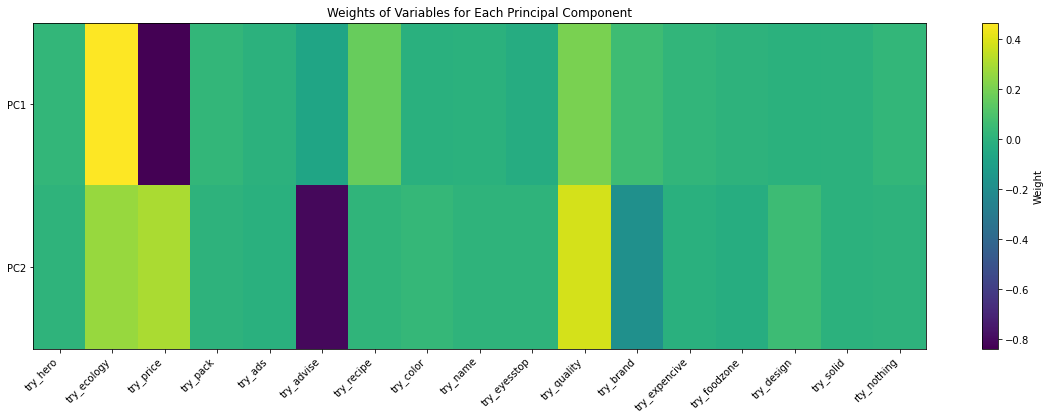

In [181]:
#PCA method

data = df_try.to_numpy()

# Создание объекта PCA
pca_model = PCA(n_components=2)

# Применение PCA к данным
new_data = pca_model.fit_transform(data)

print(f"PCA Explained Variance: {sum(pca_model.explained_variance_ratio_)}")

res = kmeans_func (new_data, 12)  

components_weights = pca_model.components_[:, :17]

component_weight (df_try, components_weights, 17) 

Number of clusters: 2, Silhouette Score: 0.45, Davies-Bouldin Index: 1.0
Number of clusters: 3, Silhouette Score: 0.49, Davies-Bouldin Index: 0.81


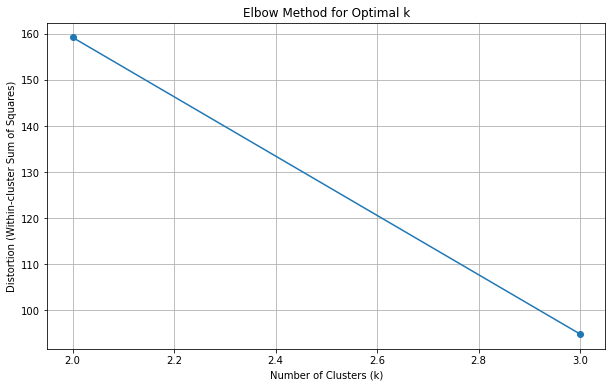

In [182]:
res = kmeans_func (new_data, 3)  

#создаю переменную для дальнейшего анализа корреляций
res_try = res
try_components = new_data

In [58]:
clusters_describe_func (res) 

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0        157.000000         14.440127         1038.853503          2104.140127
1        182.000000         13.410440         1084.340659          2128.296703
2        182.000000         13.967582         1019.505495          2171.428571
average  173.666667         13.939383         1047.566552          2134.621801


In [59]:
create_cluster_tables( df_try, res)

Cluster Table for Group 1:
                      0         1         2
try_hero       0.012739  0.043956  0.010989
try_ecology    0.095541  0.483516  0.203297
try_price      0.528662  0.000000  1.000000
try_pack       0.031847  0.065934  0.032967
try_ads        0.082803  0.093407  0.049451
try_advise     1.000000  0.214286  0.076923
try_recipe     0.121019  0.219780  0.104396
try_color      0.000000  0.016484  0.032967
try_name       0.012739  0.027473  0.021978
try_eyesstop   0.070064  0.126374  0.104396
try_quality    0.031847  0.318681  0.324176
try_brand      0.299363  0.258242  0.219780
try_expencive  0.012739  0.032967  0.000000
try_foodzone   0.070064  0.087912  0.054945

Cluster Table for Group 2:
                    0         1         2
try_design   0.019108  0.098901  0.087912
try_solid    0.121019  0.142857  0.109890
rty_nothing  0.000000  0.076923  0.000000

Cluster Table for Group 3:
Empty DataFrame
Columns: [0, 1, 2]
Index: []



This two types of consumers based on Components:
- Branding - loyality. Prefer: ecology, reciepe, quality, brand, advise
- Price-loyality. Prefer: price, quality,


3 types based on claster analysis:
- 0: слушают советы и, если можно, недорого
- 1: за правильный продукт (эко, качество, доверие бренду)
- 2: только цена и, если можно, еще и качество

Number of clusters: 2, Silhouette Score: 0.37, Davies-Bouldin Index: 1.17
Number of clusters: 3, Silhouette Score: 0.42, Davies-Bouldin Index: 0.83
Number of clusters: 4, Silhouette Score: 0.41, Davies-Bouldin Index: 0.82
Number of clusters: 5, Silhouette Score: 0.4, Davies-Bouldin Index: 0.83
Number of clusters: 6, Silhouette Score: 0.38, Davies-Bouldin Index: 0.9
Number of clusters: 7, Silhouette Score: 0.41, Davies-Bouldin Index: 0.83
Number of clusters: 8, Silhouette Score: 0.41, Davies-Bouldin Index: 0.83
Number of clusters: 9, Silhouette Score: 0.42, Davies-Bouldin Index: 0.81
Number of clusters: 10, Silhouette Score: 0.45, Davies-Bouldin Index: 0.8
Number of clusters: 11, Silhouette Score: 0.44, Davies-Bouldin Index: 0.7
Number of clusters: 12, Silhouette Score: 0.48, Davies-Bouldin Index: 0.72


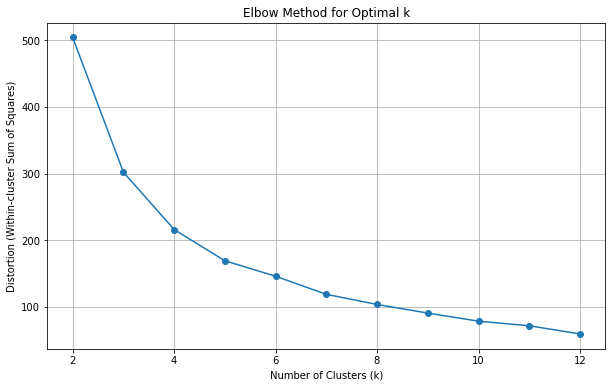

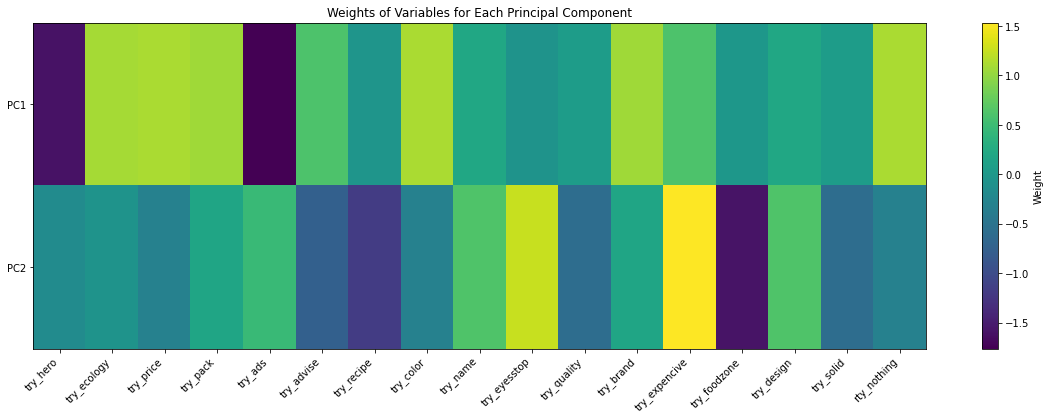

In [60]:
#MDS method

# Преобразование бинарных данных в числовые
label_encoder = LabelEncoder()
df_encoded = df_try.apply(label_encoder.fit_transform)

# Инициализация объекта MDS
mds = MDS(n_components=2)  # Указать число компонент

# Применение MDS к данным
mds_result = mds.fit_transform(df_encoded)

# Результат в виде DataFrame
result_df = pd.DataFrame(mds_result, columns=['MDS1', 'MDS2'])

res = kmeans_func (result_df, 12)  

components_weights_mds = mds.embedding_.T  # Транспонировать, чтобы переменные были в строках
components_weights = components_weights_mds[:, :df_encoded.shape[1]]  # Оставить только первые 28 переменных

component_weight(df_try, components_weights, 17) 

MDS method:
    
    Silhouette Score less than PCA methods
    Groups:
        - Eyestopping group
        - Traditional branding group
        

SVD Explained Variance: 0.24450021528526913
Number of clusters: 2, Silhouette Score: 0.46, Davies-Bouldin Index: 0.94
Number of clusters: 3, Silhouette Score: 0.49, Davies-Bouldin Index: 0.7
Number of clusters: 4, Silhouette Score: 0.59, Davies-Bouldin Index: 0.55
Number of clusters: 5, Silhouette Score: 0.55, Davies-Bouldin Index: 0.67
Number of clusters: 6, Silhouette Score: 0.53, Davies-Bouldin Index: 0.75
Number of clusters: 7, Silhouette Score: 0.5, Davies-Bouldin Index: 0.81
Number of clusters: 8, Silhouette Score: 0.52, Davies-Bouldin Index: 0.71
Number of clusters: 9, Silhouette Score: 0.53, Davies-Bouldin Index: 0.75
Number of clusters: 10, Silhouette Score: 0.56, Davies-Bouldin Index: 0.71
Number of clusters: 11, Silhouette Score: 0.54, Davies-Bouldin Index: 0.68
Number of clusters: 12, Silhouette Score: 0.54, Davies-Bouldin Index: 0.68


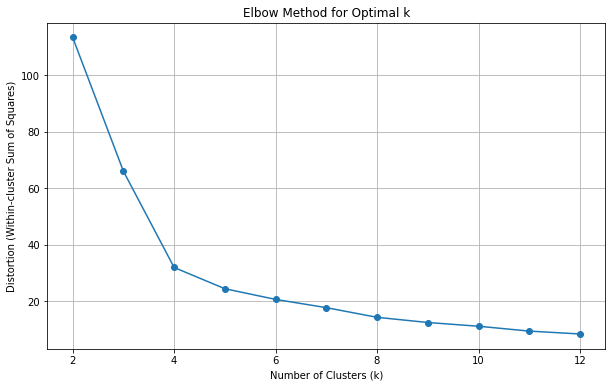

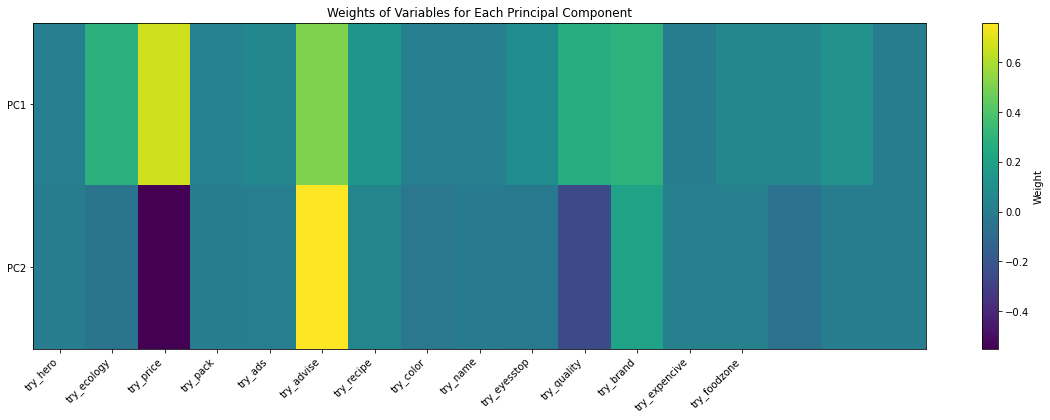

In [61]:
#TruncatedSVD method

num_components = 2
svd = TruncatedSVD(n_components=num_components)

# Применение SVD к оригинальной матрице данных
svd_result = svd.fit_transform(df_try)

# Результат в виде DataFrame с двумя компонентами
components_df = pd.DataFrame(svd_result, columns=['Component1', 'Component2'])

explained_variance = sum(svd.explained_variance_ratio_) 
print(f"SVD Explained Variance: {explained_variance}")


res = kmeans_func (components_df, 12)  

# Получение весов компонент для исходных переменных
components_weights = svd.components_.T

# Результат в виде DataFrame с весами компонент для исходных переменных
weights_df = pd.DataFrame(components_weights, columns=['Weight_Component1', 'Weight_Component2'], 
                          index=df_try.columns)

component_weight(df_try, components_weights.T, 14) 

SVG method has less results

groups not clear

PCA Explained Variance: 0.6348874214842014
Number of clusters: 2, Silhouette Score: 0.26, Davies-Bouldin Index: 1.73
Number of clusters: 3, Silhouette Score: 0.28, Davies-Bouldin Index: 1.54
Number of clusters: 4, Silhouette Score: 0.28, Davies-Bouldin Index: 1.26
Number of clusters: 5, Silhouette Score: 0.35, Davies-Bouldin Index: 1.24
Number of clusters: 6, Silhouette Score: 0.37, Davies-Bouldin Index: 1.14
Number of clusters: 7, Silhouette Score: 0.39, Davies-Bouldin Index: 1.07
Number of clusters: 8, Silhouette Score: 0.42, Davies-Bouldin Index: 1.06
Number of clusters: 9, Silhouette Score: 0.46, Davies-Bouldin Index: 0.99


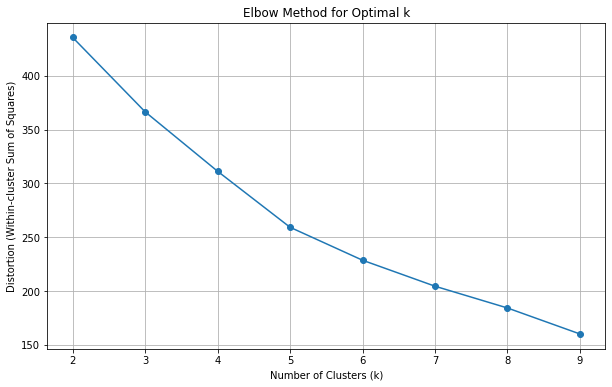

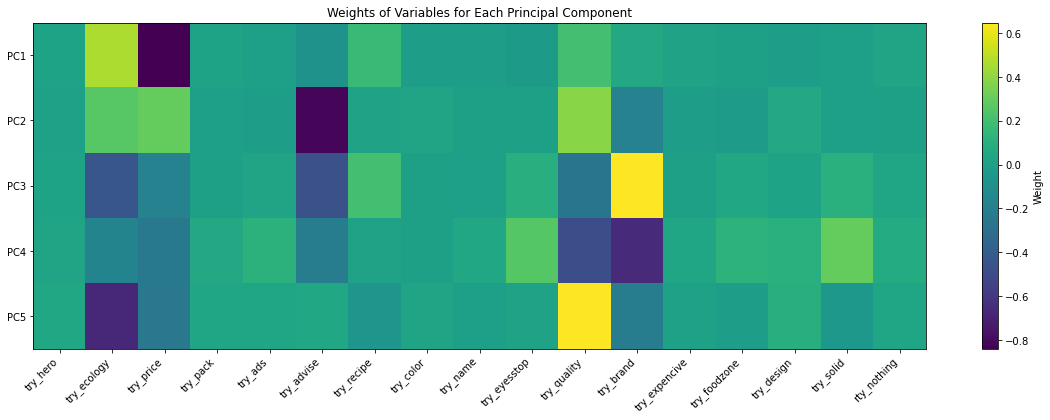

In [62]:
#PCA method

data = df_try.to_numpy()

# Создание объекта PCA
pca_model = PCA(n_components=5)

# Применение PCA к данным
new_data = pca_model.fit_transform(data)

print(f"PCA Explained Variance: {sum(pca_model.explained_variance_ratio_)}")

res = kmeans_func (new_data, 9)  

components_weights = pca_model.components_[:, :17]

component_weight (df_try, components_weights, 17) 

ОШИБКА??? Я ПИШУ ПРО ХОРОШИЕ РЕЗУЛЬТАТЫ, А ОНИ ХУЖЕ ЧЕМ У PCA(2 COMP) 

In [63]:
#Метод показал хорошие результаты. Создаю новые переменные со смысловыми названиями.

column_names = ['Eco_fans', 'Price', 'Brand_lovers', 'By_mood', 'Quality_only']  # Замените на свои названия

# Преобразование массива в датафрейм
df_new_data = pd.DataFrame(new_data, columns=column_names)

print(df_new_data)

     Eco_fans     Price  Brand_lovers   By_mood  Quality_only
0    0.882801  0.709490     -0.368646  0.038806      0.182215
1   -0.507566 -0.440833     -0.214780  0.003337     -0.060295
2   -0.666774 -0.458065     -0.318090  0.280949     -0.050353
3   -0.608029 -0.638186      0.223027 -0.671870     -0.220114
4    0.734870  0.308803     -0.169194  0.443408     -0.414331
..        ...       ...           ...       ...           ...
516 -0.544535  0.203682      0.698336 -0.450386     -0.244432
517  0.508047  0.256475      0.617578 -0.699157      0.617145
518 -0.593431  0.355773      0.051622  0.199551     -0.059074
519 -0.593431  0.355773      0.051622  0.199551     -0.059074
520 -0.667830 -0.455647     -0.419947 -0.016641     -0.004513

[521 rows x 5 columns]


Segments specific:
- eco fans have money
- price and all goods
- Brand lovers
- By mood. Solid, eyestoppers, ads, foodzone
- Only quality


PCA with 5 components has a good results. And we can **use it for general cluster analysis**



##### Check korrelation for design and try_ components 

In [64]:
# Функция для расчета корреляции и ее значимости
def correlation_significance(df1, df2):
    correlations = {}
    p_values = {}

    for column1 in df1.columns:
        for column2 in df2.columns:
            correlation, p_value = pearsonr(df1[column1], df2[column2])
            correlations[f'{column1}_{column2}'] = correlation
            p_values[f'{column1}_{column2}'] = p_value

    return correlations, p_values

# Рассчитываем корреляции и их значимости
correlations, p_values = correlation_significance(df_design_data, df_new_data)

# Создаем датафреймы из результатов
correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['P-Value'])

# Объединяем датафреймы с корреляциями и значимостью
result_df = pd.concat([correlations_df, p_values_df], axis=1)

# Выводим результат
print(result_df)


                           Correlation   P-Value
Grapfic_5_Eco_fans            0.041801  0.340966
Grapfic_5_Price              -0.077550  0.076975
Grapfic_5_Brand_lovers       -0.079491  0.069843
Grapfic_5_By_mood            -0.037974  0.387041
Grapfic_5_Quality_only       -0.049773  0.256763
Landscape_Eco_fans           -0.078828  0.072215
Landscape_Price               0.043480  0.321910
Landscape_Brand_lovers        0.065831  0.133450
Landscape_By_mood             0.014566  0.740120
Landscape_Quality_only        0.086851  0.047546
Graphic_wo_5_Eco_fans         0.002007  0.963546
Graphic_wo_5_Price            0.043842  0.317896
Graphic_wo_5_Brand_lovers    -0.016315  0.710246
Graphic_wo_5_By_mood          0.011436  0.794537
Graphic_wo_5_Quality_only    -0.058693  0.181016


No correlation

#### 4.2 Preparing data for main cluster analysis

- Collect variables
- Make OHE transform
- Make StandardScaler for nessecary


- +Region - 3 – we can develop merchandizing by regions
- +how_to_shopping - 5 -we can chouce types of shop
- +price-opinion - 4
- +buy_novelty - 5
- +buying_criteria_milk - 6 – only one cause hi correlation. Milk most - volume of sales
- +try_ - 16 variants
- +One_brand_different_goods - 3
- +How_choose_brand – 5
- +Sales_preference - 5
- Style_var_notbuy / Style_var_buy - 14 + 14 vars
- +Eco_products_opinion - 6

In [98]:
#функция для описания кластеров по списку переменных

def create_cluster_frequency_tables(df, res):

    cl = pd.DataFrame({'Cluster': res})
    df_c = pd.concat([df, cl], axis=1)

    columns_to_drop = ['Number', 'id', 'birth_day', 'birth_month', 'birth_year']
    columns_to_drop_existing = [col for col in columns_to_drop if col in df_c.columns]

    if columns_to_drop_existing:
        df_c = df_c.drop(columns_to_drop_existing, axis=1)
    
    #df_c = df_c.drop(['Number', 'id', 'birth_day', 'birth_month', 'birth_year'], axis=1)

    mean_vars = ('how_old', 'youngest_year', 'youngest_month')

    try_preference_vars = ('try_hero', 'try_ecology', 'try_price', 'try_pack', 'try_ads', 
    'try_advise', 'try_recipe', 'try_color', 'try_name', 'try_eyesstop',
    'try_quality', 'try_brand', 'try_expencive', 'try_foodzone', 
    'try_design', 'try_solid', 'rty_nothing')

    for column in df_c.columns:
        
        if column in mean_vars:
            continue
            
        elif column in try_preference_vars:     

             continue
    
      
        else:
            # Группируем по переменной и кластеру, затем считаем частоту и преобразуем в проценты
            freq_table = df_c.groupby([column, 'Cluster']).size().unstack()
            freq_table_percentage = freq_table.div(freq_table.sum(axis=0), axis=1) * 100
            freq_table_percentage = freq_table_percentage.round(1)  # Округляем до 1 знака после запятой

            freq_table_percentage['R_Mean'] = freq_table_percentage.mean(axis=1).round(1)

           
            # Добавляем результаты в текстовое поле
            print(f"Variable: {column}\n")
            print(f"Frequency Table:\n{freq_table_percentage}\n\n")
    
    return None

In [66]:
#преобразование категориальных переменных в бинарные

#all this variables has only one variant of answer

columns_for_ohe = df[['city', 'how_to_shopping', 'price-opinion', 'buy_novelty', 'buying_criteria_milk', 
                               'One_brand_different_goods', 'How_choose_brand', 'Sales_preference', 'Eco_products_opinion']]

df_cluster = pd.get_dummies(columns_for_ohe, prefix=['city', 'how_to_shopping', 'price-opinion', 'buy_novelty', 'buying_criteria_milk', 
                               'One_brand_different_goods', 'Sales_preference', 'How_choose_brand', 'Eco_products_opinion'], drop_first=True)



df_cluster.head()

city_Moscow  city_S_Peterburg  how_to_shopping_once_month  \
0            1                 0                           0   
1            1                 0                           0   
2            0                 0                           0   
3            0                 0                           0   
4            0                 1                           0   

   how_to_shopping_once_week_only  how_to_shopping_once_week_plus  \
0                               0                               1   
1                               1                               0   
2                               0                               0   
3                               0                               1   
4                               0                               1   

   how_to_shopping_twice_week  price-opinion_Check_price_new_goods  \
0                           0                                    1   
1                           0                                    0   
2                           1                                    0   
3                           0                                    0   
4                           0                                    1   

   price-opinion_Check_price_sometimes  price-opinion_Dont_check_price  \
0                                    0                               0   
1                                    1                               0   
2                                    1                               0   
3                                    1                               0   
4                                    0                               0   

   buy_novelty_Buy_new_interest  ...  Sales_preference_village  \
0                             0  ...                         0   
1                             0  ...                         0   
2                             0  ...                         0   
3                             1  ...                         0   
4                             1  ...                         0   

   How_choose_brand_buy_any_discount_brand  How_choose_brand_buy_known_brand  \
0                                        1                                 0   
1                                        1                                 0   
2                                        0                                 1   
3                                        0                                 1   
4                                        0                                 0   

   How_choose_brand_buy_lovely_brand  How_choose_brand_buy_only_known_brand  \
0                                  0                                      0   
1                                  0                                      0   
2                                  0                                      0   
3                                  0                                      0   
4                                  1                                      0   

   Eco_products_opinion_Better_buy  Eco_products_opinion_Better_dont_buy  \
0                                0                                     0   
1                                0                                     1   
2                                0                                     0   
3                                0                                     0   
4                                0                                     1   

   Eco_products_opinion_Better_rare  Eco_products_opinion_Fake  \
0                                 1                          0   
1                                 0                          0   
2                                 1                          0   
3                                 0                          1   
4                                 0                          0   

   Eco_products_opinion_Same  
0                          0  
1                          0  
2                          0  
3     

In [67]:
# собираю варианты датафреймов: основные переменные + по оценке дизайнов

#после нормализации + главные компоненты по группе переменных try_
df_cluster = pd.concat([df_cluster, df_new_data], axis=1) # основные критерии + факторы из try_ w|o design

#добавляются различные варианты переменных про выбор дизайнов (6 и 5 переменных, все 14 и 
# главные компоненты по дизайну - 3 переменных)
df_cluster_6 = pd.concat([df_cluster, df[['Style_var_1', 'Style_var_4', 'Style_var_5', 
                                          'StyleNo_var_9', 'StyleNo_var_12', 'StyleNo_var_14']]], axis=1)

df_cluster_5  = pd.concat([df_cluster, df[['Style_var_1', 'Style_var_2','Style_var_4', 
                                           'Style_var_5', 'Style_var_6']]], axis=1)

df_cluster_14 = pd.concat([df_cluster, df_design_14], axis=1)

df_cluster_T = pd.concat([df_cluster, df_design_data], axis=1) #+ factors of design



#### Data ready for claster analysis

We have 3 types data. Differences in design preferences data:
- With 6 most popular variables
- With all 14 positive variables
- With 3 components after TrancatedSVD method


#### 4.3 Cluster analysis

##### 4.3.1 K-means method

In [68]:
# k-means для различных датафреймов. Какой лучше кластеризируется


# Список датафреймов и их названий
datasets = [(df_cluster_6, 'df_cluster_6'), (df_cluster_5, 'df_cluster_5'), (df_cluster_14, 'df_cluster_14'), 
            (df_cluster_T, 'df_cluster_T')]

print("Number of clusters: 10")

for m, dataset_name in datasets:
    model = KMeans(n_clusters=10, init='k-means++', random_state=12345)
    model.fit(m)
    
    # distortion вычисляется с использованием inertia_
    dis = model.inertia_ 
    dis = round(dis, 3)
    kmeans_labels = model.predict(m)
    
    silhouette_avg = silhouette_score(m, kmeans_labels)
    
        #silhouette_score
    silhouette_avg = round(silhouette_avg, 3)

    # Davies-Bouldin Index
    davies_bouldin_idx = davies_bouldin_score(m, kmeans_labels)
    davies_bouldin_idx= round(davies_bouldin_idx, 3)
    print(f"Number of clusters: {10} Silhouette Score: {silhouette_avg}, Davies-Bouldin Index: {davies_bouldin_idx}, Distortion: {dis}")
    
    



Number of clusters: 10
Number of clusters: 10 Silhouette Score: 0.039, Davies-Bouldin Index: 3.336, Distortion: 3217.433
Number of clusters: 10 Silhouette Score: 0.037, Davies-Bouldin Index: 3.235, Distortion: 3066.481
Number of clusters: 10 Silhouette Score: 0.034, Davies-Bouldin Index: 3.481, Distortion: 3658.993
Number of clusters: 10 Silhouette Score: 0.043, Davies-Bouldin Index: 3.178, Distortion: 2894.597


Результаты слабые, но несколько лучше для df_cluster_T  df_cluster_6 

Смотрим как меняется качество с разным числом кластеров

Number of clusters: 2, Silhouette Score: 0.05, Davies-Bouldin Index: 4.13
Number of clusters: 3, Silhouette Score: 0.04, Davies-Bouldin Index: 4.04
Number of clusters: 4, Silhouette Score: 0.04, Davies-Bouldin Index: 4.01
Number of clusters: 5, Silhouette Score: 0.04, Davies-Bouldin Index: 3.83
Number of clusters: 6, Silhouette Score: 0.04, Davies-Bouldin Index: 3.6
Number of clusters: 7, Silhouette Score: 0.04, Davies-Bouldin Index: 3.51
Number of clusters: 8, Silhouette Score: 0.04, Davies-Bouldin Index: 3.41
Number of clusters: 9, Silhouette Score: 0.04, Davies-Bouldin Index: 3.34
Number of clusters: 10, Silhouette Score: 0.04, Davies-Bouldin Index: 3.24
Number of clusters: 11, Silhouette Score: 0.04, Davies-Bouldin Index: 3.21
Number of clusters: 12, Silhouette Score: 0.04, Davies-Bouldin Index: 3.27
Number of clusters: 13, Silhouette Score: 0.04, Davies-Bouldin Index: 3.24
Number of clusters: 14, Silhouette Score: 0.04, Davies-Bouldin Index: 2.99
Number of clusters: 15, Silhouette

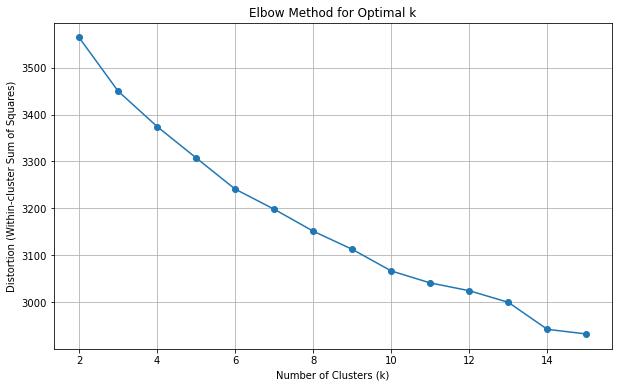

In [69]:
res = kmeans_func(df_cluster_5, 15)
# хорошие результаты на 14 4 8 кластерах

Number of clusters: 2, Silhouette Score: 0.05, Davies-Bouldin Index: 4.25
Number of clusters: 3, Silhouette Score: 0.04, Davies-Bouldin Index: 4.13
Number of clusters: 4, Silhouette Score: 0.04, Davies-Bouldin Index: 4.0
Number of clusters: 5, Silhouette Score: 0.04, Davies-Bouldin Index: 3.79
Number of clusters: 6, Silhouette Score: 0.04, Davies-Bouldin Index: 3.64
Number of clusters: 7, Silhouette Score: 0.04, Davies-Bouldin Index: 3.53
Number of clusters: 8, Silhouette Score: 0.04, Davies-Bouldin Index: 3.53
Number of clusters: 9, Silhouette Score: 0.04, Davies-Bouldin Index: 3.37
Number of clusters: 10, Silhouette Score: 0.04, Davies-Bouldin Index: 3.34
Number of clusters: 11, Silhouette Score: 0.04, Davies-Bouldin Index: 3.27
Number of clusters: 12, Silhouette Score: 0.04, Davies-Bouldin Index: 3.26
Number of clusters: 13, Silhouette Score: 0.03, Davies-Bouldin Index: 3.33
Number of clusters: 14, Silhouette Score: 0.04, Davies-Bouldin Index: 3.2
Number of clusters: 15, Silhouette 

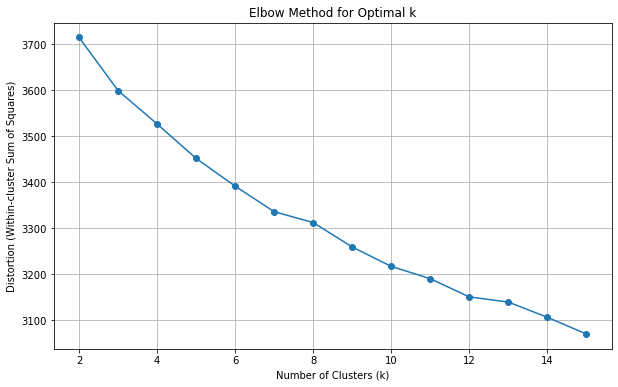

In [70]:
res = kmeans_func(df_cluster_6, 15)

Number of clusters: 2, Silhouette Score: 0.05, Davies-Bouldin Index: 4.02
Number of clusters: 3, Silhouette Score: 0.05, Davies-Bouldin Index: 3.95
Number of clusters: 4, Silhouette Score: 0.05, Davies-Bouldin Index: 3.75
Number of clusters: 5, Silhouette Score: 0.04, Davies-Bouldin Index: 3.76
Number of clusters: 6, Silhouette Score: 0.04, Davies-Bouldin Index: 3.45
Number of clusters: 7, Silhouette Score: 0.04, Davies-Bouldin Index: 3.35
Number of clusters: 8, Silhouette Score: 0.04, Davies-Bouldin Index: 3.35
Number of clusters: 9, Silhouette Score: 0.04, Davies-Bouldin Index: 3.27
Number of clusters: 10, Silhouette Score: 0.04, Davies-Bouldin Index: 3.18
Number of clusters: 11, Silhouette Score: 0.04, Davies-Bouldin Index: 3.17
Number of clusters: 12, Silhouette Score: 0.04, Davies-Bouldin Index: 3.15
Number of clusters: 13, Silhouette Score: 0.04, Davies-Bouldin Index: 3.04
Number of clusters: 14, Silhouette Score: 0.04, Davies-Bouldin Index: 2.96
Number of clusters: 15, Silhouett

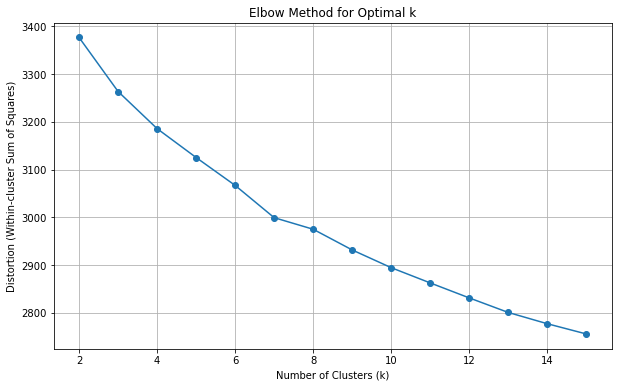

In [71]:
res = kmeans_func(df_cluster_T, 15)

Results is bad. We havnt good clusters. 

##### 4.3.2 Agglomerative Hierarchical Clustering

This method allow to choose quality clusters and have a non clustering points

In [72]:
#функция для рассчета кластеров методом Agglomerative Hierarchical

def ac(df_ac, distance_th, method):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold = distance_th, linkage=method).fit(df_ac)
    linkage_matrix = linkage(df_ac, method)
    labels = model.fit_predict(df_ac)

    # Silhouette Score
    silhouette_avg = silhouette_score(df_ac, labels)
    print(f"Silhouette Score: {silhouette_avg}")
    # Davies-Bouldin Index
    davies_bouldin_idx = davies_bouldin_score(df_ac, labels)
    print(f"Davies-Bouldin Index: {davies_bouldin_idx}")
    
    plt.figure(figsize=(18, 8))
    dendrogram(linkage_matrix)
    plt.show()
    return labels

In [73]:
#функция для описания кластеров по основным параметрам

def clusters_describe_main (labels):
    df_describe = df.copy()
    df_describe['Cluster_Labels'] = labels
    
    grouped = df_describe.groupby(['Cluster_Labels'])
    cluster_counts = df_describe['Cluster_Labels'].value_counts()
    
    result = grouped.agg({
        'Cluster_Labels': 'size', 
        'milk_consumption': 'mean', 
        'butter_consumption': 'mean', 
        'smetana_consumption': 'mean'})
    result = result.round()
    average = result.mean(axis=0)
    result = pd.concat([result, average], ignore_index=True)
    print('Size and consumption in clasters')
    print(result)    
    
    result = grouped.agg({'Cluster_Labels': 'size', 'how_many_family':'mean', 
                          'children_how_many': 'mean',  
                          'have_cat': 'mean', 'have_dog': 'mean'})

    average = result.mean(axis=0)
    result = pd.concat([result, average], ignore_index=True)
    print('About families')
    print(result)
    
    
    
        # Группируем данные по кластерам и применяем агрегацию
    table = df_describe.groupby('Cluster_Labels').agg({
        'buy_change': [lambda x: round((x == 1).mean() * 100), lambda x: round((x == 5).mean() * 100)],
        'food_share': [lambda x: round((x == 2).mean() * 100), lambda x: round((x == 3).mean() * 100)]})

    table.columns = ['%_buy_change_as_it', '%_buy_change_econ', '%_food_share_2', '%_food_share_3']
    print('Consumption trends')
    print(table)
        
    # Группируем данные по кластерам и применяем агрегацию
    table = df_describe.groupby('Cluster_Labels').agg({
        'buying_criteria_butter': [lambda x: round((x == 'by_price').sum() / len(x) * 100), 
                                   lambda x: round((x == 'love_brand').sum() / len(x) * 100),
                                   lambda x: round((x == 'some_love_brands').sum() / len(x) * 100)]})
    
    table.columns = ['%_buy_by_price', '%_buy_love_brand', '%_buy_some_love_brands']
    print('Buying_criteria_butter')    
    print(table)
        
    table = df_describe.groupby('Cluster_Labels').agg({
    'buy_novelty': [lambda x: round((x == 'Buy_new_interest').sum() / len(x) * 100),
                    lambda x: round((x == 'Buy_new_sales').sum() / len(x) * 100)],
    'try_price': lambda x: round((x == 1).sum() / len(x) * 100),
    'try_ecology': lambda x: round((x == 1).sum() / len(x) * 100),     
    'try_brand': lambda x: round((x == 1).sum() / len(x) * 100)})  
    
    table.columns = ['%_Novelty_interst', '%_Novelty_sales',  
                     '%_try_price', '%_try_ecology', '%_try_brand']
    print('Novelty motivation')    
    print(table)
    
    table = df_describe.groupby('Cluster_Labels').agg({
    'Style_var_1': lambda x: round((x == 1).sum() / len(x) * 100),
    'Style_var_2': lambda x: round((x == 1).sum() / len(x) * 100),
    'Style_var_4': lambda x: round((x == 1).sum() / len(x) * 100),
    'Style_var_5': lambda x: round((x == 1).sum() / len(x) * 100),
    'Style_var_6': lambda x: round((x == 1).sum() / len(x) * 100)})
     
    table.columns = ['Style_var_1', 'Style_var_2','Style_var_4', 'Style_var_5', 'Style_var_6']
    print('Design preference')   
    print(table)
    return None

**блок поиска оптимальных параметров кластеризации**

Сначала Устанавливаю произвольное значение distance, чтобы функция сразу рассчитывала silhoutte 
далее сравниваю различные значения distance
оставляю вариант где получаем разумное (больше 2 менее 15) число кластеров 
и их примерно равномерное распределение

Далее меняю меры расстояния

Меняю исходные данные (различаются вариантами описания препочтений в дизайне)

В ноутбуке остаются варианты с лучшими комбинациями параметров

Silhouette Score: 0.017232247965605928
Davies-Bouldin Index: 4.271345103756066


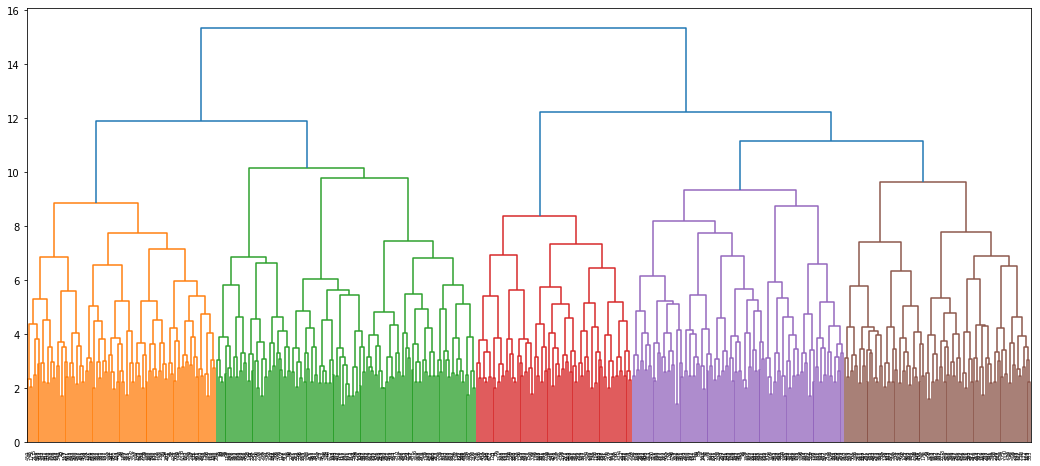

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0         96.000000         14.000000          978.125000          1952.083333
1         97.000000         15.930928         1053.092784          2226.288660
2         81.000000         14.555556         1069.135802          2697.530864
3         98.000000         12.894898          966.836735          1993.367347
4        110.000000         12.995455         1100.000000          1969.090909
5         39.000000         12.523077         1220.512821          2028.205128
average   86.833333         13.816652         1064.617190          2144.427707


In [74]:
# Сначала Устанавливаю произвольное значение distance, чтобы функция сразу рассчитывала silhoutte 
# далее сравниваю различные значения distance
# оставляю вариант где получаем разумное (больше 2 менее 15) число кластеров 
#и их примерно равномерное распределение

res = ac (df_cluster_5, 10, 'ward')
clusters_describe_func (res)

Silhouette Score: 0.01222959135882581
Davies-Bouldin Index: 3.5101249007856605


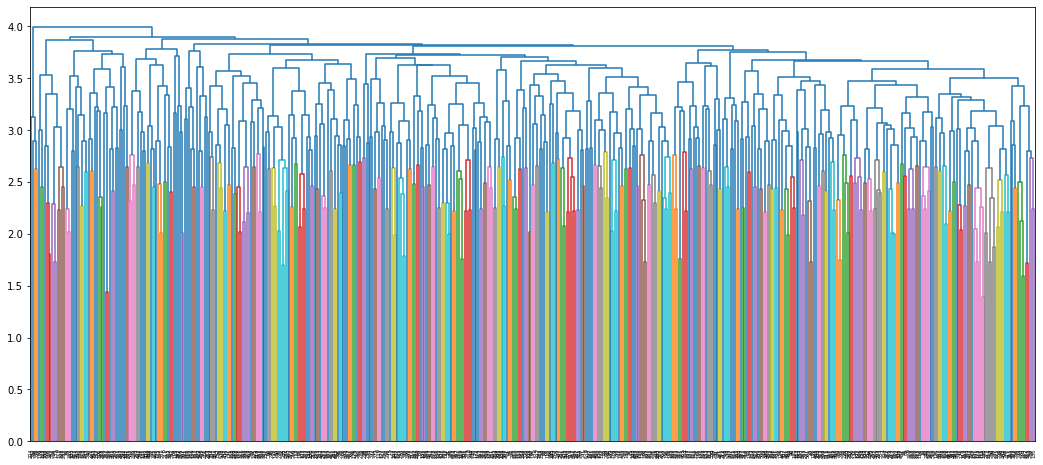

In [75]:
#аналогично предыдущему, другая мера расстояния

res = ac (df_cluster_5, 3.8, 'average' )

In [76]:
clusters_describe_func (res) 

Size and consumption in clasters
           label  milk_consumption  butter_consumption  smetana_consumption
label                                                                      
0         29.000         12.751724         1079.310345          1986.206897
1        188.000         14.332447         1063.563830          2069.414894
2         33.000         10.718182         1148.484848          2059.090909
3        161.000         14.274534         1055.900621          2345.962733
4         14.000         11.071429          850.000000          1553.571429
5         12.000         14.800000          837.500000          2508.333333
6         80.000         14.301250         1020.000000          2020.000000
7          4.000         14.250000          825.000000          1787.500000
average   65.125         13.312446          984.969956          2041.260024


Silhouette Score: -0.11137360465802215
Davies-Bouldin Index: 1.0481335396835714


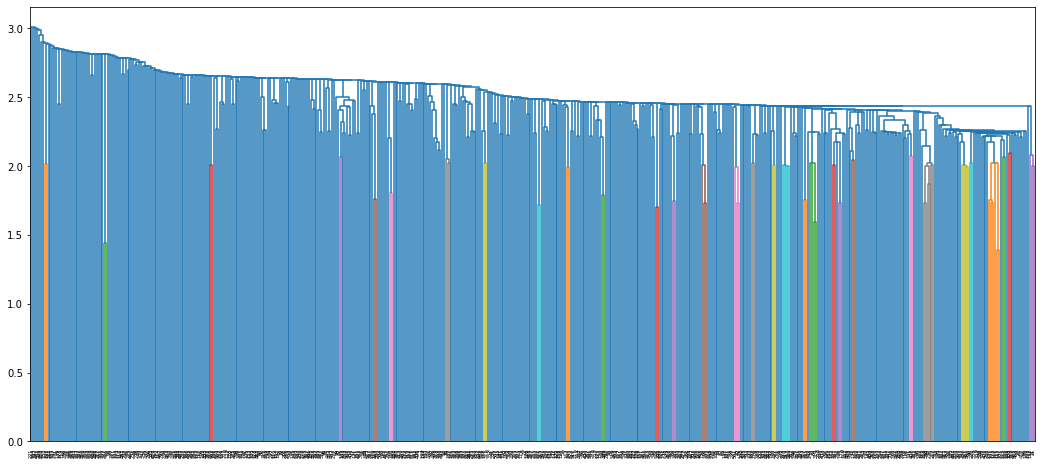

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0        269.000000         14.117844         1024.721190          2112.825279
1          2.000000         13.500000         2375.000000          1500.000000
2          4.000000         10.250000          950.000000          2075.000000
3          3.000000          6.000000          616.666667          1350.000000
4         10.000000         18.900000          895.000000          2390.000000
...             ...               ...                 ...                  ...
188        1.000000         29.000000         2000.000000          5000.000000
189        1.000000         30.000000         2000.000000           600.000000
190        2.000000         19.000000         1500.000000          1900.000000
191        1.000000          1.000000          150.000000           150.000000
average    2.713542

In [77]:
res = ac (df_cluster_5, 2.5, 'single' )
clusters_describe_func (res) 

Silhouette Score: 0.013979202668342164
Davies-Bouldin Index: 3.8274201362751663


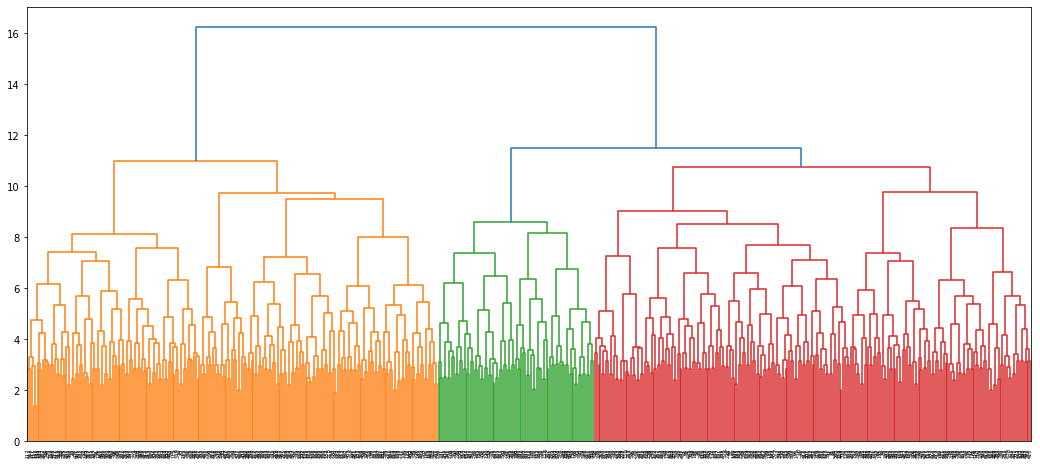

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        65.000000         13.473846         1175.384615          2185.384615
1        42.000000         12.923810          925.000000          2185.714286
2        51.000000         14.274510         1191.176471          2119.607843
3        39.000000         13.320513         1062.820513          1943.589744
4        40.000000         16.042500         1025.000000          2468.750000
5        23.000000         15.086957         1023.913043          2832.608696
6        42.000000         10.350000         1053.571429          1470.238095
7        47.000000         14.321277         1134.042553          2239.361702
8        26.000000         14.173077          917.307692          2042.307692
9        29.000000         13.017241          872.413793          2348.275862
10       23.000000         16.5

In [78]:
res = ac (df_cluster_14, 8, 'ward' )
clusters_describe_func (res) 

Silhouette Score: 0.039897456598678646
Davies-Bouldin Index: 2.834262767616817


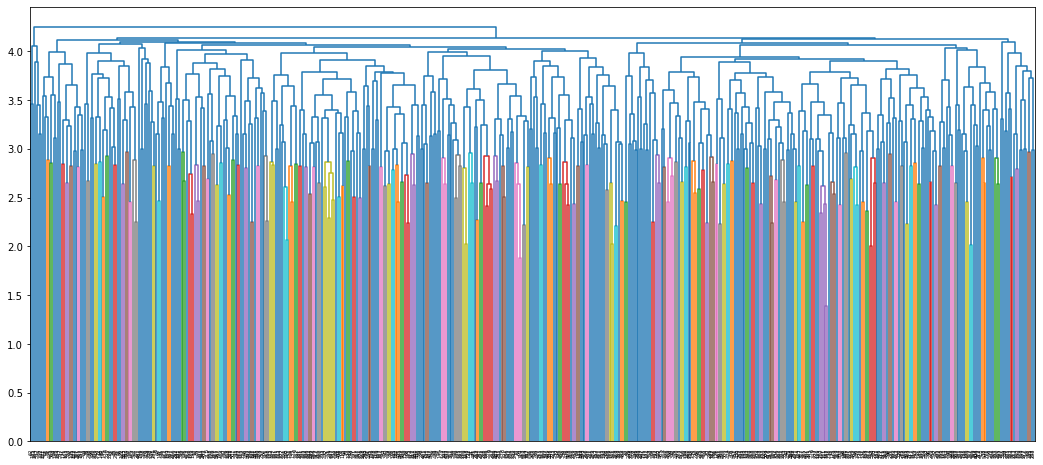

Size and consumption in clasters
         label  milk_consumption  butter_consumption  smetana_consumption
label                                                                    
0        515.0         13.819223         1046.601942          2132.233010
1          6.0         22.166667         1166.666667          2466.666667
average  260.5         17.992945         1106.634304          2299.449838


In [79]:
res = ac (df_cluster_14, 4.2, 'average' )
clusters_describe_func (res) 

Silhouette Score: 0.017197400437659827
Davies-Bouldin Index: 0.6731982175153531


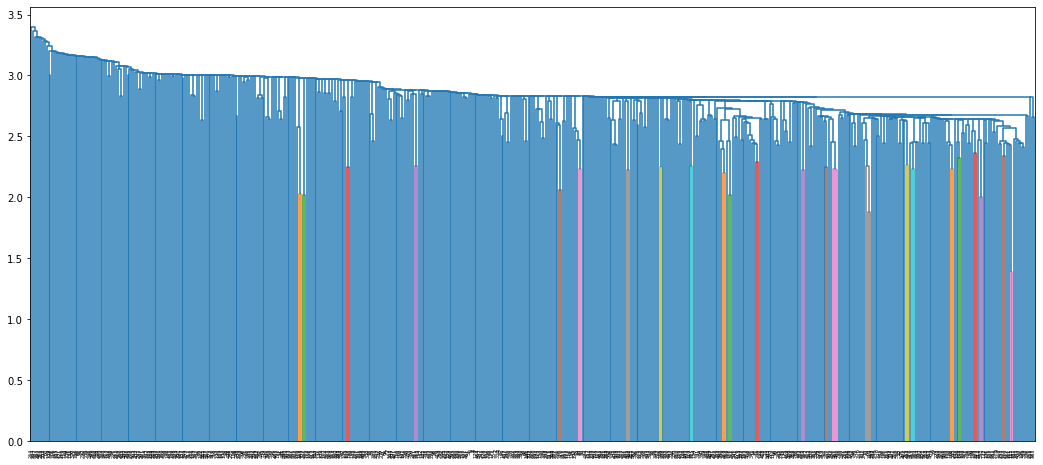

Size and consumption in clasters
            label  milk_consumption  butter_consumption  smetana_consumption
label                                                                       
0        2.000000         14.000000          900.000000          2125.000000
1        2.000000          6.250000          700.000000           800.000000
2        2.000000         19.000000         3975.000000          5500.000000
3        2.000000         17.500000          825.000000          1500.000000
4        2.000000          5.500000          900.000000           650.000000
...           ...               ...                 ...                  ...
445      1.000000         20.000000         1000.000000          1750.000000
446      1.000000         20.000000         1400.000000          2000.000000
447      1.000000         15.000000          600.000000          2500.000000
448      1.000000         30.000000          500.000000          3500.000000
average  1.160356         13.914059        

In [80]:
res = ac (df_cluster_14, 2.5, 'single' )
clusters_describe_func (res) 

Silhouette Score: 0.013961148656619899
Davies-Bouldin Index: 4.364025434008545


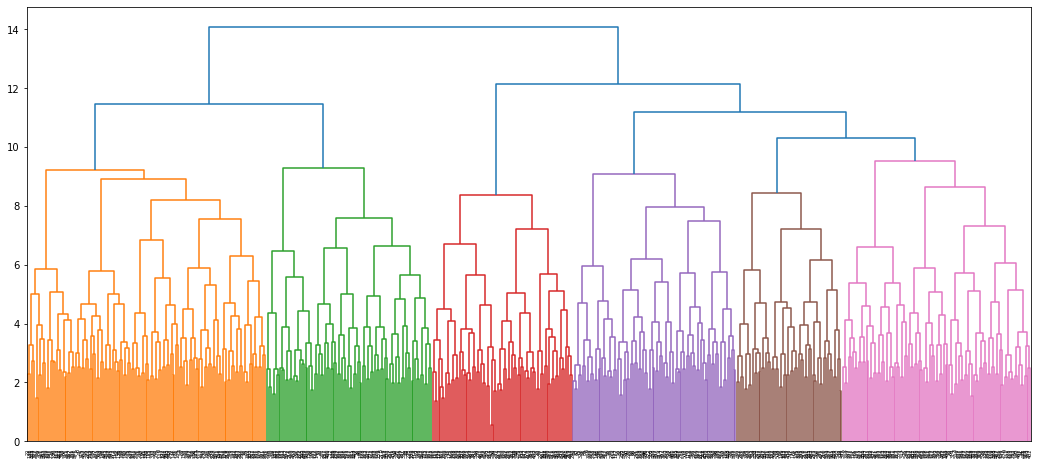

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0         98.000000         13.357143         1061.224490          2241.836735
1         86.000000         12.717442          980.232558          2074.418605
2         55.000000         14.756364          981.818182          1627.272727
3        124.000000         13.831452         1136.290323          2256.451613
4         85.000000         14.623529          987.058824          2205.294118
5         73.000000         14.760274         1080.821918          2165.068493
average   86.833333         14.007701         1037.907716          2095.057048


In [81]:
res = ac (df_cluster_T, 10, 'ward' )
clusters_describe_func (res) 

Silhouette Score: 0.008961324260789124
Davies-Bouldin Index: 3.382804236743817


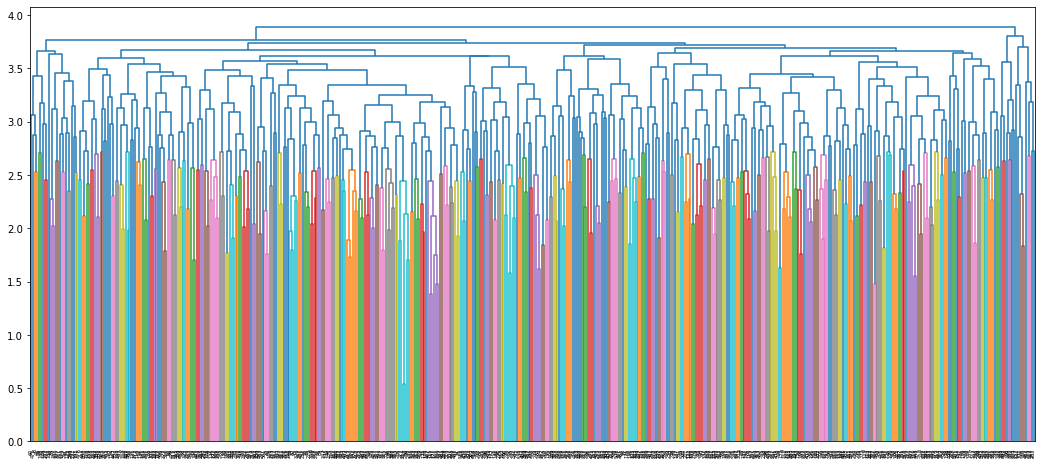

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0        184.000000         13.782065         1072.554348          2339.673913
1        244.000000         13.570492         1016.393443          2025.204918
2         50.000000         16.556000         1030.000000          1782.000000
3         25.000000         13.720000         1190.000000          2550.000000
4          5.000000         15.400000         1010.000000          2600.000000
5          8.000000         12.000000         1218.750000          1937.500000
6          5.000000         11.800000          920.000000          1380.000000
average   74.428571         13.832651         1065.385399          2087.768404


In [82]:
res = ac (df_cluster_T, 3.7, 'average' )
clusters_describe_func (res) 

Silhouette Score: 0.02310424687547102
Davies-Bouldin Index: 6.443005622104492


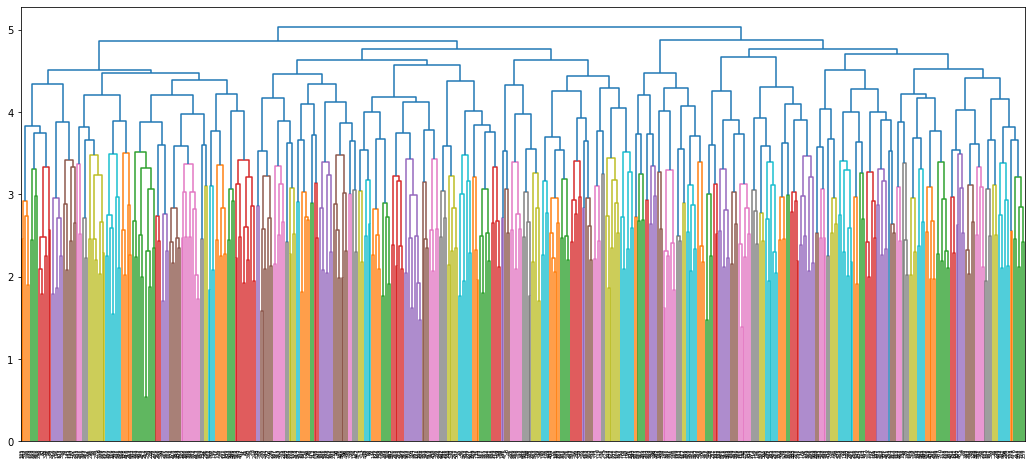

Size and consumption in clasters
         label  milk_consumption  butter_consumption  smetana_consumption
label                                                                    
0        203.0         13.636453         1113.054187          2127.586207
1        318.0         14.093396         1006.446541          2141.509434
average  260.5         13.864925         1059.750364          2134.547820


In [83]:
res = ac (df_cluster_T, 4.9, 'complete' )
clusters_describe_func (res) 

Silhouette Score: 0.02241071357063482
Davies-Bouldin Index: 4.36066868773422


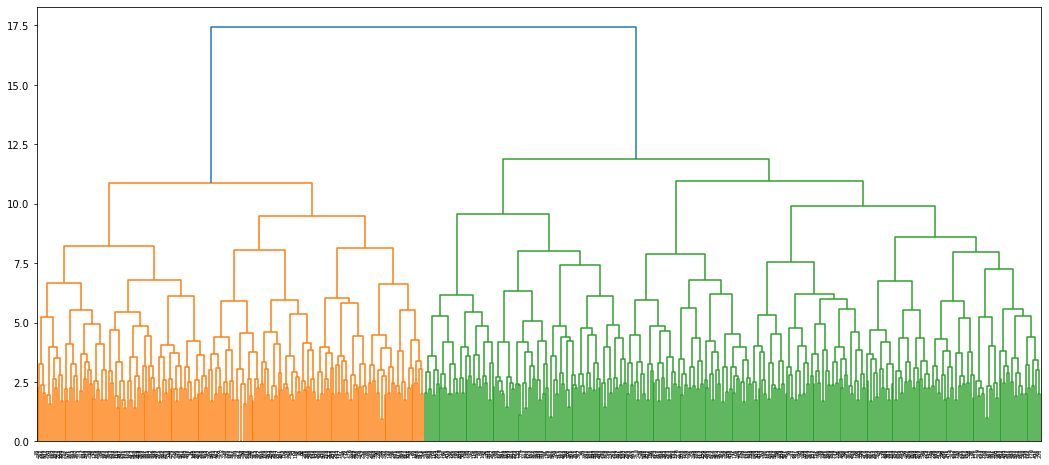

Size and consumption in clasters
         label  milk_consumption  butter_consumption  smetana_consumption
label                                                                    
0        150.0         14.788000         1045.000000          2314.000000
1        112.0         13.749107         1003.571429          2177.678571
2        105.0         13.049524         1155.238095          2322.380952
3         65.0         14.583077          954.615385          1764.615385
4         89.0         13.187640         1050.561798          1835.393258
average  104.2         13.871470         1041.797341          2082.813633


In [84]:
res = ac (df_cluster, 10, 'ward' )
clusters_describe_func (res) 

Silhouette Score: 0.013798436855190369
Davies-Bouldin Index: 3.2056931535106505


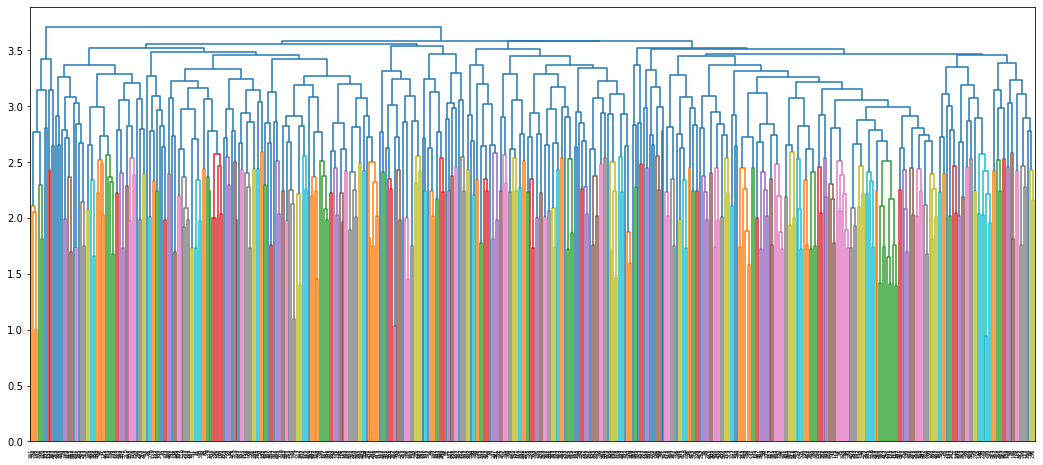

Size and consumption in clasters
         label  milk_consumption  butter_consumption  smetana_consumption
label                                                                    
0        121.0         14.561983         1029.338843          2330.578512
1        192.0         14.049479          990.625000          2083.593750
2         23.0         11.782609         1091.304348          2169.565217
3         13.0         12.846154          850.000000          1453.846154
4         69.0         14.236232         1269.565217          2278.260870
5         22.0         12.009091         1059.090909          2190.909091
6          6.0         15.733333         2716.666667          1883.333333
7         47.0         14.400000          893.617021          1800.000000
8         17.0         13.041176          976.470588          2326.470588
9         11.0         10.272727          845.454545          1927.272727
average   52.1         13.293279         1172.213314          2044.383024


In [85]:
res = ac (df_cluster, 3.5, 'average' )
clusters_describe_func (res) 

##### Clusters describing

Пока мы видим что все комбинации исходных данных, методов расчета расстояний и мер дают слабые результаты

Продолжим поиск оптимального метода


#### use  hdbscan method clasterisation

In [86]:
#функция кластеризации методов hdbscan

def hdbscan_clustering(df, min_cluster_size_values, min_samples):
    all_labels = []  # Список для хранения меток кластеров для каждого значения min_cluster_size
    max_min_cluster_size = max(min_cluster_size_values)
    
    for min_cluster_size in min_cluster_size_values:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        cluster_labels = clusterer.fit_predict(df)

        # Считаем silhouette_score
        silhouette_avg = silhouette_score(df, cluster_labels)

        # Считаем число переменных в каждом кластере
        cluster_counts = pd.Series(cluster_labels).value_counts()

        # Создаем словарь с результатами
        result_dict = {
            'min_cluster_size': min_cluster_size,
            'silhouette_score': silhouette_avg,
            'num_variables_in_clusters': len(cluster_counts),
            'num_variables_not_in_clusters': len(df) - cluster_counts.sum(),
        }

        # Выводим информацию на экран
        print(f"Results for min_cluster_size={min_cluster_size}:")
        print(result_dict)
        print('')

        # Выводим информацию о каждом кластере и его размере
        print("Cluster Information:")
        for cluster_num, cluster_size in cluster_counts.items():
            print(f"Cluster {cluster_num}: {cluster_size} observations")
        print('')
        print('')

        # Сохраняем метки только для максимального значения min_cluster_size
        if min_cluster_size == max_min_cluster_size:
            all_labels = cluster_labels

    return all_labels



In [87]:
#аналог предыдущей функции, но без расчета silhouette, позволяет избегать ошибки, 
#когда ее расчет невозможен

def hdbscan_clustering_brief(df, min_cluster_size_values, min_samples):
    all_labels = []  # Список для хранения меток кластеров для каждого значения min_cluster_size
    max_min_cluster_size = max(min_cluster_size_values)
    
    for min_cluster_size in min_cluster_size_values:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                    min_samples=min_samples, metric='manhattan')
        cluster_labels = clusterer.fit_predict(df)

 

        # Считаем число переменных в каждом кластере
        cluster_counts = pd.Series(cluster_labels).value_counts()

        # Создаем словарь с результатами
        result_dict = {
            'min_cluster_size': min_cluster_size,
           
            'num_variables_in_clusters': len(cluster_counts),
            'num_variables_not_in_clusters': len(df) - cluster_counts.sum(),
        }

        # Выводим информацию на экран
        print(f"Results for min_cluster_size={min_cluster_size}:")
        print(result_dict)
        print('')

        # Выводим информацию о каждом кластере и его размере
        print("Cluster Information:")
        for cluster_num, cluster_size in cluster_counts.items():
            print(f"Cluster {cluster_num}: {cluster_size} observations")
        print('')
        print('')

        # Сохраняем метки только для максимального значения min_cluster_size
        if min_cluster_size == max_min_cluster_size:
            all_labels = cluster_labels

    return all_labels



In [88]:
# Пробные расчеты

min_cluster_size_values = [11, 12, 13]

min_samples = 2

results = hdbscan_clustering(df_cluster, min_cluster_size_values, min_samples)
##print(results)

Results for min_cluster_size=11:
{'min_cluster_size': 11, 'silhouette_score': -0.038439566742611585, 'num_variables_in_clusters': 4, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 383 observations
Cluster 1: 109 observations
Cluster 2: 16 observations
Cluster 0: 13 observations


Results for min_cluster_size=12:
{'min_cluster_size': 12, 'silhouette_score': -0.038439566742611585, 'num_variables_in_clusters': 4, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 383 observations
Cluster 1: 109 observations
Cluster 2: 16 observations
Cluster 0: 13 observations


Results for min_cluster_size=13:
{'min_cluster_size': 13, 'silhouette_score': -0.038439566742611585, 'num_variables_in_clusters': 4, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 383 observations
Cluster 1: 109 observations
Cluster 2: 16 observations
Cluster 0: 13 observations




In [89]:
min_cluster_size_values = [4, 5, 6, 7, 8, 9]
min_samples = 2

results = hdbscan_clustering(df_cluster_5, min_cluster_size_values, min_samples)

Results for min_cluster_size=4:
{'min_cluster_size': 4, 'silhouette_score': -0.046387381102847056, 'num_variables_in_clusters': 6, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 288 observations
Cluster 4: 211 observations
Cluster 1: 9 observations
Cluster 3: 5 observations
Cluster 0: 4 observations
Cluster 2: 4 observations


Results for min_cluster_size=5:
{'min_cluster_size': 5, 'silhouette_score': -0.03711233578972618, 'num_variables_in_clusters': 4, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 296 observations
Cluster 2: 211 observations
Cluster 0: 9 observations
Cluster 1: 5 observations


Results for min_cluster_size=6:
{'min_cluster_size': 6, 'silhouette_score': -0.008241497229638732, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 1: 259 observations
Cluster -1: 253 observations
Cluster 0: 9 observations


Results for min_cluster_size=7:
{'min_cluster_size': 7, 'silhouette_score':

In [90]:
min_cluster_size_values = [2, 3, 4, 5]
min_samples = 2

results = hdbscan_clustering_brief(df_cluster_5, min_cluster_size_values, min_samples)

Results for min_cluster_size=2:
{'min_cluster_size': 2, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 1: 474 observations
Cluster -1: 45 observations
Cluster 0: 2 observations


Results for min_cluster_size=3:
{'min_cluster_size': 3, 'num_variables_in_clusters': 5, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 3: 305 observations
Cluster -1: 205 observations
Cluster 0: 5 observations
Cluster 2: 3 observations
Cluster 1: 3 observations


Results for min_cluster_size=4:
{'min_cluster_size': 4, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 1: 336 observations
Cluster -1: 180 observations
Cluster 0: 5 observations


Results for min_cluster_size=5:
{'min_cluster_size': 5, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 1: 336 observations
Cluster -1: 180 observations
Cluster 0: 5 observations




In [91]:
min_cluster_size_values = [7, 8, 9, 10, 11, 12, 13]

min_samples = 2

results = hdbscan_clustering(df_cluster_14, min_cluster_size_values, min_samples)

Results for min_cluster_size=7:
{'min_cluster_size': 7, 'silhouette_score': -0.02209046942881109, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 411 observations
Cluster 0: 86 observations
Cluster 1: 24 observations


Results for min_cluster_size=8:
{'min_cluster_size': 8, 'silhouette_score': -0.02209046942881109, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 411 observations
Cluster 0: 86 observations
Cluster 1: 24 observations


Results for min_cluster_size=9:
{'min_cluster_size': 9, 'silhouette_score': -0.02209046942881109, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 411 observations
Cluster 0: 86 observations
Cluster 1: 24 observations


Results for min_cluster_size=10:
{'min_cluster_size': 10, 'silhouette_score': -0.02209046942881109, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Info

In [92]:
min_cluster_size_values = [2,3, 4, 5, 6, 7, 8, 9, 10]

min_samples = 2

results = hdbscan_clustering(df_cluster_T, min_cluster_size_values, min_samples)

Results for min_cluster_size=2:
{'min_cluster_size': 2, 'silhouette_score': -0.112357573481717, 'num_variables_in_clusters': 49, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 352 observations
Cluster 28: 11 observations
Cluster 12: 7 observations
Cluster 44: 7 observations
Cluster 36: 6 observations
Cluster 47: 6 observations
Cluster 33: 6 observations
Cluster 22: 5 observations
Cluster 43: 5 observations
Cluster 19: 5 observations
Cluster 25: 5 observations
Cluster 37: 5 observations
Cluster 39: 5 observations
Cluster 13: 4 observations
Cluster 38: 4 observations
Cluster 11: 4 observations
Cluster 32: 4 observations
Cluster 26: 4 observations
Cluster 3: 3 observations
Cluster 6: 3 observations
Cluster 20: 3 observations
Cluster 27: 3 observations
Cluster 0: 3 observations
Cluster 17: 3 observations
Cluster 23: 3 observations
Cluster 2: 3 observations
Cluster 24: 3 observations
Cluster 9: 3 observations
Cluster 45: 3 observations
Cluster 1: 3 observations
Cluste

In [93]:
min_cluster_size_values = [2,3, 4, 5, 6, 7, 8, 9, 10]

min_samples = 2

results = hdbscan_clustering(df_cluster_T, min_cluster_size_values, min_samples)

Results for min_cluster_size=2:
{'min_cluster_size': 2, 'silhouette_score': -0.112357573481717, 'num_variables_in_clusters': 49, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 352 observations
Cluster 28: 11 observations
Cluster 12: 7 observations
Cluster 44: 7 observations
Cluster 36: 6 observations
Cluster 47: 6 observations
Cluster 33: 6 observations
Cluster 22: 5 observations
Cluster 43: 5 observations
Cluster 19: 5 observations
Cluster 25: 5 observations
Cluster 37: 5 observations
Cluster 39: 5 observations
Cluster 13: 4 observations
Cluster 38: 4 observations
Cluster 11: 4 observations
Cluster 32: 4 observations
Cluster 26: 4 observations
Cluster 3: 3 observations
Cluster 6: 3 observations
Cluster 20: 3 observations
Cluster 27: 3 observations
Cluster 0: 3 observations
Cluster 17: 3 observations
Cluster 23: 3 observations
Cluster 2: 3 observations
Cluster 24: 3 observations
Cluster 9: 3 observations
Cluster 45: 3 observations
Cluster 1: 3 observations
Cluste

#### Выводы по HDBSCAN методу

- Получается малое число кластеров. основные варианты
- 400 и 100
- 300 и 300 (5 дизайнов, T компоненты)

- Плохие показатели по индексам 
  


**Make discription claster from different methods and highlight most active variables:**

k-means df_cluster_T  : 8 

Number of clusters: 2, Silhouette Score: 0.05, Davies-Bouldin Index: 4.13
Number of clusters: 3, Silhouette Score: 0.04, Davies-Bouldin Index: 4.04
Number of clusters: 4, Silhouette Score: 0.04, Davies-Bouldin Index: 4.01
Number of clusters: 5, Silhouette Score: 0.04, Davies-Bouldin Index: 3.83
Number of clusters: 6, Silhouette Score: 0.04, Davies-Bouldin Index: 3.6
Number of clusters: 7, Silhouette Score: 0.04, Davies-Bouldin Index: 3.51
Number of clusters: 8, Silhouette Score: 0.04, Davies-Bouldin Index: 3.41


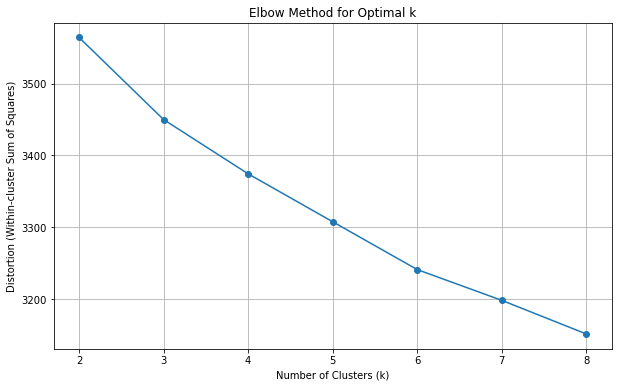

In [94]:
res = kmeans_func(df_cluster_5, 8)


In [99]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
           label  milk_consumption  butter_consumption  smetana_consumption
label                                                                      
0        102.000         12.842157          980.392157          2402.450980
1         50.000         13.632000         1091.000000          2274.000000
2         58.000         14.236207          989.655172          1697.413793
3         64.000         16.325000         1085.937500          2038.281250
4         46.000         13.080435          958.695652          1783.695652
5         67.000         13.246269         1269.402985          2183.582090
6         79.000         13.869620          926.582278          2055.696203
7         55.000         14.600000         1130.909091          2445.454545
average   65.125         13.978961         1054.071854          2110.071814
Variable: city_Moscow

Frequency Table:
Cluster         0     1     2     3     4     5     6     7  R_Mean
city_Moscow            

#### K-Means ОПИСАНИЯ ВАРИАНТОВ КЛАСТЕРОВ

k-means df_cluster_T  : 8

0    70.0   Рег   how_to_shopping_once_week_plus Buy_new_sales buying_criteria_milk_by_price  Sales_preference_no_preferencebuying_criteria_milk_price_first How_choose_brand_buy_any_discount_brand  Eco_products_opinion_Better_dont_buy Style_var_2  ## Экономят, главное скидки, регионы, пейзаж дизайн

1    50.0   Мос Check_price_sometimes Buy_new_interest  Sales_preference_national    Style_var_5  Style_var_6 How_choose_brand_buy_only_known_brand  №№ Москвичи, спокойны к цене, интересующиеся, солидные дизайны

2    72.0   Рег Check_price_new_goods  buying_criteria_milk_love_brand  How_choose_brand_buy_lovely_brand  Eco_fans Style_var_4  №№ Любимые бренды и эко, граф дизайн

3    51.0   много масла  не москва Питер buying_criteria_milk_some_love_brands Sales_preference_no_preference  How_choose_brand_buy_only_known_brand №№ Питер между любимыми брендами и без предпочтений

4    60.0    много масла Мос buying_criteria_milk_fresh Sales_preference_village  How_choose_brand_buy_known_brand Eco_products_opinion_Better_dont_buy   Eco_fans Style_var_4 Style_var_5 №№ свежесть и происхождение, москва, дорогой продукт, лакон дизайн

5    64.0   больше молока и сметаны, how_to_shopping_once_week_plus  buying_criteria_milk_fresh How_choose_brand_buy_known_brand Eco_products_opinion_Fake Style_var_1 №№ неясные

6    90.0     Рег how_to_shopping_twice_week Buy_new_sales How_choose_brand_buy_known_brand v Style_var_2
buying_criteria_milk_fresh Sales_preference_no_preference №№ обыватели покупают у дома, смотрят на распродажи, готовы попробовать неизвестное. Регионы

7    64.0    Рег how_to_shopping_once_week_plus Buy_new_interest buying_criteria_milk_some_love_brands How_choose_brand_buy_lovely_brand Style_var_5 №№регионы, любимые бренды. Похожи на 2

Влиятельные переменные
city_Moscow, city_S_Peterburg 

try_ не очень информативна

Silhouette Score: 0.008961324260789124
Davies-Bouldin Index: 3.382804236743817


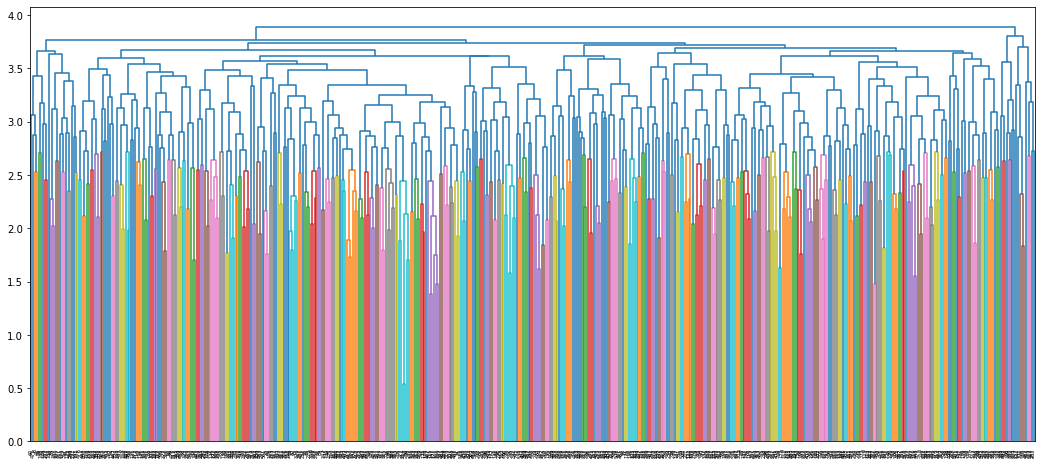

In [100]:
res = ac (df_cluster_T, 3.7, 'average' )

In [101]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0        184.000000         13.782065         1072.554348          2339.673913
1        244.000000         13.570492         1016.393443          2025.204918
2         50.000000         16.556000         1030.000000          1782.000000
3         25.000000         13.720000         1190.000000          2550.000000
4          5.000000         15.400000         1010.000000          2600.000000
5          8.000000         12.000000         1218.750000          1937.500000
6          5.000000         11.800000          920.000000          1380.000000
average   74.428571         13.832651         1065.385399          2087.768404
Variable: city_Moscow

Frequency Table:
Cluster         0     1     2     3     4      5      6  R_Mean
city_Moscow                                                    
0        

#### Aglomerative method ОПИСАНИЯ КЛАСТЕРОВ ИЕРАРХИЧЕСКОГО МЕТОДА 6 КЛАСТЕРОВ ----res = ac (df_cluster_T, 3.7, 'average' )

Size and consumption in clasters
    label  
0   184.0   много сметаны, чаще питер,  price-opinion_Check_price_new_goods buy_novelty_Buy_new_interest buying_criteria_milk_love_brand buying_criteria_milk_some_love_brands How_choose_brand_buy_lovely_brand more Eco_fans  №№№ЛЮБИМЫЕ БРЕНДЫ, СПОКОЙНЫЕ К ЦЕНЕ

1   244.0  рег  buy_novelty_Buy_new_sales Sales_preference_no_preference         How_choose_brand_buy_any_discount_brand How_choose_brand_buy_known_brand  Eco_products_opinion_Better_dont_buy less Eco_fans №№№ЭКОНОМЯТ, НЕ РИСКУЮТ, БЕРУТ ЗНАКОМОЕ РЕГИОНЫ

2    50.0   больше молока, мос price-opinion_Check_price_sometimes         buy_novelty_Buy_new_interest buying_criteria_milk_some_love_brands Sales_preference_national   How_choose_brand_buy_only_known_brand Style_var_4
№№№СПОКОЙНЫ К ЦЕНАМ, ЛЮБЯТ НОВИНКИ И НАЦИОНАЛЬНЫЕ БРЕНДЫ, ЧАЩЕ ИЗ МОСКВЫ, ГРАФ ДИЗАЙН

3    25.0   how_to_shopping_once_month buy_novelty_Dont_buy_new  Sales_preference_no_preference  How_choose_brand_buy_lovely_brand   Eco_products_opinion_Same  №№№КОНСЕРВАТОРЫ НИГИЛИСТЫ

4     5.0            
5     8.0       
6     5.0        


Переменные
Не работают One_brand_different_goods 

Silhouette Score: 0.017232247965605928
Davies-Bouldin Index: 4.271345103756066


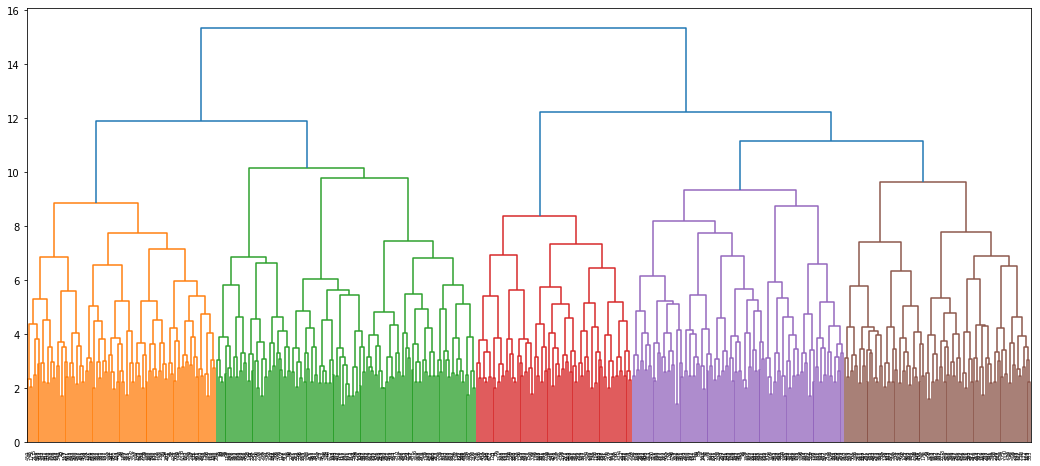

In [102]:
res = ac (df_cluster_5, 10, 'ward')

In [103]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0         96.000000         14.000000          978.125000          1952.083333
1         97.000000         15.930928         1053.092784          2226.288660
2         81.000000         14.555556         1069.135802          2697.530864
3         98.000000         12.894898          966.836735          1993.367347
4        110.000000         12.995455         1100.000000          1969.090909
5         39.000000         12.523077         1220.512821          2028.205128
average   86.833333         13.816652         1064.617190          2144.427707
Variable: city_Moscow

Frequency Table:
Cluster         0     1     2     3     4     5  R_Mean
city_Moscow                                            
0            45.8  61.9  96.3  58.2  35.5  92.3    65.0
1            54.2  38.1   3.7  41.8  64.5   7.7 

### Aglomerative -- ОПИСАНИЯ КЛАСТЕРОВ 7 КЛ ---------------
res = ac (df_cluster_5, 10, 'ward')

    label  
0   101.0  Мос-,   how_to_shopping_once_week_plus buy_novelty_Buy_new_sales buying_criteria_milk_price_first-  Sales_preference_no_preference How_choose_brand_buy_any_discount_brand  Eco_products_opinion_Better_dont_buy-  antiEco_fans   №№№ЭКОНОМЯЩИЕ 

1    72.0 Мос!, buy_novelty_Buy_new_interest Sales_preference_village        Eco_products_opinion_Better_buy- Eco_fans
№№№ЭКО ФАНАТЫ ИЗ МОСКВЫ

2    98.0 сметана,   Питер  price-opinion_Check_price_new_goods  buying_criteria_milk_love_brand    How_choose_brand_buy_lovely_brand  Eco_fans №№№ФАНАТЫ БРЕНДА 

3    84.0 меньше всего,   Рег  how_to_shopping_twice_week  How_choose_brand_buy_known_brand  №№№ЧАСТНЫЕ МЕЛКИЕ ПОКУПКИ

4    72.0  Рег   how_to_shopping_once_week_plus buy_novelty_Like_buy_new-
Eco_products_opinion_Better_dont_buy- Style_var_6-  №№№НЕПОНЯТНЫЕ

5    42.0 молоко   price-opinion_Check_price_sometimes buy_novelty_Buy_new_interest     How_choose_brand_buy_only_known_brand Style_var_1 Style_var_4 №№№НЕПОНЯТНЫЕ

6    52.0   Питер     buy_novelty_Buy_new_sales  Style_var_6 antiEco_fans №№№НЕПОНЯТНЫЕ

In [104]:
min_cluster_size_values = [ 6]
min_samples = 2

res = hdbscan_clustering(df_cluster_5, min_cluster_size_values, min_samples)

Results for min_cluster_size=6:
{'min_cluster_size': 6, 'silhouette_score': -0.008241497229638732, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 1: 259 observations
Cluster -1: 253 observations
Cluster 0: 9 observations




In [105]:
clusters_describe_func (res)


Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
-1       253.000000         13.724506         1072.529644          2183.794466
0          9.000000         18.000000          905.555556          2511.111111
1        259.000000         13.959846         1028.957529          2076.447876
average  173.666667         15.228117         1002.347576          2257.117818


In [106]:
create_cluster_frequency_tables(df_cluster_5, res)

Variable: city_Moscow

Frequency Table:
Cluster        -1     0     1  R_Mean
city_Moscow                          
0            58.9  55.6  61.8    58.8
1            41.1  44.4  38.2    41.2


Variable: city_S_Peterburg

Frequency Table:
Cluster             -1     0     1  R_Mean
city_S_Peterburg                          
0                 67.2  66.7  73.0    69.0
1                 32.8  33.3  27.0    31.0


Variable: how_to_shopping_once_month

Frequency Table:
Cluster                       -1      0     1  R_Mean
how_to_shopping_once_month                           
0                           90.5  100.0  95.8    95.4
1                            9.5    NaN   4.2     6.8


Variable: how_to_shopping_once_week_only

Frequency Table:
Cluster                           -1      0     1  R_Mean
how_to_shopping_once_week_only                           
0                               93.3  100.0  98.5    97.3
1                                6.7    NaN   1.5     4.1


Variable: how_to_shop

#### HDBSCAN АНАЛИЗ КЛАСТЕРОВ 2 ----------------

Cluster 1: 259 observations Check_price_sometimes buy_only_known_brand 

Cluster 0: 9 observations 

Cluster -1: 253 observations buy_novelty_Buy_new_sales buy_known_brand 

Кластеры очень плохо различимы между собой

#### Hypotheses

Лучшая классификация на данный момент по результатам k-means df_cluster_T  : 8
Полученные кластеры похожи на кластеры по иерархическому методу, но более разнообразны.

Выделяются следующие типы:
- Экономящие 13%
- Спокойные к цене интересующиеся новым 10%
- Эко фаны 14%
- Лояльные к одному бренду 10%
- За свежесть 12%
- У дома и со скидками 17%
- Непонятные 25%

#### Оптимизация переменных

В настоящее время мы имеем 43 переменных. Возможно, снижение их числа позволит улучшить качество кластеризации и сделать кластеры более явными

Используем 2 варианта:

1. Исключим часть исходных переменных и все их бинарные варианты ответов. Удалим те, которые реже использовались в описании кластеров или по моему экспертному мнению могут дублироваться с другими или быть менее информативными
2. Исключим бинарные ответы с малым числом положительных значений. Предположительно варианты в которых доминирует одно значение снижают различимость кластеров (с другой стороны, бинарных переменных с высоким положительным ответом крайне мало и они являются предположительно более информативными).


##### Вариант 1 уменьшаем число исходных переменных



Делаем подсчет частоты упоминания различных переменных в описании кластеров

In [107]:
#в заданном тексте считаем число упоминаний различных переменных. 
# для выявления переменных используем характерный знак "_" обозначающий, 
#что это часть наименования переменной, а не новая переменная 

# Ваши тексты
texts = ['101.0 Мос-, how_to_shopping_once_week_plus\
buy_novelty_Buy_new_sales buying_criteria_milk_price_first-\
Sales_preference_no_preference How_choose_brand_buy_any_discount_brand \
Eco_products_opinion_Better_dont_buy- antiEco_fans №№№ЭКОНОМЯЩИЕ\
1 72.0 Мос!, buy_novelty_Buy_new_interest Sales_preference_village \
Eco_products_opinion_Better_buy- Eco_fans №№№ЭКО ФАНАТЫ ИЗ МОСКВЫ\
2 98.0 сметана, Питер price-opinion_Check_price_new_goods \
buying_criteria_milk_love_brand How_choose_brand_buy_lovely_brand\
Eco_fans №№№ФАНАТЫ БРЕНДА\
3 84.0 меньше всего, Рег how_to_shopping_twice_week \
How_choose_brand_buy_known_brand №№№ЧАСТНЫЕ МЕЛКИЕ ПОКУПКИ\
4 72.0 Рег how_to_shopping_once_week_plus buy_novelty_Like_buy_new- \
Eco_products_opinion_Better_dont_buy- Style_var_6- №№№НЕПОНЯТНЫЕ\
5 42.0 молоко price-opinion_Check_price_sometimes buy_novelty_Buy_new_interest \
How_choose_brand_buy_only_known_brand Style_var_1 Style_var_4 №№№НЕПОНЯТНЫЕ\
6 52.0 Питер buy_novelty_Buy_new_sales Style_var_6 antiEco_fans №№№НЕПОНЯТНЫЕ\
0    70.0   Рег   how_to_shopping_once_week_plus Buy_new_sales \
buying_criteria_milk_by_price  \
Sales_preference_no_preferencebuying_criteria_milk_price_first \
How_choose_brand_buy_any_discount_brand  Eco_products_opinion_Better_dont_buy \
Style_var_2  ## Экономят, главное скидки, регионы, пейзаж дизайн\
1    50.0   Мос Check_price_sometimes Buy_new_interest  Sales_preference_national  \
Style_var_5  Style_var_6 How_choose_brand_buy_only_known_brand  №№ Москвичи, \
спокойны к цене, интересующиеся, солидные дизайны\
2    72.0   Рег Check_price_new_goods  buying_criteria_milk_love_brand  \
How_choose_brand_buy_lovely_brand  Eco_fans Style_var_4  \
№№ Любимые бренды и эко, граф дизайн\
3    51.0   много масла  не москва Питер buying_criteria_milk_some_love_brands \
Sales_preference_no_preference  How_choose_brand_buy_only_known_brand №№ \
Питер между любимыми брендами и без предпочтений\
4    60.0    много масла Мос buying_criteria_milk_fresh Sales_preference_village  \
How_choose_brand_buy_known_brand Eco_products_opinion_Better_dont_buy   \
Eco_fans Style_var_4 Style_var_5 №№ свежесть и происхождение, москва, \
дорогой продукт, лакон дизайн\
5    64.0   больше молока и сметаны, how_to_shopping_once_week_plus \
buying_criteria_milk_fresh How_choose_brand_buy_known_brand Eco_products_opinion_Fake \
Style_var_1 №№ неясные\
6    90.0     Рег how_to_shopping_twice_week Buy_new_sales \
How_choose_brand_buy_known_brand v Style_var_2\
buying_criteria_milk_fresh Sales_preference_no_preference \
№№ обыватели покупают у дома, смотрят на распродажи, готовы\
попробовать неизвестное. Регионы\
7    64.0    Рег how_to_shopping_once_week_plus Buy_new_interest \
buying_criteria_milk_some_love_brands How_choose_brand_buy_lovely_brand \
Style_var_5 №№регионы, любимые бренды. Похожи на 2']

# Паттерн для поиска наименований переменных на английском с символом "_"
variable_pattern = re.compile(r'\b\w+_\w+\b')

# Собираем все переменные из текстов
all_variables = [match.group() for text in texts for match in variable_pattern.finditer(text)]

# Подсчитываем частоту встречаемости каждой переменной
variable_counts = Counter(all_variables)

# Выводим наиболее часто встречающиеся переменные
most_common_variables = variable_counts.most_common()
print("Наиболее часто встречающиеся переменные:")
for variable, count in most_common_variables:
    print(f"{variable}: {count} раз")


Наиболее часто встречающиеся переменные:
Eco_products_opinion_Better_dont_buy: 4 раз
How_choose_brand_buy_known_brand: 4 раз
how_to_shopping_once_week_plus: 4 раз
Sales_preference_no_preference: 3 раз
Eco_fans: 3 раз
Style_var_6: 3 раз
How_choose_brand_buy_only_known_brand: 3 раз
Style_var_4: 3 раз
Style_var_5: 3 раз
How_choose_brand_buy_any_discount_brand: 2 раз
antiEco_fans: 2 раз
buy_novelty_Buy_new_interest: 2 раз
Sales_preference_village: 2 раз
buying_criteria_milk_love_brand: 2 раз
how_to_shopping_twice_week: 2 раз
Style_var_1: 2 раз
Buy_new_sales: 2 раз
Buy_new_interest: 2 раз
How_choose_brand_buy_lovely_brand: 2 раз
buying_criteria_milk_some_love_brands: 2 раз
buying_criteria_milk_fresh: 2 раз
how_to_shopping_once_week_plusbuy_novelty_Buy_new_sales: 1 раз
buying_criteria_milk_price_first: 1 раз
Eco_products_opinion_Better_buy: 1 раз
opinion_Check_price_new_goods: 1 раз
How_choose_brand_buy_lovely_brandEco_fans: 1 раз
buy_novelty_Like_buy_new: 1 раз
opinion_Check_price_sometimes


По результатам анализа частоты упоминания вопросов в описании кластеров и анализа их уникальности было решено удалить из массива данных следующие 15 переменных:

how_to_shopping_once_month
how_to_shopping_once_week_only
how_to_shopping_once_week_plus
how_to_shopping_twice_week
One_brand_different_goods_may_be
One_brand_different_goods_no_depend
Sales_preference_national
Sales_preference_no_preference
Sales_preference_regional
Sales_preference_village
Eco_products_opinion_Better_buy
Eco_products_opinion_Better_dont_buy
Eco_products_opinion_Better_rare
Eco_products_opinion_Fake
Eco_products_opinion_Same


In [108]:
to_remove = ['how_to_shopping_once_month', 'how_to_shopping_once_week_only', 
             'how_to_shopping_once_week_plus', 'how_to_shopping_twice_week', 
             'One_brand_different_goods_may_be', 'One_brand_different_goods_no_depend',
             'Sales_preference_national', 'how_to_shopping_once_month', 
             'how_to_shopping_once_week_only', 'how_to_shopping_once_week_plus',
             'how_to_shopping_twice_week', 'One_brand_different_goods_may_be',
             'One_brand_different_goods_no_depend', 'Sales_preference_national',
             'Sales_preference_no_preference', 'Sales_preference_regional',
             'Sales_preference_village', 'Eco_products_opinion_Better_buy', 
             'Eco_products_opinion_Better_dont_buy', 'Eco_products_opinion_Better_rare',
             'Eco_products_opinion_Fake', 'Eco_products_opinion_Same',
             'Sales_preference_no_preference', 'Sales_preference_regional', 
             'Sales_preference_village', 'Eco_products_opinion_Better_buy',
             'Eco_products_opinion_Better_dont_buy', 'Eco_products_opinion_Better_rare',
             'Eco_products_opinion_Fake', 'Eco_products_opinion_Same']

df_cluster_short = df_cluster_5.drop(columns=to_remove)

##### Применим методы кластерного анализа к новым данным

Number of clusters: 2, Silhouette Score: 0.07, Davies-Bouldin Index: 3.47
Number of clusters: 3, Silhouette Score: 0.06, Davies-Bouldin Index: 3.51
Number of clusters: 4, Silhouette Score: 0.09, Davies-Bouldin Index: 2.92
Number of clusters: 5, Silhouette Score: 0.07, Davies-Bouldin Index: 2.96
Number of clusters: 6, Silhouette Score: 0.07, Davies-Bouldin Index: 2.92
Number of clusters: 7, Silhouette Score: 0.07, Davies-Bouldin Index: 2.94
Number of clusters: 8, Silhouette Score: 0.07, Davies-Bouldin Index: 2.74
Number of clusters: 9, Silhouette Score: 0.06, Davies-Bouldin Index: 2.77
Number of clusters: 10, Silhouette Score: 0.06, Davies-Bouldin Index: 2.74
Number of clusters: 11, Silhouette Score: 0.07, Davies-Bouldin Index: 2.66
Number of clusters: 12, Silhouette Score: 0.06, Davies-Bouldin Index: 2.72
Number of clusters: 13, Silhouette Score: 0.07, Davies-Bouldin Index: 2.6
Number of clusters: 14, Silhouette Score: 0.07, Davies-Bouldin Index: 2.48
Number of clusters: 15, Silhouette

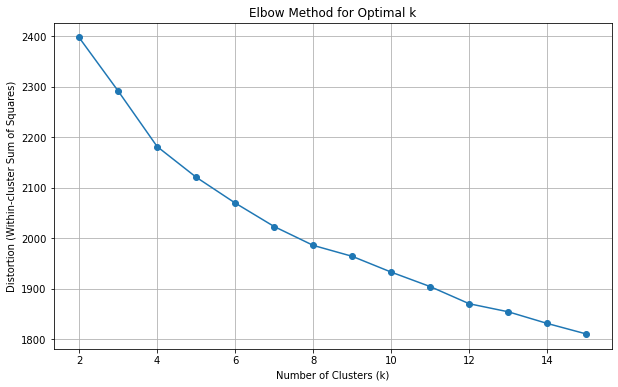

In [109]:
res = kmeans_func(df_cluster_short, 15)

Number of clusters: 2, Silhouette Score: 0.07, Davies-Bouldin Index: 3.47
Number of clusters: 3, Silhouette Score: 0.06, Davies-Bouldin Index: 3.51
Number of clusters: 4, Silhouette Score: 0.09, Davies-Bouldin Index: 2.92
Number of clusters: 5, Silhouette Score: 0.07, Davies-Bouldin Index: 2.96
Number of clusters: 6, Silhouette Score: 0.07, Davies-Bouldin Index: 2.92
Number of clusters: 7, Silhouette Score: 0.07, Davies-Bouldin Index: 2.94
Number of clusters: 8, Silhouette Score: 0.07, Davies-Bouldin Index: 2.74
Number of clusters: 9, Silhouette Score: 0.06, Davies-Bouldin Index: 2.77


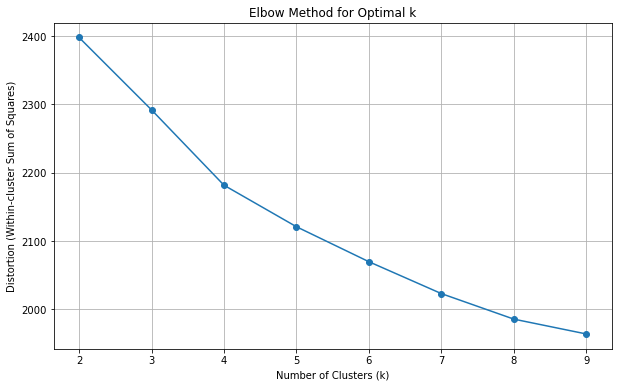

In [110]:
res = kmeans_func(df_cluster_short, 9)

In [111]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        69.000000         15.175362         1001.449275          1878.260870
1        42.000000         12.773810         1015.476190          1995.238095
2        48.000000         15.008333          941.666667          1950.000000
3        86.000000         13.612791         1139.534884          2587.790698
4        55.000000         12.654545          913.636364          2000.909091
5        85.000000         13.045882         1028.823529          1961.764706
6        64.000000         14.462500         1260.156250          2262.500000
7        38.000000         14.486842         1001.315789          2031.578947
8        34.000000         14.535294         1019.117647          2486.764706
average  57.888889         13.972818         1035.686288          2128.311901
Variable: city_Moscow

Frequenc

##### Описание кластеров для kmeans_func(df_cluster_short, 9) -------------
ПЛОХО ВЫРАЖЕННЫЕ КЛАСТЕРЫ

0    36.0  мало всего, рег Sales_preference_regional How_choose_brand_buy_only_known_brand Style_var_1 Style_var_4
№№№ СВОИ МЕСТНЫЕ БРЕНДЫ ПРОСТОЙ ДИЗАЙН

1    56.0  price-opinion_Check_price_new_goods buying_criteria_milk_some_love_brands How_choose_brand_buy_lovely_brand 
№№№ ЛЮБИМЫЕ МАРКИ

2    57.0    много масла, city_Moscow  price-opinion_Check_price_sometimes buy_novelty_Like_buy_new Sales_preference_village How_choose_brand_buy_known_brand Eco_fans 
№№№ ВЫСОКОЕ ПОТРЕБЛЕНИЕ И ЛЮБОВЬ К ЭКО И ДЕРЕВЕНСКОМУ

3    65.0   Рег, buy_novelty_Buy_new_sales How_choose_brand_buy_known_brand Eco_products_opinion_Fake Eco_fans_not
№№№ НЕ ЛЮБЯТ ЭКО ЛЮБЯТ СКИДКИ И ЗНАКОМЫЕ МАРКИ

4    77.0     buy_novelty_Buy_new_sales Sales_preference_no_preference How_choose_brand_buy_any_discount_brand
№№№ ВСЕ ПО СКИДКАМ

5    51.0   city_S_Peterburg price-opinion_Check_price_sometimes buy_novelty_Buy_new_sales buying_criteria_milk_fresh Style_var_2 Style_var_6 Eco_fans_not
№№№ ПЕЙЗАЖ ДИЗАЙН ПРАГМАТИКИ

6    49.0   много молока, city_Moscow  buy_novelty_Buy_new_interest How_choose_brand_buy_only_known_brand Style_var_5 №№№№ 

7    74.0    много молока, price-opinion_Check_price_new_goods buying_criteria_milk_love_brand Style_var_5 Eco_fans

8    56.0   city_Moscow   buying_criteria_milk_some_love_brands  How_choose_brand_buy_lovely_brand


Silhouette Score: 0.03415978288038387
Davies-Bouldin Index: 3.2669082981896573


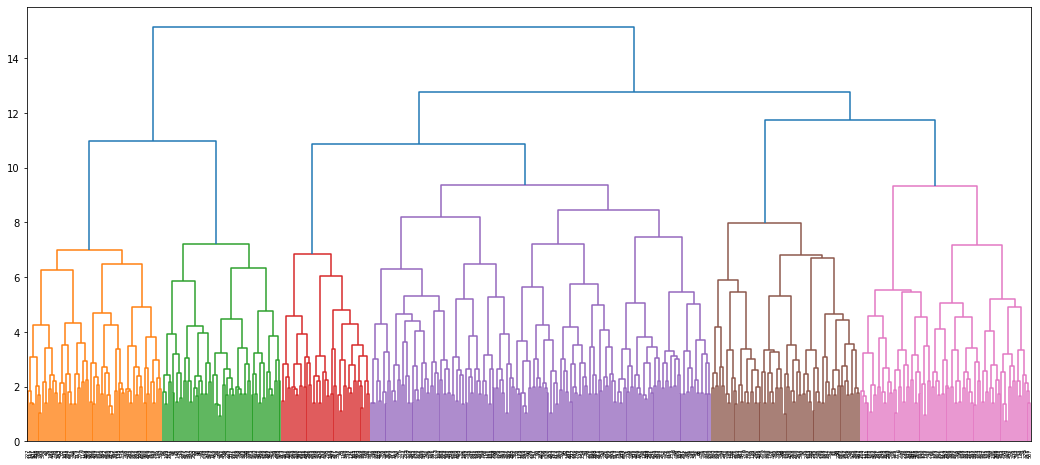

In [112]:
res = ac (df_cluster_short, 9, 'ward')

In [113]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
           label  milk_consumption  butter_consumption  smetana_consumption
label                                                                      
0        102.000         14.276471         1004.901961          2392.647059
1         77.000         14.875325          977.272727          2092.857143
2         75.000         12.249333         1148.666667          2114.000000
3         52.000         13.307692         1139.423077          1998.076923
4         70.000         12.997143          950.000000          1942.142857
5         46.000         14.817391         1145.652174          1904.347826
6         62.000         14.600000         1047.580645          2064.516129
7         37.000         14.621622         1045.945946          2532.432432
average   65.125         13.968122         1057.430400          2130.127546
Variable: city_Moscow

Frequency Table:
Cluster         0     1     2     3     4     5     6     7  R_Mean
city_Moscow            

Silhouette Score: 0.03787671172550555
Davies-Bouldin Index: 3.04335693228031


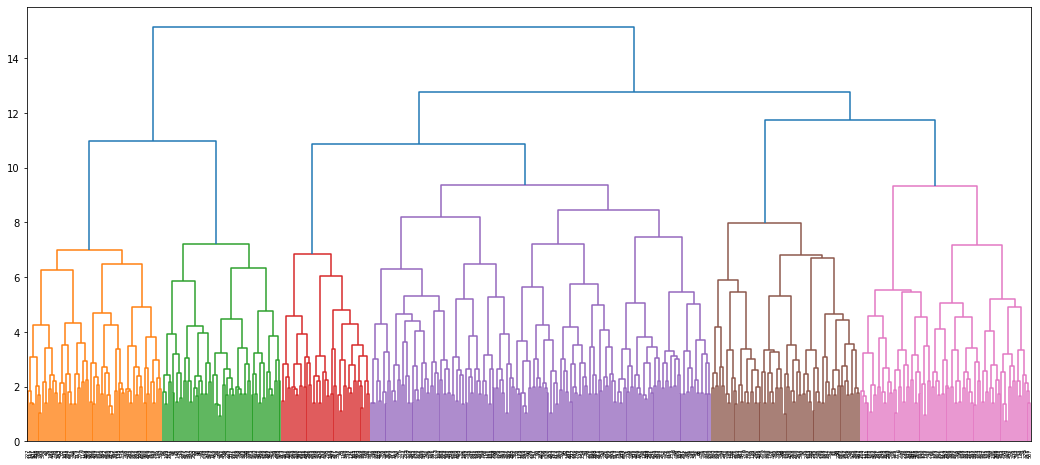

In [114]:
res = ac (df_cluster_short, 8, 'ward')

In [115]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
         label  milk_consumption  butter_consumption  smetana_consumption
label                                                                    
0         77.0         14.875325          977.272727          2092.857143
1         53.0         13.737736          945.283019          1980.188679
2         49.0         14.859184         1069.387755          2838.775510
3         52.0         13.307692         1139.423077          1998.076923
4         70.0         12.997143          950.000000          1942.142857
5         46.0         14.817391         1145.652174          1904.347826
6         62.0         14.600000         1047.580645          2064.516129
7         37.0         14.621622         1045.945946          2532.432432
8         33.0         11.030303         1180.303030          2286.363636
9         42.0         13.207143         1123.809524          1978.571429
average   52.1         13.805354         1062.465790          2161.827257
Varia

In [116]:
min_cluster_size_values = [2, 5, 10, 15, 20, 25]
min_samples = 2

results = hdbscan_clustering_brief(df_cluster_short, min_cluster_size_values, min_samples)

Results for min_cluster_size=2:
{'min_cluster_size': 2, 'num_variables_in_clusters': 50, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 333 observations
Cluster 46: 31 observations
Cluster 24: 11 observations
Cluster 38: 8 observations
Cluster 23: 7 observations
Cluster 16: 7 observations
Cluster 20: 7 observations
Cluster 12: 6 observations
Cluster 9: 5 observations
Cluster 44: 5 observations
Cluster 36: 5 observations
Cluster 21: 4 observations
Cluster 4: 3 observations
Cluster 28: 3 observations
Cluster 14: 3 observations
Cluster 31: 3 observations
Cluster 45: 3 observations
Cluster 40: 3 observations
Cluster 48: 3 observations
Cluster 35: 3 observations
Cluster 30: 3 observations
Cluster 0: 3 observations
Cluster 22: 3 observations
Cluster 29: 3 observations
Cluster 42: 3 observations
Cluster 32: 3 observations
Cluster 19: 3 observations
Cluster 5: 3 observations
Cluster 25: 2 observations
Cluster 3: 2 observations
Cluster 13: 2 observations
Cluster 17: 2 obs

hdbscan дает очень неровные по количеству кластеры

##### Вариант 2: убираем "слабые" бинарные переменные 
Экспертный отбор: удаляю переменные целиком в которых меньше различий между вариантами ответов (по предварительным рассчетам значения одинаковы для разных кластеров) - уточнить эту мысль

In [117]:
to_remove = ['how_to_shopping_once_month', 'how_to_shopping_once_week_only', 
             'how_to_shopping_once_week_plus', 'how_to_shopping_twice_week', 
             'One_brand_different_goods_may_be', 'One_brand_different_goods_no_depend',
              'Eco_products_opinion_Better_rare',
             'Eco_products_opinion_Fake', 'Eco_products_opinion_Same',
             'price-opinion_Dont_check_price', 'buy_novelty_Dont_buy_new', 'buy_novelty_Like_buy_new', 
             'Sales_preference_national']

df_cluster_high = df_cluster_5.drop(columns=to_remove)

In [118]:
df_cluster_high.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   city_Moscow                              521 non-null    uint8  
 1   city_S_Peterburg                         521 non-null    uint8  
 2   price-opinion_Check_price_new_goods      521 non-null    uint8  
 3   price-opinion_Check_price_sometimes      521 non-null    uint8  
 4   buy_novelty_Buy_new_interest             521 non-null    uint8  
 5   buy_novelty_Buy_new_sales                521 non-null    uint8  
 6   buying_criteria_milk_by_price            521 non-null    uint8  
 7   buying_criteria_milk_fresh               521 non-null    uint8  
 8   buying_criteria_milk_love_brand          521 non-null    uint8  
 9   buying_criteria_milk_price_first         521 non-null    uint8  
 10  buying_criteria_milk_some_love_brands    521 non-n

New data has 29 variables.
Check claster analysis variants


Number of clusters: 2, Silhouette Score: 0.07, Davies-Bouldin Index: 3.62
Number of clusters: 3, Silhouette Score: 0.06, Davies-Bouldin Index: 3.55
Number of clusters: 4, Silhouette Score: 0.06, Davies-Bouldin Index: 3.28
Number of clusters: 5, Silhouette Score: 0.07, Davies-Bouldin Index: 2.97
Number of clusters: 6, Silhouette Score: 0.06, Davies-Bouldin Index: 3.19
Number of clusters: 7, Silhouette Score: 0.06, Davies-Bouldin Index: 3.05
Number of clusters: 8, Silhouette Score: 0.06, Davies-Bouldin Index: 3.01
Number of clusters: 9, Silhouette Score: 0.06, Davies-Bouldin Index: 2.95
Number of clusters: 10, Silhouette Score: 0.06, Davies-Bouldin Index: 2.92
Number of clusters: 11, Silhouette Score: 0.05, Davies-Bouldin Index: 2.87
Number of clusters: 12, Silhouette Score: 0.06, Davies-Bouldin Index: 2.77
Number of clusters: 13, Silhouette Score: 0.06, Davies-Bouldin Index: 2.71
Number of clusters: 14, Silhouette Score: 0.06, Davies-Bouldin Index: 2.73
Number of clusters: 15, Silhouett

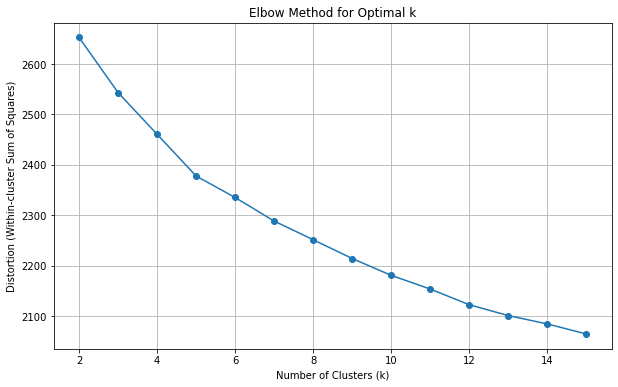

In [119]:
res = kmeans_func(df_cluster_high, 15)

Number of clusters: 2, Silhouette Score: 0.07, Davies-Bouldin Index: 3.62
Number of clusters: 3, Silhouette Score: 0.06, Davies-Bouldin Index: 3.55
Number of clusters: 4, Silhouette Score: 0.06, Davies-Bouldin Index: 3.28
Number of clusters: 5, Silhouette Score: 0.07, Davies-Bouldin Index: 2.97
Number of clusters: 6, Silhouette Score: 0.06, Davies-Bouldin Index: 3.19
Number of clusters: 7, Silhouette Score: 0.06, Davies-Bouldin Index: 3.05
Number of clusters: 8, Silhouette Score: 0.06, Davies-Bouldin Index: 3.01
Number of clusters: 9, Silhouette Score: 0.06, Davies-Bouldin Index: 2.95


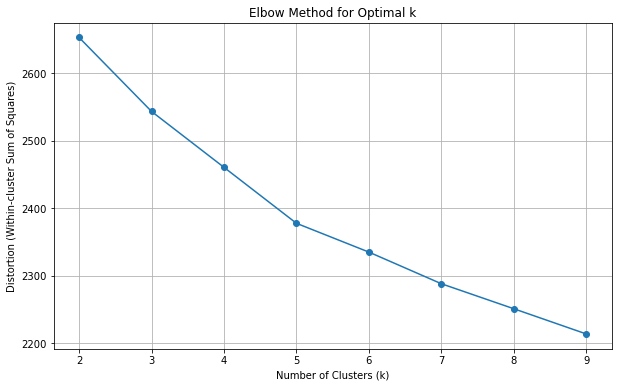

In [120]:
res = kmeans_func(df_cluster_high, 9)

In [121]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        59.000000         14.233898         1016.101695          1738.135593
1        59.000000         14.445763          963.559322          1998.305085
2        76.000000         13.413158         1034.210526          1959.210526
3        59.000000         13.372881          911.864407          1968.644068
4        56.000000         14.296429         1279.464286          2189.285714
5        77.000000         12.580519         1098.051948          2646.103896
6        47.000000         13.965957         1023.404255          2291.489362
7        34.000000         12.602941          955.882353          1855.882353
8        54.000000         16.577778         1111.111111          2412.037037
average  57.888889         13.943258         1043.738878          2117.677070
Variable: city_Moscow

Frequenc

Silhouette Score: 0.035453001922570955
Davies-Bouldin Index: 3.535986360720961


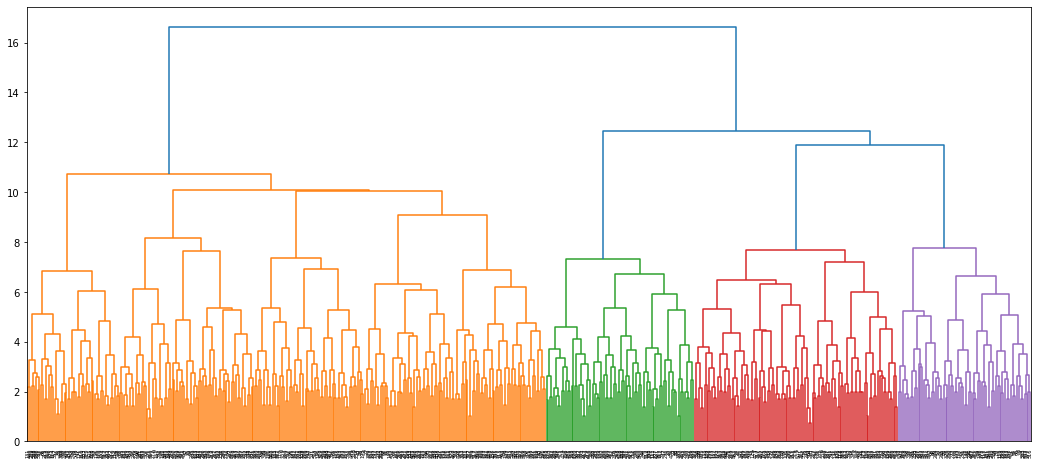

In [122]:
res = ac (df_cluster_high, 9.5, 'ward')

In [123]:
clusters_describe_func (res)
create_cluster_frequency_tables(df_cluster_5, res)

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0         94.000000         14.084043         1261.702128          2488.829787
1         69.000000         15.711594         1021.014493          2058.695652
2         70.000000         14.144286          945.714286          2034.285714
3        106.000000         13.086792         1027.830189          1937.264151
4         48.000000         13.933333          986.458333          1810.416667
5         77.000000         13.925974         1005.194805          2181.168831
6         57.000000         12.692982         1000.877193          2356.140351
average   74.428571         13.939858         1035.541632          2123.828736
Variable: city_Moscow

Frequency Table:
Cluster         0     1     2     3     4     5     6  R_Mean
city_Moscow                                                  
0            

Предположительно такая разбивка хуже чем предыдущая. Менее выраженные кластеры


In [124]:
min_cluster_size_values = [2, 3, 4, 5, 6, 7, 8]
min_samples = 3

results = hdbscan_clustering_brief(df_cluster_high, 
                                   min_cluster_size_values, min_samples)

Results for min_cluster_size=2:
{'min_cluster_size': 2, 'num_variables_in_clusters': 6, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster 4: 256 observations
Cluster -1: 255 observations
Cluster 3: 4 observations
Cluster 0: 2 observations
Cluster 2: 2 observations
Cluster 1: 2 observations


Results for min_cluster_size=3:
{'min_cluster_size': 3, 'num_variables_in_clusters': 5, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 316 observations
Cluster 3: 195 observations
Cluster 0: 4 observations
Cluster 1: 3 observations
Cluster 2: 3 observations


Results for min_cluster_size=4:
{'min_cluster_size': 4, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 261 observations
Cluster 1: 256 observations
Cluster 0: 4 observations


Results for min_cluster_size=5:
{'min_cluster_size': 5, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 398 observations
Cl

In [125]:
min_cluster_size_values = [4]
min_samples = 3

results = hdbscan_clustering(df_cluster_high, 
                                   min_cluster_size_values, min_samples)

Results for min_cluster_size=4:
{'min_cluster_size': 4, 'silhouette_score': -0.016656082277087033, 'num_variables_in_clusters': 3, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 314 observations
Cluster 1: 203 observations
Cluster 0: 4 observations




##### Автоматический отбор 

Отбираем из максимального числа переменных, только те, которые не ниже определенного уровеня положительных ответов 

In [126]:
def selected_level(df_level, level):
    selected_columns = df_level.columns[df_level.mean() >= level]
    selected_df = df_level[selected_columns].copy()
    return selected_df

In [127]:
df.head()

Number       id gender  birth_day  birth_month  birth_year  how_old  \
0       1  1161185      m         12            7        1979       36   
1       2  1161192      m          3            7        1973       42   
2       3  1161201      m         29            6        1980       35   
3       4  1161206      m         20            4        1974       42   
4       5  1161218      m          1            6        1977       38   

  age_type           city income  ...  youngest_year youngest_month have_cat  \
0    36_45         Moscow    Mid  ...            9.0            3.0        0   
1    36_45         Moscow   Mid-  ...            2.0            3.0        0   
2    25_35  Elkaterinburg    Mid  ...            6.0            0.0        1   
3    36_45  Elkaterinburg   Mid-  ...            NaN            NaN        0   
4    36_45    S_Peterburg   Mid+  ...            2.0            0.0        1   

  have_dog have_other havnt_pet     have_other.1 milk_consumption  \
0        0          0         1              NaN              2.0   
1        0          0         1              NaN              4.0   
2        0          1         0  черепаха, рыбки             20.0   
3        0          0         1              NaN             15.0   
4        0          0         0              NaN             10.0   

  butter_consumption smetana_consumption  
0                300                 450  
1                400                1200  
2                600                2000  
3                600                2500  
4               1000                5000  

[5 rows x 473 columns]

In [128]:
# вычисляем процент респондентов и зкаждого города
df.groupby('city')['city'].count()/521*100

city
Elkaterinburg    30.326296
Moscow           39.731286
S_Peterburg      29.942418
Name: city, dtype: float64

##### Выбор уровня отбора переменных

Использую как ориентир уровень жителей городов (минимальное значение 29,24) с некоторым запасом: 0.25

- Подготовим исходный массив
- Проведем фильтрацию
- 

In [129]:
df_cluster.info()
df_design.info()
df_try.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   city_Moscow                              521 non-null    uint8  
 1   city_S_Peterburg                         521 non-null    uint8  
 2   how_to_shopping_once_month               521 non-null    uint8  
 3   how_to_shopping_once_week_only           521 non-null    uint8  
 4   how_to_shopping_once_week_plus           521 non-null    uint8  
 5   how_to_shopping_twice_week               521 non-null    uint8  
 6   price-opinion_Check_price_new_goods      521 non-null    uint8  
 7   price-opinion_Check_price_sometimes      521 non-null    uint8  
 8   price-opinion_Dont_check_price           521 non-null    uint8  
 9   buy_novelty_Buy_new_interest             521 non-null    uint8  
 10  buy_novelty_Buy_new_sales                521 non-n

In [130]:
#### Удаляю одну переменную, чтобы не было чтобы избежать ловушки "фиктивных переменных" (dummy variable trap)
### В блоке df_design ранее были исключены варианты Style_var_No, StyleNo_var_No 
df_try_cl = df_try.drop('rty_nothing', axis=1)


In [131]:
### удаляю факторы рассчитыванные для переменных try_. Будем использовать исходные данные
df_cluster_cl = df_cluster.drop(['Eco_fans', 'Price', 'Brand_lovers', 'By_mood','Quality_only'], axis=1)



In [132]:
df_cluster_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   city_Moscow                              521 non-null    uint8
 1   city_S_Peterburg                         521 non-null    uint8
 2   how_to_shopping_once_month               521 non-null    uint8
 3   how_to_shopping_once_week_only           521 non-null    uint8
 4   how_to_shopping_once_week_plus           521 non-null    uint8
 5   how_to_shopping_twice_week               521 non-null    uint8
 6   price-opinion_Check_price_new_goods      521 non-null    uint8
 7   price-opinion_Check_price_sometimes      521 non-null    uint8
 8   price-opinion_Dont_check_price           521 non-null    uint8
 9   buy_novelty_Buy_new_interest             521 non-null    uint8
 10  buy_novelty_Buy_new_sales                521 non-null    uint8
 11  buy_no

In [133]:
df_design_cl = df_design.astype(bool)

In [134]:
df_design_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Style_var_1     521 non-null    bool 
 1   Style_var_2     521 non-null    bool 
 2   Style_var_3     521 non-null    bool 
 3   Style_var_4     521 non-null    bool 
 4   Style_var_5     521 non-null    bool 
 5   Style_var_6     521 non-null    bool 
 6   Style_var_7     521 non-null    bool 
 7   Style_var_8     521 non-null    bool 
 8   Style_var_9     521 non-null    bool 
 9   Style_var_10    521 non-null    bool 
 10  Style_var_11    521 non-null    bool 
 11  Style_var_12    521 non-null    bool 
 12  Style_var_13    521 non-null    bool 
 13  Style_var_14    521 non-null    bool 
 14  StyleNo_var_1   521 non-null    bool 
 15  StyleNo_var_2   521 non-null    bool 
 16  StyleNo_var_3   521 non-null    bool 
 17  StyleNo_var_4   521 non-null    bool 
 18  StyleNo_var_5   521 non-null  

In [135]:
df_try_cl = df_try_cl.astype(bool)

In [136]:
df_try_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   try_hero       521 non-null    bool 
 1   try_ecology    521 non-null    bool 
 2   try_price      521 non-null    bool 
 3   try_pack       521 non-null    bool 
 4   try_ads        521 non-null    bool 
 5   try_advise     521 non-null    bool 
 6   try_recipe     521 non-null    bool 
 7   try_color      521 non-null    bool 
 8   try_name       521 non-null    bool 
 9   try_eyesstop   521 non-null    bool 
 10  try_quality    521 non-null    bool 
 11  try_brand      521 non-null    bool 
 12  try_expencive  521 non-null    bool 
 13  try_foodzone   521 non-null    bool 
 14  try_design     521 non-null    bool 
 15  try_solid      521 non-null    bool 
dtypes: bool(16)
memory usage: 8.3 KB


In [137]:
#отбор переменных с уровнем 0,25

selected_level_df =  pd.concat([df_cluster_cl, df_design_cl, df_try_cl], axis=1)
selected_level_work = selected_level (selected_level_df, 0.25)
selected_level_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   city_Moscow                            521 non-null    uint8
 1   city_S_Peterburg                       521 non-null    uint8
 2   how_to_shopping_once_week_plus         521 non-null    uint8
 3   how_to_shopping_twice_week             521 non-null    uint8
 4   price-opinion_Check_price_sometimes    521 non-null    uint8
 5   buy_novelty_Buy_new_interest           521 non-null    uint8
 6   buy_novelty_Buy_new_sales              521 non-null    uint8
 7   buying_criteria_milk_some_love_brands  521 non-null    uint8
 8   One_brand_different_goods_may_be       521 non-null    uint8
 9   Sales_preference_no_preference         521 non-null    uint8
 10  How_choose_brand_buy_known_brand       521 non-null    uint8
 11  Eco_products_opinion_Fake       

##### Варианты классификации для наиболее популярных переменных

С долей ответов выше 25%

Number of clusters: 2, Silhouette Score: 0.07, Davies-Bouldin Index: 3.56
Number of clusters: 3, Silhouette Score: 0.06, Davies-Bouldin Index: 3.34
Number of clusters: 4, Silhouette Score: 0.06, Davies-Bouldin Index: 3.37
Number of clusters: 5, Silhouette Score: 0.05, Davies-Bouldin Index: 3.37
Number of clusters: 6, Silhouette Score: 0.05, Davies-Bouldin Index: 3.02
Number of clusters: 7, Silhouette Score: 0.05, Davies-Bouldin Index: 3.05
Number of clusters: 8, Silhouette Score: 0.05, Davies-Bouldin Index: 3.1
Number of clusters: 9, Silhouette Score: 0.05, Davies-Bouldin Index: 2.79


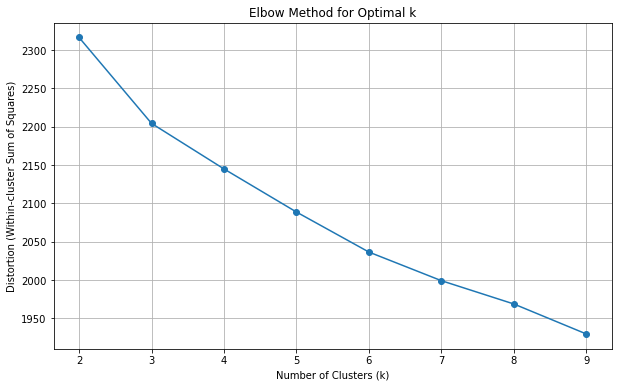

In [138]:
res = kmeans_func(selected_level_work, 9)

In [139]:
clusters_describe_func (res)
create_cluster_frequency_tables(selected_level_df, res)

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        63.000000         13.444444         1029.365079          2034.920635
1        51.000000         14.970588         1070.588235          2422.549020
2        61.000000         14.032787          921.311475          2213.114754
3        40.000000         15.762500          976.250000          2145.000000
4        59.000000         14.018644         1038.135593          2325.423729
5        66.000000         13.524242         1090.909091          2195.454545
6        58.000000         12.994828         1248.275862          2037.068966
7        55.000000         11.496364          990.909091          1557.272727
8        68.000000         15.400000         1046.323529          2271.323529
average  57.888889         13.960489         1045.785329          2133.569767
Variable: city_Moscow

Frequenc

Silhouette Score: 0.009075717596961231
Davies-Bouldin Index: 5.0026933711698005


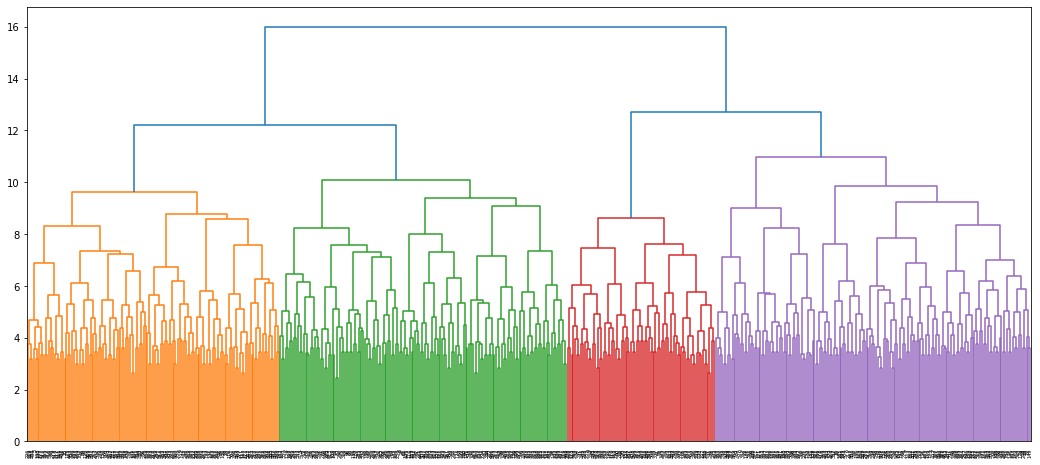

In [140]:
res = ac (selected_level_df, 9.5, 'ward')

In [141]:
clusters_describe_func (res)
create_cluster_frequency_tables(selected_level_df, res)

Size and consumption in clasters
          label  milk_consumption  butter_consumption  smetana_consumption
label                                                                     
0        87.000         13.427586          999.425287          2000.000000
1        86.000         11.954651         1052.906977          2188.372093
2        77.000         14.753247         1090.909091          2481.818182
3        69.000         14.686957          941.304348          1839.855072
4        52.000         14.278846         1167.307692          2130.769231
5        62.000         14.854839         1037.096774          2136.290323
6        26.000         14.269231          965.384615          1817.307692
7        62.000         14.027419         1120.161290          2292.741935
average  65.125         14.031597         1046.812009          2110.894316
Variable: city_Moscow

Frequency Table:
Cluster         0     1     2     3     4     5     6     7  R_Mean
city_Moscow                       

In [142]:
#min_cluster_size_values = [2, 3, 4, 5, 6, 7, 8]
in_cluster_size_values = [2, 5, 8, 10, 15, 20]
min_samples = 3

results = hdbscan_clustering_brief(selected_level_df, 
                                   min_cluster_size_values, min_samples)

Results for min_cluster_size=4:
{'min_cluster_size': 4, 'num_variables_in_clusters': 5, 'num_variables_not_in_clusters': 0}

Cluster Information:
Cluster -1: 426 observations
Cluster 2: 81 observations
Cluster 0: 6 observations
Cluster 3: 4 observations
Cluster 1: 4 observations





**описание для ac (selected_level_df, 9.5, 'ward')**

0    94.0  много масла и сметаны, price-opinion_Check_price_new_goods\37 price-opinion_Dont_check_price/5 buying_criteria_milk_some_love_brands Sales_preference_regional/21 Sales_preference_village/21
How_choose_brand_buy_lovely_brand/54
Eco_products_opinion_Better_buy/24 
Style_var_5/50
ПОТРЕБИТЕЛИ ДОРОГИХ ДЕРЕВЕНСКИХ И ЭКОПРОДУКТОВ В ДОРОГОМ СТИЛЕ
   

1    69.0   много молока, спб,  buy_novelty_Buy_new_sales  buying_criteria_milk_fresh/62 
How_choose_brand_buy_lovely_brand/40 
Style_var_6/39
НЕТ ЯВНЫХ ОСОБЕННОСТЕЙ КРОМЕ СТИЛЯ 6 И ПИТЕРА

2    70.0   price-opinion_Check_price_new_goods\42  buy_novelty_Buy_new_interest/49  buying_criteria_milk_love_brand Sales_preference_no_preference/38 
How_choose_brand_buy_lovely_brand/53
Style_var_5/67 
НЕТ ЯРКИХ ОСОБЕННОСТЕЙ ЛЮБОПЫТНЫЕ, НЕ ЭКОНОМЯТ, 

3   106.0  мос  buy_novelty_Buy_new_sales buying_criteria_milk_by_price/24  Sales_preference_no_preference/45 
Sales_preference_regional/16
How_choose_brand_buy_known_brand/88
Style_var_5/58
РСПРОДАЖИ, РЕГИОНЫ И ИЗВЕСТНЫЕ БРЕНДЫ НЕ ЯРКО


4    48.0   мос   how_to_shopping_once_month(15) price-opinion_Check_price_sometimes buy_novelty_Buy_new_interest buying_criteria_milk_price_first/20 buying_criteria_milk_some_love_brands/42 Sales_preference_national/31  Sales_preference_regional/21
How_choose_brand_buy_only_known_brand/85!!!
Style_var_4/46
РЕДКИЕ ЗАКУПКИ И ТОЛЬКО ИЗВЕСТНЫХ БРЕНДОВ

5    77.0   buy_novelty_Buy_new_sales    buying_criteria_milk_by_price/29 buying_criteria_milk_price_first/27  Sales_preference_no_preference/44  How_choose_brand_buy_any_discount_brand/95!!!!
Eco_products_opinion_Better_dont_buy/35 
ВСЕ ПО СКИДКАМ ЭКО НЕ НУЖНО

6    57.0   мало молока много сметаны, price-opinion_Check_price_sometimes/42  buy_novelty_Buy_new_interest 
Sales_preference_village/31 How_choose_brand_buy_known_brand/73!!!
ЛЮБОПЫТНЫЕ, ДЕРЕВЕНСКОЕ И ИЗВЕСТНЫЕ БРЕНДЫ


### ПОДРОБНЫЙ АНАЛИЗ СВОЙСТВ КЛАСТЕРОВ ПО НАИБОЛЕЕ ЭФФЕКТИВНЫМ МОДЕЛЯМ


#### ПРИОРИТЕТНЫЙ ВАРИАНТ - ПОДРОБНЫЙ АНАЛИЗ

k-means df_cluster_T  : 8

5 КЛАСТЕРОВ, ЭКОН РЕГ, МОС СОЛИДНО, ЭКО ГРАФ, СВЕЖЕСТЬ ДОРОГО, У ДОМА 


##### модель kmeans_func(df_cluster_5, 8)

Number of clusters: 2, Silhouette Score: 0.05, Davies-Bouldin Index: 4.13
Number of clusters: 3, Silhouette Score: 0.04, Davies-Bouldin Index: 4.04
Number of clusters: 4, Silhouette Score: 0.04, Davies-Bouldin Index: 4.01
Number of clusters: 5, Silhouette Score: 0.04, Davies-Bouldin Index: 3.83
Number of clusters: 6, Silhouette Score: 0.04, Davies-Bouldin Index: 3.6
Number of clusters: 7, Silhouette Score: 0.04, Davies-Bouldin Index: 3.51
Number of clusters: 8, Silhouette Score: 0.04, Davies-Bouldin Index: 3.41


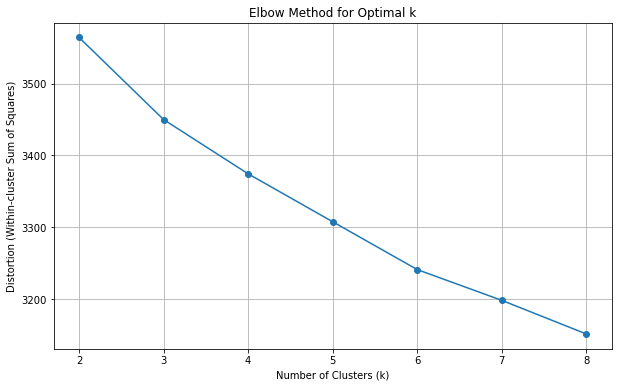

In [143]:
res = kmeans_func(df_cluster_5, 8)

In [144]:
create_cluster_frequency_tables(df, res)


Variable: gender

Frequency Table:
Cluster     0     1     2     3     4     5     6     7  R_Mean
gender                                                         
f        55.9  64.0  63.8  51.6  60.9  65.7  57.0  76.4    61.9
m        44.1  36.0  36.2  48.4  39.1  34.3  43.0  23.6    38.1


Variable: age_type

Frequency Table:
Cluster      0     1     2     3     4     5     6     7  R_Mean
age_type                                                        
25_35     59.8  44.0  48.3  42.2  41.3  65.7  49.4  41.8    49.1
36_45     40.2  56.0  51.7  57.8  58.7  34.3  50.6  58.2    50.9


Variable: city

Frequency Table:
Cluster           0     1     2     3     4     5     6     7  R_Mean
city                                                                 
Elkaterinburg  34.3  36.0  29.3  23.4  30.4  14.9  36.7  36.4    30.2
Moscow         15.7  42.0   8.6  57.8  50.0  82.1  36.7  38.2    41.4
S_Peterburg    50.0  22.0  62.1  18.8  19.6   3.0  26.6  25.5    28.4


Variable: income

Frequ

In [145]:
clusters_describe_func(res)

Size and consumption in clasters
           label  milk_consumption  butter_consumption  smetana_consumption
label                                                                      
0        102.000         12.842157          980.392157          2402.450980
1         50.000         13.632000         1091.000000          2274.000000
2         58.000         14.236207          989.655172          1697.413793
3         64.000         16.325000         1085.937500          2038.281250
4         46.000         13.080435          958.695652          1783.695652
5         67.000         13.246269         1269.402985          2183.582090
6         79.000         13.869620          926.582278          2055.696203
7         55.000         14.600000         1130.909091          2445.454545
average   65.125         13.978961         1054.071854          2110.071814


Выводы по kmeans_func(df_cluster_5, 8)


Кластеры не слишком характеры и недостаточно выраженны и различны.

Целесообразно попробовать другие методы


#### kmeans_func(df_cluster_short, 9)

Пробуем вариант имеющий макс значение Silhouette

c 4мя кластерами

Number of clusters: 2, Silhouette Score: 0.07, Davies-Bouldin Index: 3.47
Number of clusters: 3, Silhouette Score: 0.06, Davies-Bouldin Index: 3.51
Number of clusters: 4, Silhouette Score: 0.09, Davies-Bouldin Index: 2.92


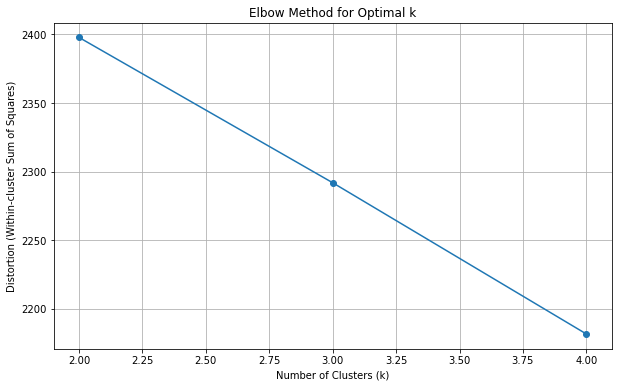

In [146]:
res = kmeans_func(df_cluster_short, 4)

In [147]:
clusters_describe_func(res)

Size and consumption in clasters
          label  milk_consumption  butter_consumption  smetana_consumption
label                                                                     
0        115.00         14.098261          943.043478          1901.739130
1        144.00         14.375000         1092.361111          2361.111111
2        101.00         13.458416         1056.930693          2130.693069
3        161.00         13.660248         1077.639752          2105.590062
average  130.25         13.897981         1042.493758          2124.783343


In [148]:
create_cluster_frequency_tables(df, res)

Variable: gender

Frequency Table:
Cluster     0     1     2     3  R_Mean
gender                                 
f        60.0  57.6  59.4  65.8    60.7
m        40.0  42.4  40.6  34.2    39.3


Variable: age_type

Frequency Table:
Cluster      0     1     2     3  R_Mean
age_type                                
25_35     50.4  57.6  41.6  49.7    49.8
36_45     49.6  42.4  58.4  50.3    50.2


Variable: city

Frequency Table:
Cluster           0     1     2     3  R_Mean
city                                         
Elkaterinburg  28.7  30.6  31.7  30.4    30.4
Moscow         39.1  32.6  43.6  44.1    39.8
S_Peterburg    32.2  36.8  24.8  25.5    29.8


Variable: income

Frequency Table:
Cluster     0     1     2     3  R_Mean
income                                 
High      NaN   4.9   3.0   0.6     2.8
Low       2.6   5.6   6.9   1.2     4.1
Mid      42.6  48.6  47.5  50.3    47.2
Mid+     22.6  20.8  15.8  22.4    20.4
Mid-     32.2  20.1  26.7  25.5    26.1


Variable: work_typ

Number of clusters: 2, Silhouette Score: 0.04, Davies-Bouldin Index: 4.45
Number of clusters: 3, Silhouette Score: 0.04, Davies-Bouldin Index: 4.41
Number of clusters: 4, Silhouette Score: 0.04, Davies-Bouldin Index: 4.22
Number of clusters: 5, Silhouette Score: 0.03, Davies-Bouldin Index: 4.13
Number of clusters: 6, Silhouette Score: 0.03, Davies-Bouldin Index: 3.83


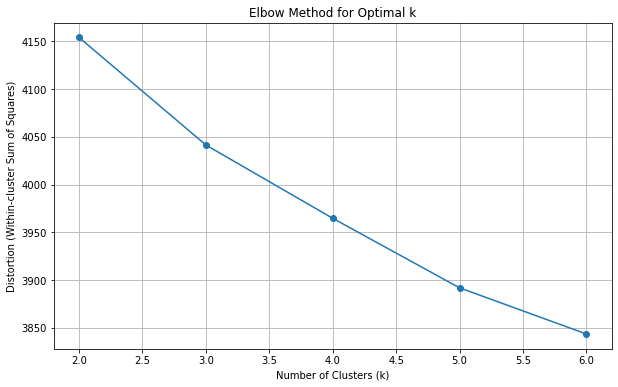

In [149]:
res = kmeans_func(df_cluster_14, 6)

In [150]:
clusters_describe_func(res)
create_cluster_frequency_tables(df, res)

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        70.000000         15.085714          977.857143          2063.571429
1        89.000000         12.848315          993.258427          1901.685393
2        94.000000         14.628723         1159.574468          2476.595745
3        95.000000         13.533684         1076.315789          2211.052632
4        86.000000         13.774419         1087.209302          2065.116279
5        87.000000         13.850575          970.114943          2054.597701
average  86.833333         13.953572         1044.055012          2128.769863
Variable: gender

Frequency Table:
Cluster     0     1     2     3     4     5  R_Mean
gender                                             
f        62.9  52.8  58.5  65.3  60.5  66.7    61.1
m        37.1  47.2  41.5  34.7  39.5  33.3    38.9


Variable: age_type



In [151]:
cl = pd.DataFrame({'Cluster': res})
df_d = pd.concat([df, cl], axis=1)

In [152]:
df_d.head()

Number       id gender  birth_day  birth_month  birth_year  how_old  \
0       1  1161185      m         12            7        1979       36   
1       2  1161192      m          3            7        1973       42   
2       3  1161201      m         29            6        1980       35   
3       4  1161206      m         20            4        1974       42   
4       5  1161218      m          1            6        1977       38   

  age_type           city income  ...  youngest_month have_cat have_dog  \
0    36_45         Moscow    Mid  ...             3.0        0        0   
1    36_45         Moscow   Mid-  ...             3.0        0        0   
2    25_35  Elkaterinburg    Mid  ...             0.0        1        0   
3    36_45  Elkaterinburg   Mid-  ...             NaN        0        0   
4    36_45    S_Peterburg   Mid+  ...             0.0        1        0   

  have_other havnt_pet     have_other.1 milk_consumption butter_consumption  \
0          0         1              NaN              2.0                300   
1          0         1              NaN              4.0                400   
2          1         0  черепаха, рыбки             20.0                600   
3          0         1              NaN             15.0                600   
4          0         0              NaN             10.0               1000   

  smetana_consumption Cluster  
0                 450       1  
1                1200       4  
2                2000       5  
3                2500       3  
4                5000       2  

[5 rows x 474 columns]

In [153]:
print(df_d.groupby('Cluster')['how_old'].mean())

Cluster
0    34.571429
1    34.426966
2    34.691489
3    34.652632
4    34.720930
5    35.758621
Name: how_old, dtype: float64


In [155]:
print((df_d.groupby('Cluster')['try_hero'].mean()*100).round(1))

Cluster
0    4.3
1    1.1
2    3.2
3    3.2
4    1.2
5    1.1
Name: try_hero, dtype: float64


In [158]:
#def try

columns = (        'try_hero', 'try_ecology', 'try_price', 'try_pack', 'try_ads', 
    'try_advise', 'try_recipe', 'try_color', 'try_name', 'try_eyesstop',
    'try_quality', 'try_brand', 'try_expencive', 'try_foodzone', 
    'try_design', 'try_solid', 'rty_nothing')
for column in columns:
    print(f"Column: {column}\n")
    print((df_d.groupby('Cluster')[column].mean() * 100).round(1))
   

Column: try_hero

Cluster
0    4.3
1    1.1
2    3.2
3    3.2
4    1.2
5    1.1
Name: try_hero, dtype: float64
Column: try_ecology

Cluster
0    40.0
1    47.2
2    20.2
3    29.5
4    12.8
5    13.8
Name: try_ecology, dtype: float64
Column: try_price

Cluster
0    70.0
1    16.9
2    26.6
3    49.5
4    82.6
5    66.7
Name: try_price, dtype: float64
Column: try_pack

Cluster
0    5.7
1    4.5
2    6.4
3    5.3
4    3.5
5    1.1
Name: try_pack, dtype: float64
Column: try_ads

Cluster
0     5.7
1     3.4
2     8.5
3    10.5
4    10.5
5     5.7
Name: try_ads, dtype: float64
Column: try_advise

Cluster
0    20.0
1    52.8
2    59.6
3    25.3
4    33.7
5    46.0
Name: try_advise, dtype: float64
Column: try_recipe

Cluster
0    14.3
1    22.5
2    11.7
3    18.9
4     8.1
5    13.8
Name: try_recipe, dtype: float64
Column: try_color

Cluster
0    2.9
1    1.1
2    0.0
3    4.2
4    1.2
5    1.1
Name: try_color, dtype: float64
Column: try_name

Cluster
0    1.4
1    1.1
2    2.1
3    4.2
4   

In [159]:
mean_vars = ('how_old', 'youngest_year', 'youngest_month')


for column in mean_vars:
    print(df_d.groupby('Cluster')[column].mean())
  


Cluster
0    34.571429
1    34.426966
2    34.691489
3    34.652632
4    34.720930
5    35.758621
Name: how_old, dtype: float64
Cluster
0    5.480769
1    4.896552
2    5.094595
3    5.754098
4    5.721311
5    5.428571
Name: youngest_year, dtype: float64
Cluster
0    4.846154
1    5.344828
2    5.716216
3    5.868852
4    5.344262
5    4.357143
Name: youngest_month, dtype: float64


In [160]:
#Расчет расходов в каждом кластере на основании данных о средних ценах на указанные продукты

milk_price = 51
butter_price = 477
smetana_price = 185

df['expenses'] = df['milk_consumption']*milk_price+df['butter_consumption']*butter_price/1000+df['smetana_consumption']*smetana_price/1000


In [161]:
df['expenses'].mean()

1604.7474088291733

In [162]:
df.head()

Number       id gender  birth_day  birth_month  birth_year  how_old  \
0       1  1161185      m         12            7        1979       36   
1       2  1161192      m          3            7        1973       42   
2       3  1161201      m         29            6        1980       35   
3       4  1161206      m         20            4        1974       42   
4       5  1161218      m          1            6        1977       38   

  age_type           city income  ...  youngest_month have_cat have_dog  \
0    36_45         Moscow    Mid  ...             3.0        0        0   
1    36_45         Moscow   Mid-  ...             3.0        0        0   
2    25_35  Elkaterinburg    Mid  ...             0.0        1        0   
3    36_45  Elkaterinburg   Mid-  ...             NaN        0        0   
4    36_45    S_Peterburg   Mid+  ...             0.0        1        0   

  have_other havnt_pet     have_other.1 milk_consumption butter_consumption  \
0          0         1              NaN              2.0                300   
1          0         1              NaN              4.0                400   
2          1         0  черепаха, рыбки             20.0                600   
3          0         1              NaN             15.0                600   
4          0         0              NaN             10.0               1000   

  smetana_consumption expenses  
0                 450   328.35  
1                1200   616.80  
2                2000  1676.20  
3                2500  1513.70  
4                5000  1912.00  

[5 rows x 474 columns]

In [163]:
#Расчет % каждого кластера в общей сумме расходов всех потребителей


df_describe = df.copy()
df_labels = pd.DataFrame(res, columns=['label'])
df_describe = pd.concat([df_describe, df_labels], axis=1)
#df_describe.groupby('label')['expenses'].sum()/df_describe.sum()*100
(df_describe.groupby('label')['expenses'].sum() / df_describe['expenses'].sum()) * 100


label
0    13.543057
1    15.763754
2    19.757966
3    18.324133
4    16.490191
5    16.120899
Name: expenses, dtype: float64

### кажется нигде нет вывода, что это оптимальный вариант

##### Пробую посмотреть понятность кластеров на базе кластеров по дизайну

Но начну с хитмэпа по дизайну и тру_


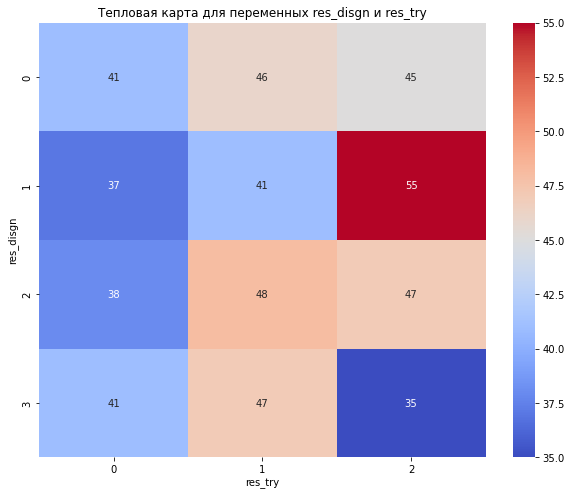

In [171]:
df_design_try = pd.DataFrame({'res_disgn': res_disgn, 'res_try': res_try})

plot_heatmap(df_design_try, 'res_disgn', 'res_try')

Мы видим, что распределение наблюдений сравнительно равномерное. Но можно отметить некоторые особенности:
- Те кто ориентируются на советы, не имеют приоритетов по дизайну
- Те кто за правильные продукты (эко и качество) менее склонны к пейзажному дизайну
- Те кто выбирает по цене, явно предпочитают пейзажный стиль в дизайне

**Описание дизайн кластеров**

In [172]:
create_cluster_frequency_tables(df, res_disgn)

Variable: gender

Frequency Table:
Cluster     0     1     2     3  R_Mean
gender                                 
f        68.2  63.9  54.1  57.7    61.0
m        31.8  36.1  45.9  42.3    39.0


Variable: age_type

Frequency Table:
Cluster      0     1     2     3  R_Mean
age_type                                
25_35     56.8  39.8  54.1  51.2    50.5
36_45     43.2  60.2  45.9  48.8    49.5


Variable: city

Frequency Table:
Cluster           0     1     2     3  R_Mean
city                                         
Elkaterinburg  28.8  23.3  33.8  35.8    30.4
Moscow         40.2  45.1  37.6  35.8    39.7
S_Peterburg    31.1  31.6  28.6  28.5    30.0


Variable: income

Frequency Table:
Cluster     0     1     2     3  R_Mean
income                                 
High      0.8   2.3   3.8   1.6     2.1
Low       6.8   1.5   2.3   4.9     3.9
Mid      43.9  48.1  46.6  52.0    47.6
Mid+     18.9  24.1  22.6  17.1    20.7
Mid-     29.5  24.1  24.8  24.4    25.7


Variable: work_typ

Анализ показал, что все кластеры кроме первого (более молодая аудитория) практически по всем показателям близки к средним значениям по всей выборке.

In [173]:
create_cluster_frequency_tables(df, res_try)

Variable: gender

Frequency Table:
Cluster     0     1     2  R_Mean
gender                           
f        61.8  56.6  64.8    61.1
m        38.2  43.4  35.2    38.9


Variable: age_type

Frequency Table:
Cluster      0     1     2  R_Mean
age_type                          
25_35     54.1  49.5  48.4    50.7
36_45     45.9  50.5  51.6    49.3


Variable: city

Frequency Table:
Cluster           0     1     2  R_Mean
city                                   
Elkaterinburg  31.8  26.4  33.0    30.4
Moscow         35.7  44.0  39.0    39.6
S_Peterburg    32.5  29.7  28.0    30.1


Variable: income

Frequency Table:
Cluster     0     1     2  R_Mean
income                           
High      1.3   3.8   1.1     2.1
Low       5.7   2.2   3.8     3.9
Mid      42.7  46.2  53.3    47.4
Mid+     19.1  26.4  16.5    20.7
Mid-     31.2  21.4  25.3    26.0


Variable: work_type

Frequency Table:
Cluster       0     1     2  R_Mean
work_type                          
5           NaN   1.1   NaN 

Анализ кластеров по try_ также показал отсутствие их особенностей на всем массиве данных

**Попытка кластеризации по дизайну и трай**

У нас получается кластеризация по кластеризации 3 кластера и 4 кластера. Поэтому 12 кластеров создают полную палитру вариантов
При этом мы получаем весьма равномерные кластеры по количеству 

Number of clusters: 2, Silhouette Score: 0.47, Davies-Bouldin Index: 0.91
Number of clusters: 3, Silhouette Score: 0.45, Davies-Bouldin Index: 0.86
Number of clusters: 4, Silhouette Score: 0.5, Davies-Bouldin Index: 0.82
Number of clusters: 5, Silhouette Score: 0.54, Davies-Bouldin Index: 0.92
Number of clusters: 6, Silhouette Score: 0.59, Davies-Bouldin Index: 0.94
Number of clusters: 7, Silhouette Score: 0.63, Davies-Bouldin Index: 0.75
Number of clusters: 8, Silhouette Score: 0.7, Davies-Bouldin Index: 0.55
Number of clusters: 9, Silhouette Score: 0.76, Davies-Bouldin Index: 0.57
Number of clusters: 10, Silhouette Score: 0.85, Davies-Bouldin Index: 0.41
Number of clusters: 11, Silhouette Score: 0.92, Davies-Bouldin Index: 0.35
Number of clusters: 12, Silhouette Score: 1.0, Davies-Bouldin Index: 0.0
Number of clusters: 13, Silhouette Score: 1.0, Davies-Bouldin Index: 0.0
Number of clusters: 14, Silhouette Score: 1.0, Davies-Bouldin Index: 0.0


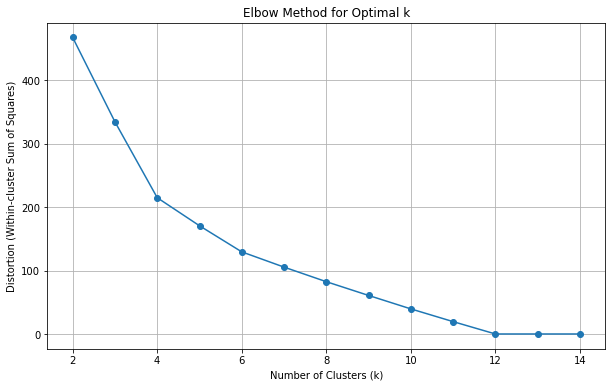

In [174]:
res = kmeans_func(df_design_try, 14)

Number of clusters: 2, Silhouette Score: 0.47, Davies-Bouldin Index: 0.91
Number of clusters: 3, Silhouette Score: 0.45, Davies-Bouldin Index: 0.86
Number of clusters: 4, Silhouette Score: 0.5, Davies-Bouldin Index: 0.82
Number of clusters: 5, Silhouette Score: 0.54, Davies-Bouldin Index: 0.92
Number of clusters: 6, Silhouette Score: 0.59, Davies-Bouldin Index: 0.94
Number of clusters: 7, Silhouette Score: 0.63, Davies-Bouldin Index: 0.75
Number of clusters: 8, Silhouette Score: 0.7, Davies-Bouldin Index: 0.55
Number of clusters: 9, Silhouette Score: 0.76, Davies-Bouldin Index: 0.57
Number of clusters: 10, Silhouette Score: 0.85, Davies-Bouldin Index: 0.41
Number of clusters: 11, Silhouette Score: 0.92, Davies-Bouldin Index: 0.35
Number of clusters: 12, Silhouette Score: 1.0, Davies-Bouldin Index: 0.0


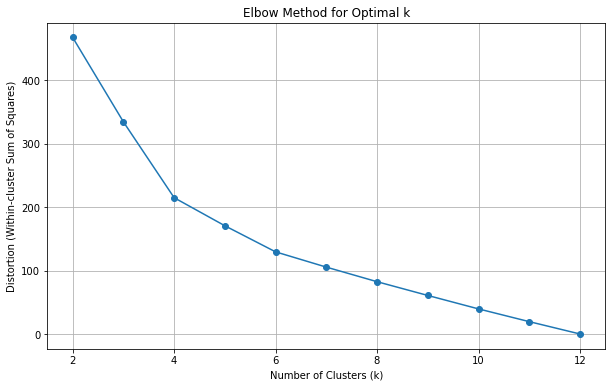

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        41.000000         15.165854          964.634146          1781.707317
1        47.000000         14.706383          931.914894          1905.319149
2        55.000000         13.321818          972.727273          2123.636364
3        48.000000         13.022917         1127.083333          2292.708333
4        46.000000         11.454348         1161.956522          2203.260870
5        47.000000         13.774468         1011.702128          1857.446809
6        45.000000         15.111111          896.666667          2214.444444
7        41.000000         12.712195          958.536585          2284.146341
8        41.000000         14.573171         1121.951220          2107.317073
9        38.000000         14.489474         1202.631579          2114.473684
10       37.000000         15.5

In [193]:
res = kmeans_func(df_design_try, 12)
clusters_describe_func(res)

In [194]:
#пробую сделать вариант с распределением на все 12 возможных кластеров
# посмотрим насколько они информативным



create_cluster_frequency_tables(df, res)

Variable: gender

Frequency Table:
Cluster     0     1     2     3     4     5     6     7     8     9    10  \
gender                                                                      
f        70.7  51.1  65.5  45.8  73.9  68.1  60.0  58.5  56.1  47.4  70.3   
m        29.3  48.9  34.5  54.2  26.1  31.9  40.0  41.5  43.9  52.6  29.7   

Cluster    11  R_Mean  
gender                 
f        65.7    61.1  
m        34.3    38.9  


Variable: age_type

Frequency Table:
Cluster      0     1     2     3     4     5     6     7     8     9    10  \
age_type                                                                     
25_35     63.4  44.7  36.4  58.3  47.8  51.1  60.0  61.0  46.3  52.6  37.8   
36_45     36.6  55.3  63.6  41.7  52.2  48.9  40.0  39.0  53.7  47.4  62.2   

Cluster     11  R_Mean  
age_type                
25_35     48.6    50.7  
36_45     51.4    49.3  


Variable: city

Frequency Table:
Cluster           0     1     2     3     4     5     6     7     8     9

Результат не слишком хороший, доля информативных кластеров по каждому вопросу менее 50% 

Number of clusters: 2, Silhouette Score: 0.47, Davies-Bouldin Index: 0.91
Number of clusters: 3, Silhouette Score: 0.45, Davies-Bouldin Index: 0.86
Number of clusters: 4, Silhouette Score: 0.5, Davies-Bouldin Index: 0.82
Number of clusters: 5, Silhouette Score: 0.54, Davies-Bouldin Index: 0.92
Number of clusters: 6, Silhouette Score: 0.59, Davies-Bouldin Index: 0.94


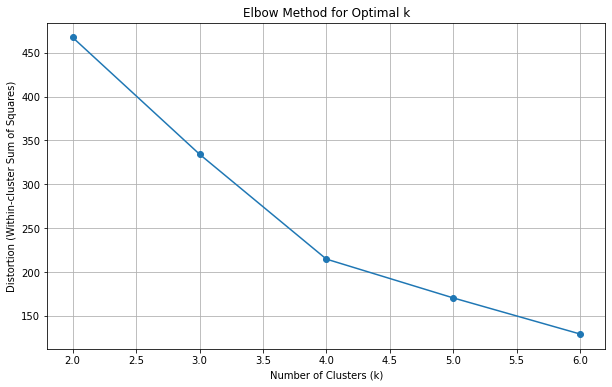

Size and consumption in clasters
              label  milk_consumption  butter_consumption  smetana_consumption
label                                                                         
0         82.000000         14.307317         1072.560976          2207.317073
1        100.000000         14.127000          938.500000          2164.500000
2         78.000000         15.324359         1001.282051          2004.487179
3         79.000000         13.567089         1075.949367          2202.531646
4         87.000000         12.924138         1143.103448          2158.045977
5         95.000000         13.394737         1070.000000          2077.368421
average   86.833333         13.940773         1050.232640          2135.708383


In [188]:
#пробую на 6 кластеров. После 6 снижение на графике линейное

res = kmeans_func(df_design_try, 6)
clusters_describe_func(res)

#состав кластеров достаточно однородный по количеству

In [189]:
#изучаю содержательную сторону кластеров

create_cluster_frequency_tables(df, res)

Variable: gender

Frequency Table:
Cluster     0     1     2     3     4     5  R_Mean
gender                                             
f        57.3  63.0  70.5  53.2  65.5  56.8    61.0
m        42.7  37.0  29.5  46.8  34.5  43.2    38.9


Variable: age_type

Frequency Table:
Cluster      0     1     2     3     4     5  R_Mean
age_type                                            
25_35     46.3  47.0  51.3  57.0  47.1  54.7    50.6
36_45     53.7  53.0  48.7  43.0  52.9  45.3    49.4


Variable: city

Frequency Table:
Cluster           0     1     2     3     4     5  R_Mean
city                                                     
Elkaterinburg  32.9  29.0  24.4  39.2  24.1  32.6    30.4
Moscow         37.8  39.0  43.6  27.8  46.0  43.2    39.6
S_Peterburg    29.3  32.0  32.1  32.9  29.9  24.2    30.1


Variable: income

Frequency Table:
Cluster     0     1     2     3     4     5  R_Mean
income                                             
High      1.2   1.0   NaN   2.5   3.4   

Данные лучше чем в предыдущем рассчете. Около половины кластеров в каждом вопросе выделяются относительно средних

**Пробую взять исходные компоненты для дизайна и предпочтений**
и построить кластеры на их основе

In [185]:
df_comp_design_try = pd.DataFrame(np.concatenate([design_components, try_components], axis=1), 
                                  columns=['design_components_1', 'design_components_2', 'try_components_1', 
                                           'try_components_2'])

Number of clusters: 2, Silhouette Score: 0.23, Davies-Bouldin Index: 1.66
Number of clusters: 3, Silhouette Score: 0.22, Davies-Bouldin Index: 1.54
Number of clusters: 4, Silhouette Score: 0.23, Davies-Bouldin Index: 1.44
Number of clusters: 5, Silhouette Score: 0.23, Davies-Bouldin Index: 1.35
Number of clusters: 6, Silhouette Score: 0.23, Davies-Bouldin Index: 1.3
Number of clusters: 7, Silhouette Score: 0.24, Davies-Bouldin Index: 1.31
Number of clusters: 8, Silhouette Score: 0.24, Davies-Bouldin Index: 1.27
Number of clusters: 9, Silhouette Score: 0.25, Davies-Bouldin Index: 1.19
Number of clusters: 10, Silhouette Score: 0.24, Davies-Bouldin Index: 1.21
Number of clusters: 11, Silhouette Score: 0.26, Davies-Bouldin Index: 1.16
Number of clusters: 12, Silhouette Score: 0.25, Davies-Bouldin Index: 1.12
Number of clusters: 13, Silhouette Score: 0.26, Davies-Bouldin Index: 1.14
Number of clusters: 14, Silhouette Score: 0.26, Davies-Bouldin Index: 1.12


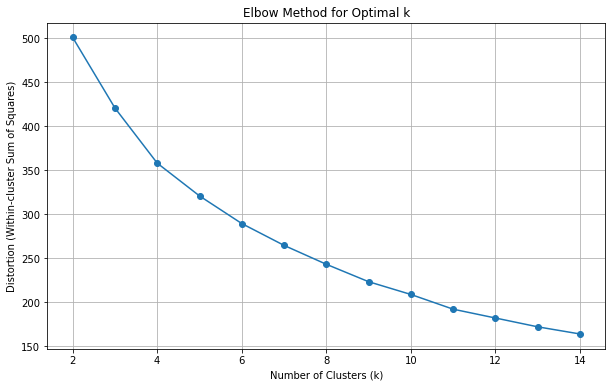

In [186]:
res = kmeans_func(df_comp_design_try, 14)

Number of clusters: 2, Silhouette Score: 0.23, Davies-Bouldin Index: 1.66
Number of clusters: 3, Silhouette Score: 0.22, Davies-Bouldin Index: 1.54
Number of clusters: 4, Silhouette Score: 0.23, Davies-Bouldin Index: 1.44
Number of clusters: 5, Silhouette Score: 0.23, Davies-Bouldin Index: 1.35
Number of clusters: 6, Silhouette Score: 0.23, Davies-Bouldin Index: 1.3
Number of clusters: 7, Silhouette Score: 0.24, Davies-Bouldin Index: 1.31
Number of clusters: 8, Silhouette Score: 0.24, Davies-Bouldin Index: 1.27
Number of clusters: 9, Silhouette Score: 0.25, Davies-Bouldin Index: 1.19


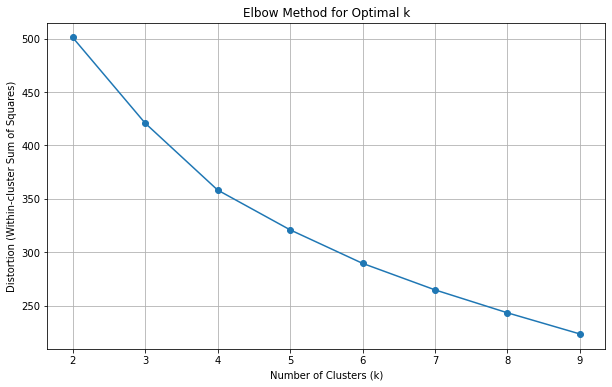

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        49.000000         13.328571         1140.816327          2187.755102
1        55.000000         11.994545          879.090909          1856.363636
2        73.000000         14.795890         1043.835616          2295.890411
3        60.000000         13.395000          954.166667          2116.666667
4        93.000000         14.419355         1073.118280          2395.161290
5        41.000000         14.465854          978.048780          1889.024390
6        53.000000         13.816981         1251.886792          2197.169811
7        52.000000         13.411538         1000.000000          1898.076923
8        45.000000         15.322222         1112.222222          2081.111111
average  57.888889         13.883329         1048.131733          2101.913260


In [190]:
res = kmeans_func(df_comp_design_try, 9)
clusters_describe_func(res)

Мы получаем схожие по размеру кластеры

In [191]:
create_cluster_frequency_tables(df, res)

Variable: gender

Frequency Table:
Cluster     0     1     2     3     4     5     6     7     8  R_Mean
gender                                                               
f        49.0  61.8  61.6  65.0  62.4  46.3  60.4  71.2  66.7    60.5
m        51.0  38.2  38.4  35.0  37.6  53.7  39.6  28.8  33.3    39.5


Variable: age_type

Frequency Table:
Cluster      0     1     2     3     4     5     6     7     8  R_Mean
age_type                                                              
25_35     53.1  47.3  54.8  33.3  57.0  56.1  45.3  57.7  46.7    50.1
36_45     46.9  52.7  45.2  66.7  43.0  43.9  54.7  42.3  53.3    49.9


Variable: city

Frequency Table:
Cluster           0     1     2     3     4     5     6     7     8  R_Mean
city                                                                       
Elkaterinburg  26.5  30.9  26.0  25.0  39.8  41.5  20.8  36.5  22.2    29.9
Moscow         46.9  40.0  39.7  36.7  33.3  24.4  49.1  44.2  46.7    40.1
S_Peterburg    26.5  29

Качество кластеров среднее. Отличаются от 30 до 70% кластеров в зависимости от вопросов.


**Пробую сократить число кластеров до 6**

Number of clusters: 2, Silhouette Score: 0.23, Davies-Bouldin Index: 1.66
Number of clusters: 3, Silhouette Score: 0.22, Davies-Bouldin Index: 1.54
Number of clusters: 4, Silhouette Score: 0.23, Davies-Bouldin Index: 1.44
Number of clusters: 5, Silhouette Score: 0.23, Davies-Bouldin Index: 1.35
Number of clusters: 6, Silhouette Score: 0.23, Davies-Bouldin Index: 1.3


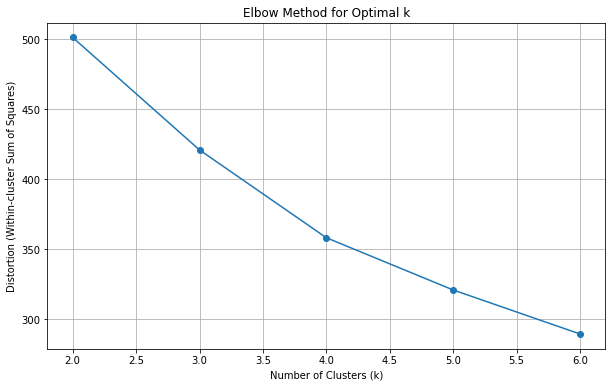

Size and consumption in clasters
             label  milk_consumption  butter_consumption  smetana_consumption
label                                                                        
0        82.000000         14.995122         1020.121951          2232.926829
1        87.000000         13.611494          945.977011          2036.781609
2        98.000000         14.051020         1038.265306          2340.816327
3        82.000000         11.432927         1022.560976          1862.195122
4        77.000000         15.759740         1257.142857          2453.246753
5        95.000000         13.769474         1027.894737          1911.578947
average  86.833333         13.936630         1051.993806          2139.590931


In [195]:
res = kmeans_func(df_comp_design_try, 6)
clusters_describe_func(res)

In [196]:
create_cluster_frequency_tables(df, res)

Variable: gender

Frequency Table:
Cluster     0     1     2     3     4     5  R_Mean
gender                                             
f        62.2  65.5  64.3  61.0  59.7  53.7    61.1
m        37.8  34.5  35.7  39.0  40.3  46.3    38.9


Variable: age_type

Frequency Table:
Cluster      0     1     2     3     4     5  R_Mean
age_type                                            
25_35     59.8  37.9  59.2  51.2  40.3  52.6    50.2
36_45     40.2  62.1  40.8  48.8  59.7  47.4    49.8


Variable: city

Frequency Table:
Cluster           0     1     2     3     4     5  R_Mean
city                                                     
Elkaterinburg  29.3  24.1  40.8  31.7  18.2  34.7    29.8
Moscow         36.6  41.4  33.7  42.7  50.6  35.8    40.1
S_Peterburg    34.1  34.5  25.5  25.6  31.2  29.5    30.1


Variable: income

Frequency Table:
Cluster     0     1     2     3     4     5  R_Mean
income                                             
High      1.2   1.1   NaN   3.7   5.2   

Качество еще хуже чем в предыдущем варианте

Из всего блока кластеризаций по кластерам дизайна и предпочтений и по их компонентам наилучшие результаты показал подход кластеризации по кластерам с формированием 6ти новых кластеров

